# S&P 2019 Data Exploration Stage

**by Marc Angelo Acebedo**

# Table of Contents
- [Introduction](#introduction)
- [Data Setup & Overview](#setup)
- [Preliminary Wrangling](#prelim)
- [Exploration](#explore)
    - [Univariate](#uni)
    - [Bivariate](#bi)
    - [Multivariate](#multi)
- [Conclusions](#conclude)

# I) Introduction <a id = "introduction"> </a>


- I kept features in separate CSVs because date formats differ. `eps_fc` and `eps_act` 

### After cleaning the original dataset as documented in my data wrangling process [here](TK) tk, I isolated the following columns:

### `features.csv`
- **firm_id** : foreign key referring to primary keys in `firms.csv`
- **feature** : type of feature that the **value** field denotes (eps_fc, eps_act, eod_act, eps_fc_terms) 
- **date**    : DateTime object in YYYY-MM-DD format 
    - for **eod_act**, means the date at which the value was recorded
    - for **eps_fc_terms**, means the date at which the term forecast was made
- **term** :  period object in YYYYQQ format (the time period when the value was recorded)
    - FISCAL years for eps_fc, eps_act, and eps_fc_terms
    - CALENDAR years for eod_act
- **value** : displays the EPS or EOD value as specified in the 'feature' column.

### `avgs.csv`
- **firm_id** : foreign key referring to the primary keys in `firms.csv`
- **average** : recorded average value as specified in the `average_type` column
- **average_type** : type of average denoted (twenty year, quarterly, or yearly)
- **time_period** : time period that the average is recorded:
    - for twenty-year averages, it's NaN
    - for yearly averages, displays the year (YYYY)
    - for quarterly averages, displays the quarter (QQ)
- **feature** : type of feature recorded for the average (eps_fc, eps_act, eod_act, eps_fc_terms)

# II) Data Setup & Overview<a id = "setup"></a> 

In [1]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import statsmodels.api as sm
import math 
import random
import calendar

from matplotlib import cm

%matplotlib inline
plt.style.use('bmh')

In [2]:
#define data directories
PATH_CLEAN = './data/clean/'
PATH_CLEAN_AVGS = './data/clean/averages/'

In [3]:
#define visuals destination
PATH_UNIVARIATE = './visuals/univariate/'
PATH_BIVARIATE = './visuals/bivariate/'
PATH_MULTIVARIATE = './visuals/multivariate/'

**Import features and all averages**

In [4]:
features = pd.read_csv(PATH_CLEAN + 'features.csv', low_memory = False)
avgs = pd.read_csv(PATH_CLEAN_AVGS + 'avgs.csv')

In [5]:
#import firm_ids for foreign key references
firm_ids = pd.read_csv(PATH_CLEAN + 'firms.csv')

### Describe Datasets

In [6]:
#look at 5 random entries
features.sample(5)

firm_id       feature        date    term     value
94409       137        eps_fc         NaN  2019Q2  1.685000
115234      385        eps_fc         NaN  2017Q3  1.569000
46981        57  eps_fc_terms  2000-01-01  2000Q2  0.528000
162409      442       eps_act         NaN  2009Q2  0.670000
148091      272       eps_act         NaN  1999Q4  0.233333

In [7]:
avgs.sample(5)

firm_id   average average_type time_period       feature
24028      293       NaN       yearly        2000       eod_act
41667      257  0.669250       yearly        2015  eps_fc_terms
23068      343 -0.286667       yearly        2019       eps_act
36690      330  1.653250       yearly        2005  eps_fc_terms
40784      384  1.151000       yearly        2013  eps_fc_terms

In [8]:
print('FEATURES rows, columns = {}'.format(features.shape), '\n',
      'AVERAGES rows, columns = {}'.format(avgs.shape))

FEATURES rows, columns = (167660, 5) 
 AVERAGES rows, columns = (52015, 5)


### Convert DateTime columns

In [9]:
features.dtypes

firm_id      int64
feature     object
date        object
term        object
value      float64
dtype: object

In [10]:
features.date = pd.to_datetime(features.date)
features.term = pd.to_datetime(features.term).dt.to_period('Q')

In [11]:
#verify dtypes
features.dtypes

firm_id             int64
feature            object
date       datetime64[ns]
term        period[Q-DEC]
value             float64
dtype: object

In [12]:
avgs.dtypes

firm_id           int64
average         float64
average_type     object
time_period      object
feature          object
dtype: object

In [13]:
features.sample(5)

firm_id       feature       date    term  value
106849      286        eps_fc        NaT  2000Q2  0.218
54898       155  eps_fc_terms 2019-04-01  2019Q3  1.942
79518       463  eps_fc_terms 2014-04-01  2014Q3  0.816
109340      315        eps_fc        NaT  2014Q1  0.579
147021      259       eps_act        NaT  2005Q2    NaN

# III) Preliminary Wrangling <a id = "prelim"></a>

### Structure of the Datasets
> Our `features.csv` dataset contains 167,660 entries with 5 features. Firm ID, feature, date, and term are all categorical variables while the value field is numeric and continuous. Even though the date and term fields are recorded as DateTime and Period objects respectively, they are still discrete, categorical data, because there is a limit to the year that can be recorded (1999 - 2020) and there cannot be more than 4 quarters (Q1 - Q5).

> Our `avgs.csv` dataset contains 52,015 entries with 5 features. Firm ID, average type, time period, and feature are all categorical variables while the average field is numeric and continuous. 


### Main features(s) of interest in the dataset

> I'm interested in seeing the ***historical correlation of forecasted vs. actual EPS across all firms in the 2019 S&P Index.***

- **eps_fc**, **eps_act** are the main variables of interest—they are consistent in measuring both the *forecasted* and *actual* EPS of all 505 firms, per fiscal period, over a span of 20 years.
- **eod_act** is recorded based on ***calendar period*** instead of fiscal period, which is a flaw in the data. However, it can be used for some further exploration.
- **eps_fc_terms** is based on ***fiscal period***. Although it depicts forecasted EPS, this is still not a main variable of interest because it can *extend* my main research question, but not fully answer it.

> As somebody with very little familiarity with the stock market, I decided to dabble a little in the stock market. I read the book "A Beginner's Guide to the Stock Market" by Matthew R. Kratter, which piqued my interest in stock market trading—particularly dividend stocks. I decided that if I were going to educate myself further on the stock market, then this thesis project to end my senior year at NCF would be a perfect opportunity to directly explore this new interest. Not only would I be educating myself on how the stock market works, but I would also be *working directly with stock market data*, which will help me build further intuition in future stock market and finance-related projects.

These are the questions I'd like to pose in my exploratory stage:

- What is the difference in means between average forecasted and actual EPS of each firm for the past 20 years?
- What is the relationship between forecasted EPS for both forecasts made at the beginning of the fiscal period and three months prior?
- Does historical EOD price correlate with forecasted EPS? How about actual EPS?
- For both the highest-performing and lowest-performing companies, do EPS forecasts show a pessimistic and/or optimistic view of their company value?

### Features in the dataset that will support my investigation into the features of interest

> For the broadest overview, I predict that ***overtime, EPS forecasts will continually become optimistic for those firms that consistently have high actual EPS values. Vice versa, overtime, EPS forecasts will continually become pessimistic for those firms that consistently have lower-than-expected EPS values.*** As for the other factors, I expect yearly values to show more consistency in pattern (since it is more intuitive to measure 20 years) than quarterly values (since economic situations are greatly diverse over the period of 20 years, no matter the period).

- kept **time_period** as an object bc column consists of varying DateTime formats

# IV) Exploration <a id="explore"> </a>

## A) Univariate <a id = "uni"></a>

### MISSING VALUES (Features)

In [14]:
sb.set(style = "darkgrid")

In [15]:
def generate_missing_total(df, title_name, save_path, csv_name):
    plt.figure(figsize = [10, 5])
    plt.title('Missing Values per Column under ' + title_name, size = 20)
    na_counts = df.isna().sum().sort_values(ascending = True)
    
    na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
    plt.xlabel('Count', size = 10)
    plt.ylabel('Column Name', size = 10)
    plt.savefig(save_path + csv_name)

In [16]:
features.isna().any()

firm_id    False
feature    False
date        True
term       False
value       True
dtype: bool

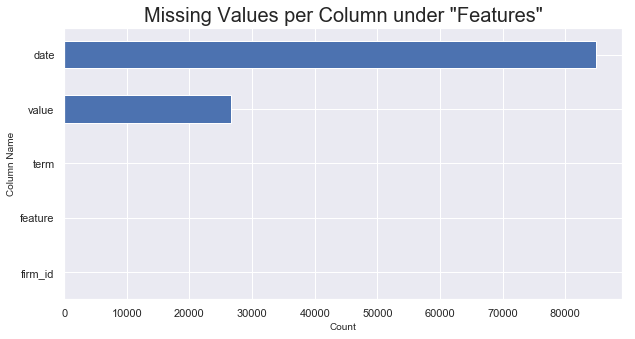

In [17]:
generate_missing_total(features, '"Features"', PATH_UNIVARIATE, 'features-missing-total.png')

**Observation 1:** `date` is the field with the highest amount of missing data, with around **85,000 missing entries.**

**Observation 2:** `value` contains around **26,000 missing entries.***

**Observation 3:** The gap in number of missing values between *value* and *date* is noticeably large.
- This makes sense because *date* is automatically set to 'NaT' for *eps_fc* and *eps_act*.

--- 

**Questions**

1)  For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?

In [18]:
features_date_dropna = features[features['date'].notna()]

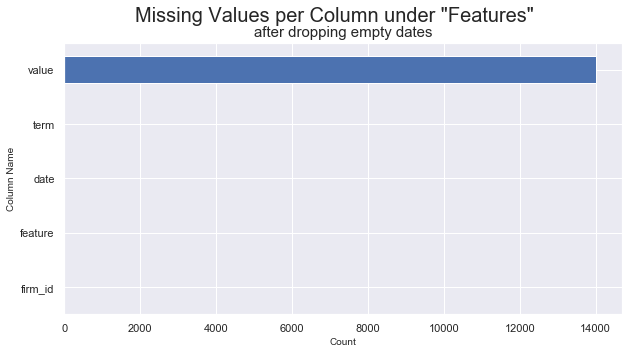

In [19]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Features"', size = 20)
plt.title('after dropping empty dates', size = 15)
na_counts = features_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'features-missing-date-dropna.png')

### Question 1: For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?
### Answer

**Observation 1:** Keeping NaT dates, the amount of overall missing values is around **26,000**. After dropping all the NaT dates (dropping `eod_act`and `eps_fc_terms`), the amount of missing values dropped to around **14,000.**

**Observation 2:** Drawing from the previous observation, this means that `eps_fc` and `eps_act` both have around **12,000** missing values in total.

**Observation 3:** Effectively, the undropped columns, `eod_act` and `eps_fc_terms`, have around **14,000** missing values in total.

---

**Questions:**

2) How many missing values does each feature have, individually?

In [20]:
#turn feature values into index values
features_num_nan = features[['feature', 'value']].groupby('feature').count()

In [21]:
#count number of total values (NaN or not) per feature
feature_counts = features.feature.value_counts()

In [22]:
#create function to calculate number NaN
def calculate_nan(num_nan, counts, feature_name):
    num_nan.loc[feature_name] = counts[feature_name] - num_nan.loc[feature_name]
    #num NaN (feature) = num all values (NaN or not) - num all values (not NaN)
    
#create array of feature names
feature_names = ['eps_fc', 'eps_act', 'eod_act', 'eps_fc_terms']

In [23]:
#update all nan counts per average type
for feature_name in feature_names:
    calculate_nan(features_num_nan, feature_counts, feature_name)

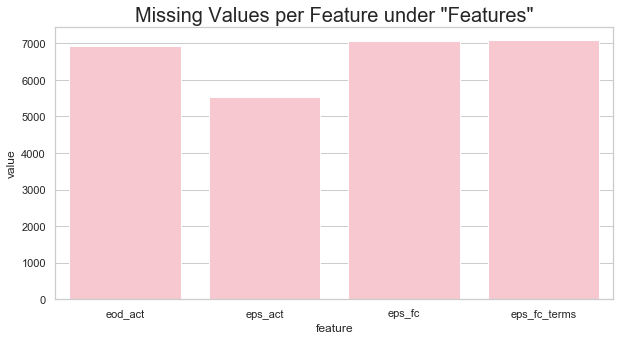

In [24]:
plt.figure(figsize = [10, 5])
sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Features"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = features_num_nan.index, y = features_num_nan.value, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'features-missing-per-feature.png')

**Observation 1:** The feature with the most amount of missing values is `eps_fc_terms`.

**Observation 2:** The feature with the least amount of missing values is `eps_act`.

**Observation 3:** `eod_act`, `eps_fc`, and `eps_fc_terms` all have a very small gap in missing data comparedto `eps_act`

### Question 2: How many missing values does each feature have, individually?

### Answer:

**Observation 1:** Below is a list of each feature and their corresponding estimated number of missing values:

- `eod_act` : 7900
- `eps_act` : 5500
- `eps_fc` : 7050
- `eps_fc_terms` : 7100

**Observation 2:** `eps_fc` and `eps_act` have around 12,000 missing values total, which is consistent with our previous observation.

**Observation 3:** `eod_act` and `eps_fc_terms` have around 14,000 missing values total, which is also consistent with our previous observation.



### MISSING VALUES (Averages)

In [25]:
avgs.isna().any()

firm_id         False
average          True
average_type    False
time_period      True
feature         False
dtype: bool

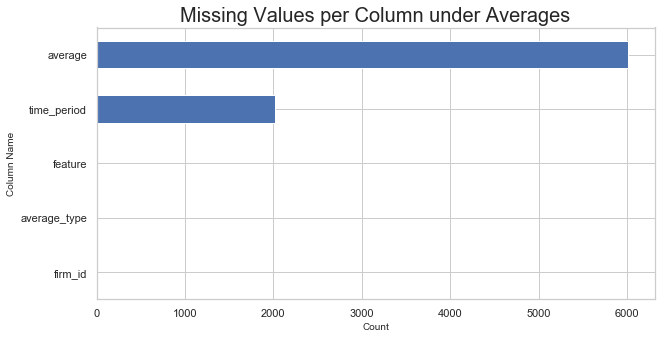

In [26]:
#averages
generate_missing_total(avgs, 'Averages', PATH_UNIVARIATE, 'avgs-missing-total.png')

**Observation 1:** The *average* column contains 6,000 missing data entries.

**Observation 2:** The *time_period* column contains exactly 2,000 missing data entries.

**Observation 3:** The gap in missing values between *average* and *time_period* is 4,000. 

**Observation 3:** By default, all entries with *average_type* of **twenty_year** should have **NaT** fields for *time_period*. 

---

**Questions:**

3) After dropping all NaT fields under *time_period*, how large will the gap in missing values be between *values with the NaT dates* and *values after dropping the NaT dates*?

4) How many missing *average* values does each *average_type* contain?



In [27]:
avgs_date_dropna = avgs[avgs['time_period'].notna()]

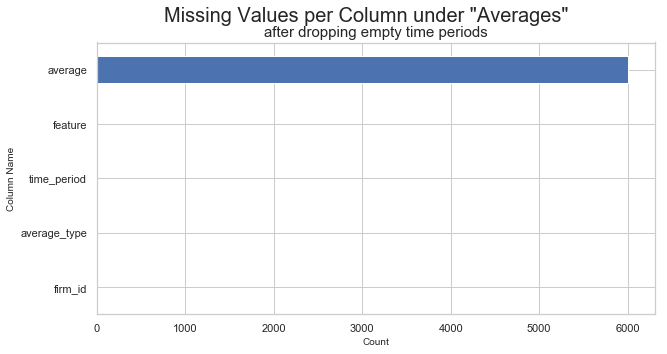

In [28]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Averages"', size = 20)
plt.title('after dropping empty time periods', size = 15)
na_counts = avgs_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-date-dropna.png')

### Question 3:  After dropping all NaT fields under time_period, how large will the gap in missing values be between values with the NaT dates and values after dropping the NaT dates?

### Answer: 
**Observation 1:** After dropping all NaT dates under *time_period*, there are still 6,000 missing *averages*. This is number is consistent with the number of missing *averages* even before dropping NaT dates. Thus, **all entries with a missing time period** (aka all **twenty_year** average types) **did not contain any empty data.**

**To summarize the above, the number of missing *average values* remains the same whether or not you drop all entries with empty time periods, aka all twenty_year average types.**

In [29]:
#turn avg values into index values
avgs_num_nan = avgs[['feature', 'average']].groupby('feature').count()

In [30]:
#count number of total values (NaN or not) per feature
avgs_counts = avgs.feature.value_counts()

In [31]:
#update number of missing values for each average type
for feature_name in feature_names:
    calculate_nan(avgs_num_nan, avgs_counts, feature_name)

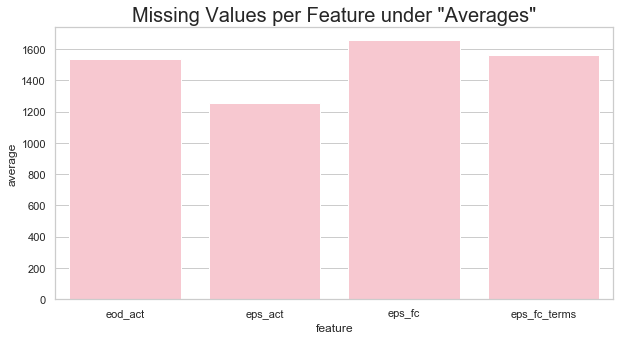

In [32]:
plt.figure(figsize = [10, 5])
# sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Averages"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = avgs_num_nan.index, y = avgs_num_nan.average, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-per-feature.png')

**Observation 1:** *eps_fc* has the most missing values at around 1650.

**Observation 2:** *eps_act* has the least amount of missing values at around 1250.

**Observation 3:** Under "Averages", the gap in missing values between each average type is ***larger*** than the missing values under "Features".

### Question 4: How many missing average values does each average_type contain?

### Answer:

**Observation 1:** Each average type has the following *approximate* number of ***missing averages***:

- `eod_act` : 1550
- `eps_act` : 1250
- `eps_fc` : 1650
- `eps_fc_terms` : 1590

### FIRM_ID (Features)

> Since 505 firms is too much to fit into one single visual, I decided to split them apart by focusing on the ***20 most common firm ids*** and the ***20 rarest firm ids***.

In [33]:
def generate_pct_bar(df, cat_var, color):
    cat_counts = df[cat_var].value_counts()
    ax = sb.countplot(data = df, y = cat_var, order = cat_counts.index, palette = color)
    
    n_points = df.shape[0]
    locs, labels = plt.yticks()
    
    for p in ax.patches:
        percentage = '{:0.1f}%'.format(100 * p.get_width()/n_points)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 20)

In [34]:
features_firm_id_top = features.firm_id.value_counts()[:20].index
features_firm_id_top_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_top_lim.firm_id.nunique()

20

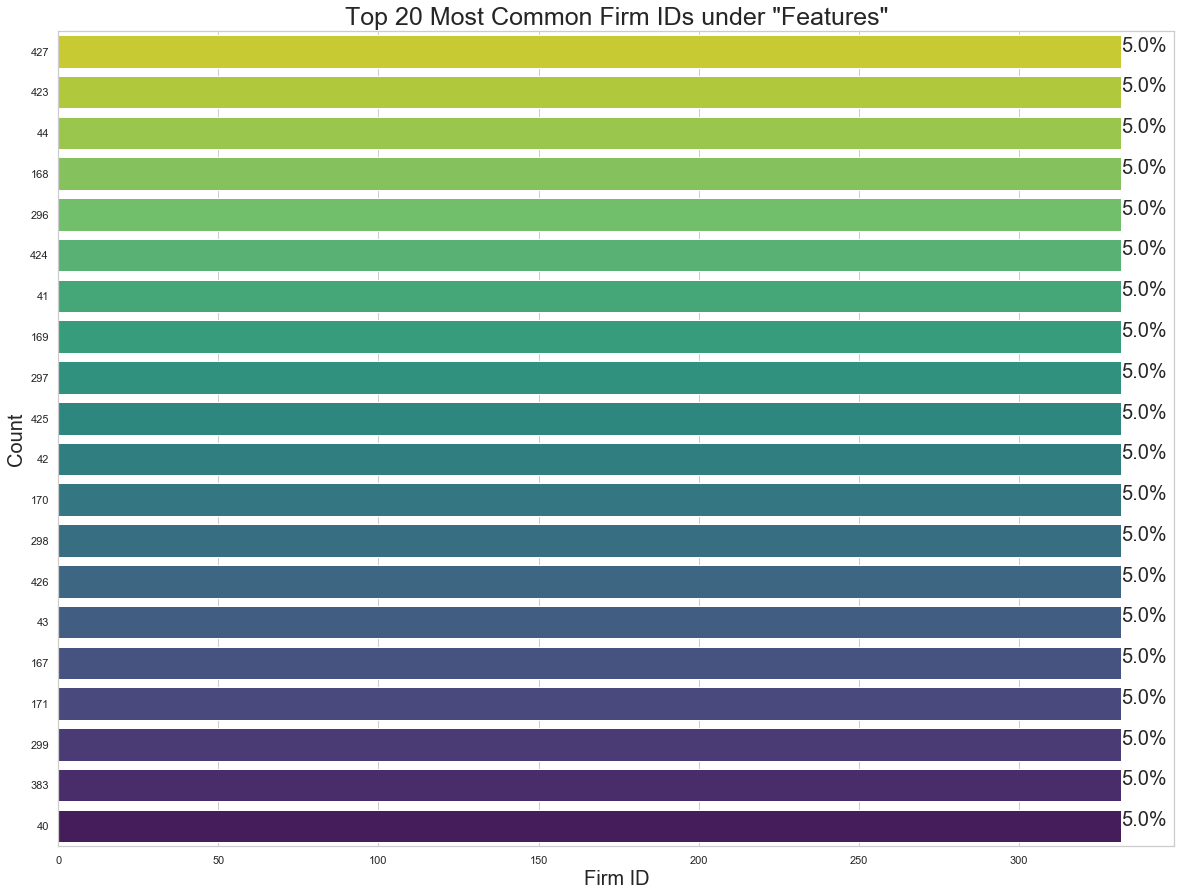

In [35]:
plt.figure(figsize = [20, 15])
x = features_firm_id_top_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('Top 20 Most Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-top.png');
plt.show();

In [36]:
features_firm_id_bottom = features.firm_id.value_counts()[-20:].index
features_firm_id_bottom_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_bottom_lim.firm_id.nunique()

20

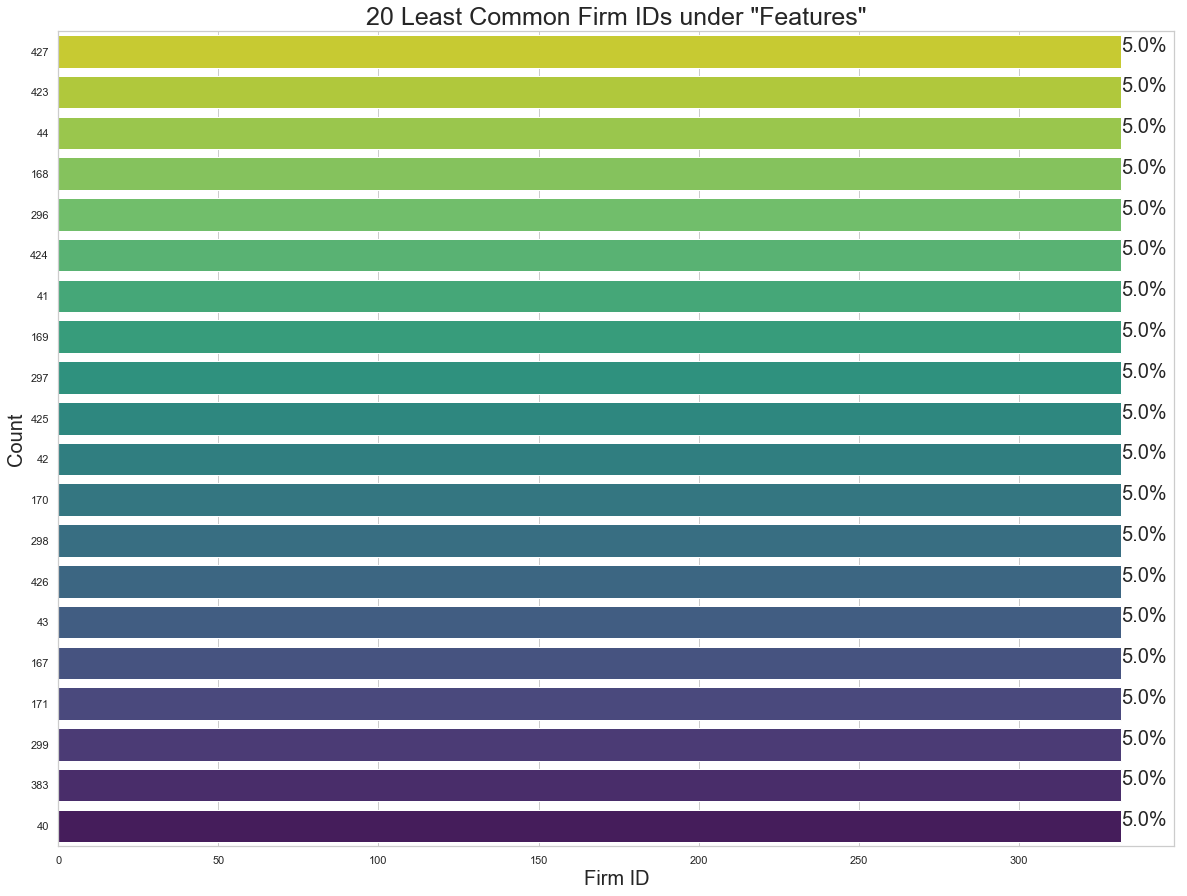

In [37]:
plt.figure(figsize = [20, 15])
x = features_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Features", there is a **consistent count among all Firm IDs** at around 335.

In [38]:
#check consistency of counts among firm_ids
firm_counts = features.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([332], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire features.csv dataset*** at 332 entries per firm id. There are no null firm ids.

### FEATURE (Features)

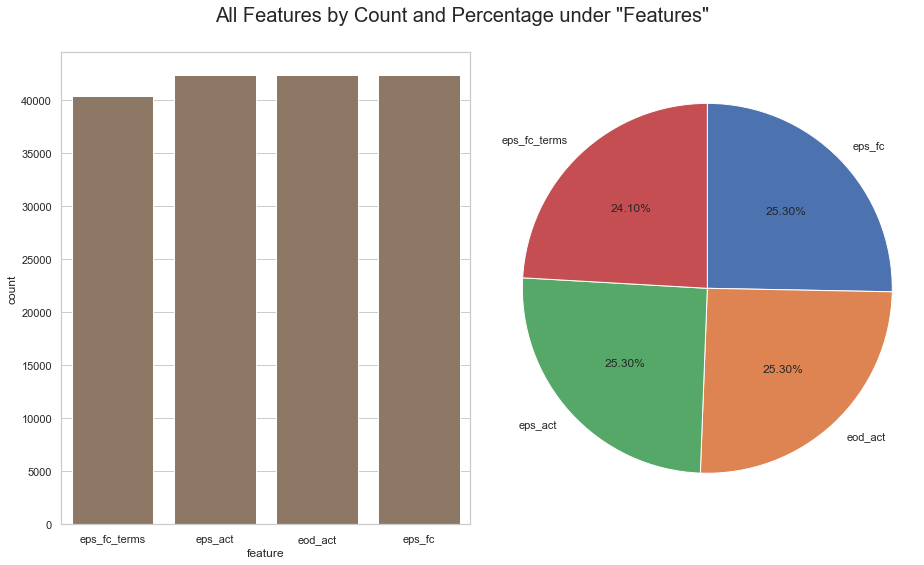

In [39]:
import itertools
plt.figure(figsize = [13, 8])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
sb.countplot(data = features, x = 'feature', order = features.feature.value_counts(ascending = True).index,
            color = base_color)
frame = plt.gca()

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = features['feature'].value_counts()
plt.pie(features.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = features.feature.value_counts().index);
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')


**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 42500 entries each (25.30% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 405,000 (24.10%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** (effectively removing 2020 entries).

### DATE (Features)

In [40]:
#double check that eps_fc and eps_act are the only features to have null Date entries
features[features.date.isna()].feature.unique()

array(['eps_fc', 'eps_act'], dtype=object)



> Since we acknowledged that the `date` column is set to NaT for `eps_fc` and `eps_act`, we will write all our interpretations accordingly.

### All below graphs under "Date" do not take into account the features `eps_fc` and `eps_act`.

In [41]:
features_years = features.date.dt.year.dropna().astype(int)
features_months = features.date.dt.month.dropna().astype(int)

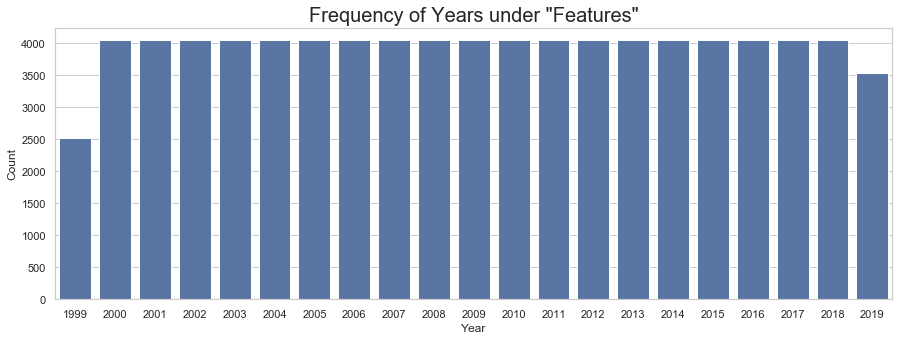

In [42]:
#years
plt.figure(figsize = [15, 5])

ax = sb.countplot(x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

**Observation 1:** All years between 2000 - 2018 have a consistent count at around 4,000 for all firms. 
- This makes sense, because the year 1999 is missing from all `eps_fc_terms` entries.

**Observation 2:** The years 1999 and 2019 are both *inconsistent* and *less than* the number of 4,000 counts for all other Date years.

**Observation 3:** The year 1999 has 2500 non-null entries.

**Observation 4:** The year 2019 has 3500 non-null entries.

---
**Questions:**

5) Under the "Date" field, under do the years 1999 and 2019 sum up to less than 4,000 for `eps_fc_terms` and `eod_act`?

In [43]:
#months
features_months = features_months.apply(lambda x: calendar.month_abbr[x])
months_order = ['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Oct', 'Dec']

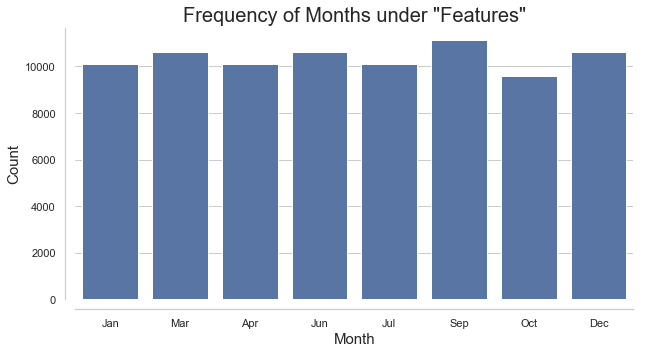

In [44]:
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features_months, color = sb.color_palette()[0], order = months_order)
ax.set(xlabel = 'Month', ylabel = 'Count')
ax.set_title('Frequency of Months under "Features"', size = 20)
sb.despine(offset = 10, trim = False)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-months-count.png')
plt.show();

**Observation 1:** September has the most number of counts at around 15,000.

**Observation 2:** October has the least number of counts at around 9,000.

**Observation 3:** The trend in counts of months under "Date" fluctuates. It is not a linear or exponential pattern; it seems that there is a "peak" in counts every 2nd *recorded* month from January.
- For example, March peaks at around 11,000 counts, then June peaks at around 10,500 counts, and Septemberat around 15,000.



### It is safe to conclude that the "Date" column is unreliable when *examining terms and years*, and should be avoided. It is better to use the "Date" column *only* when referring to specific dates.

### TERM (Features)

> As noted earlier, there are no missing values under the Term column. Therefore, all graphs below do account for `eps_act` and `eps_fc`.

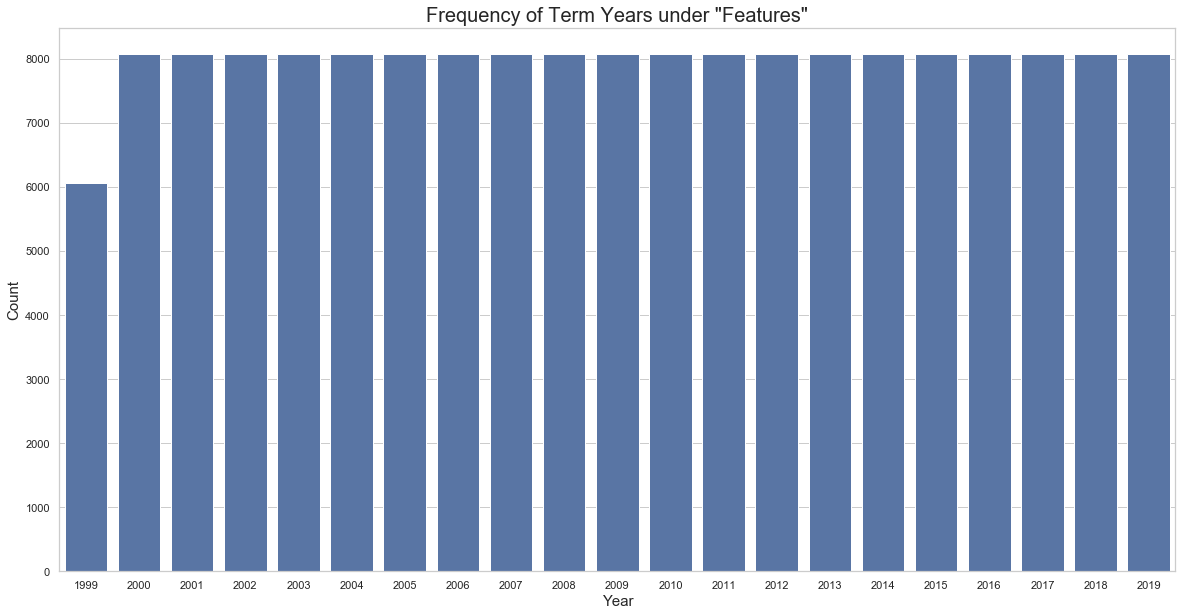

In [45]:
#years
plt.figure(figsize = [20, 10])

ax = sb.countplot(data = features, x = features.term.dt.year, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-years-count.png')
plt.show();

**Observation 1:** All years from 2000 to 2019 have consistent counts at 8,000 per year.

**Observation 2:** Unlike the years under Date, 1999 is the only year that does not follow the general trend. There are 6000 recorded entries containing 1999. This means that *2,000 entries do not contain the year 1999*.

---
**Questions:**
6) Which features under Term does not contain the year 1999?

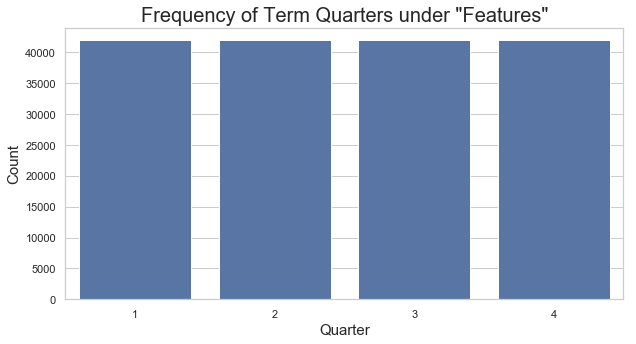

In [46]:
#quarter
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features.term.dt.quarter, color = sb.color_palette()[0])
ax.set(xlabel = 'Quarter', ylabel = 'Count')
ax.set_title('Frequency of Term Quarters under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-quarters-count.png')
plt.show();

**Observation 1:** There is a consistent number of ***quarters*** under **term**, unlike years.

**Observation 2:** This means that *quarters* is a more stable, reliable variable to examine under **Term** unlike *years*, which should be examined more closely in regard to which feature(s) contains that year.

### VALUE (Features)

In [47]:
def generate_hist(df, x, bins, title, xlabel, ylabel, save_path, csv_name):
    plt.figure(figsize = [14, 7])
    
    plt.hist(data = df, x = x, bins = bins, color = 'palevioletred')
    plt.title(title, size = 25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig(save_path + csv_name)

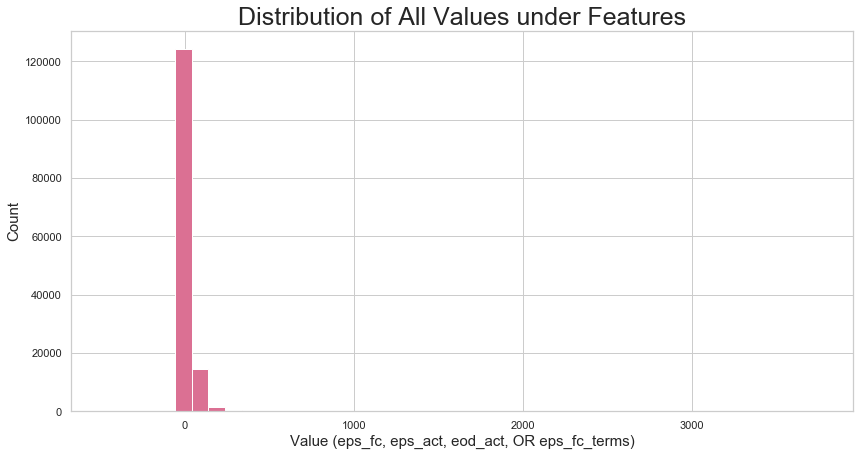

In [48]:
value_bins = np.arange(features.value.min(), features.value.max() + 100, 100)
generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with over 120,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

---

**Questions:**

7) How do value counts under Features look like after removing all outliers around the value range 0-300?

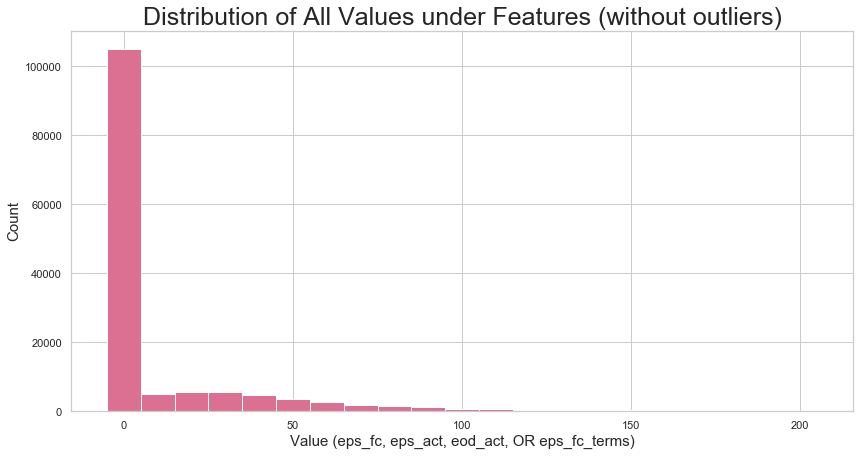

In [49]:
value_bins = np.arange(-5, 200 + 10, 10)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (without outliers)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-1.png')

### Question 7: How do value counts under Features look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 12,000 points.
- This graph shows that the bin range 0-10 contains around 12,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***.

### It would be a good idea to break down the 0-10 bin range even further, and examine solely that range.

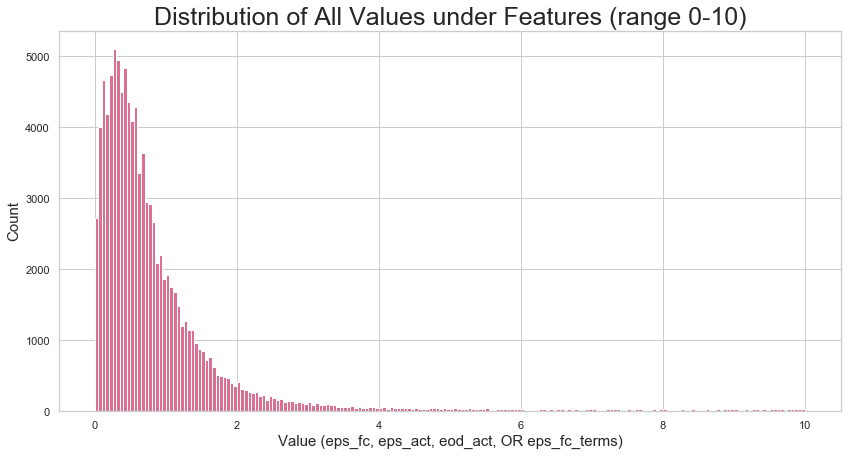

In [50]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (range 0-10)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

 

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

In [51]:
def generate_distplot(data, bins):
    fig = plt.figure(figsize = [14, 7])
    ax = sb.distplot(data, bins = bins, color = 'hotpink')
    ax.minorticks_on()
    return fig, ax

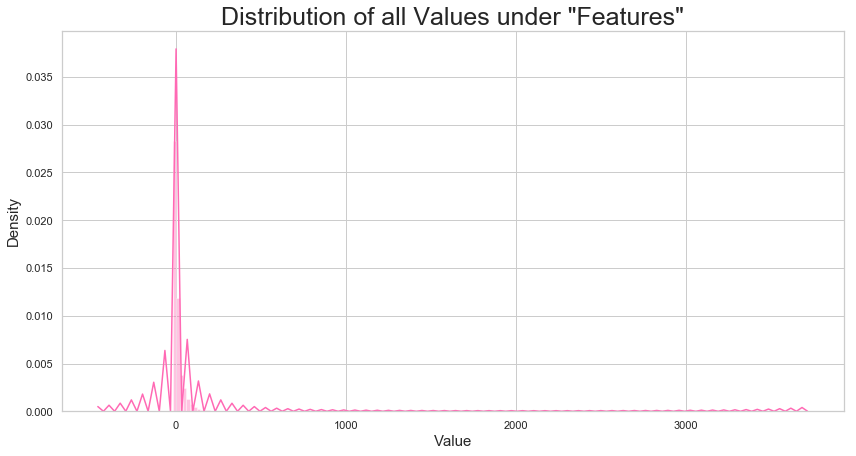

In [52]:
value_bins = np.arange(features.value.min(), features.value.max() + 20, 20)
generate_distplot(features.value.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'features-value-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `values` under Features is heavily right-skewed. This means that ***most values are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.

### FIRM_ID (Averages)

In [53]:
avgs_firm_id_top = avgs.firm_id.value_counts()[:20].index
avgs_firm_id_top_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_top_lim.firm_id.nunique()

20

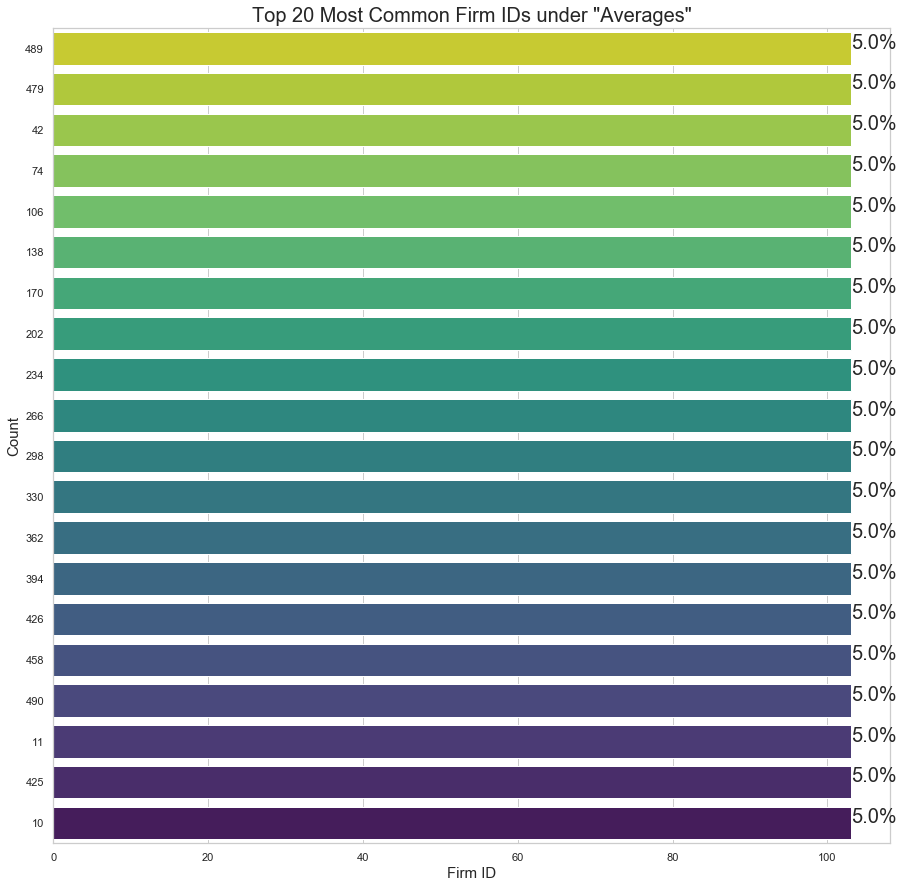

In [54]:
plt.figure(figsize = [15, 15])
x = avgs_firm_id_top_lim
num_bins = 5
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID')
plt.ylabel('Count')
plt.title('Top 20 Most Common Firm IDs under "Averages"', size = 20)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-top.png');
plt.show();

In [55]:
avgs_firm_id_bottom = avgs.firm_id.value_counts()[-20:].index
avgs_firm_id_bottom_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_bottom_lim.firm_id.nunique()

20

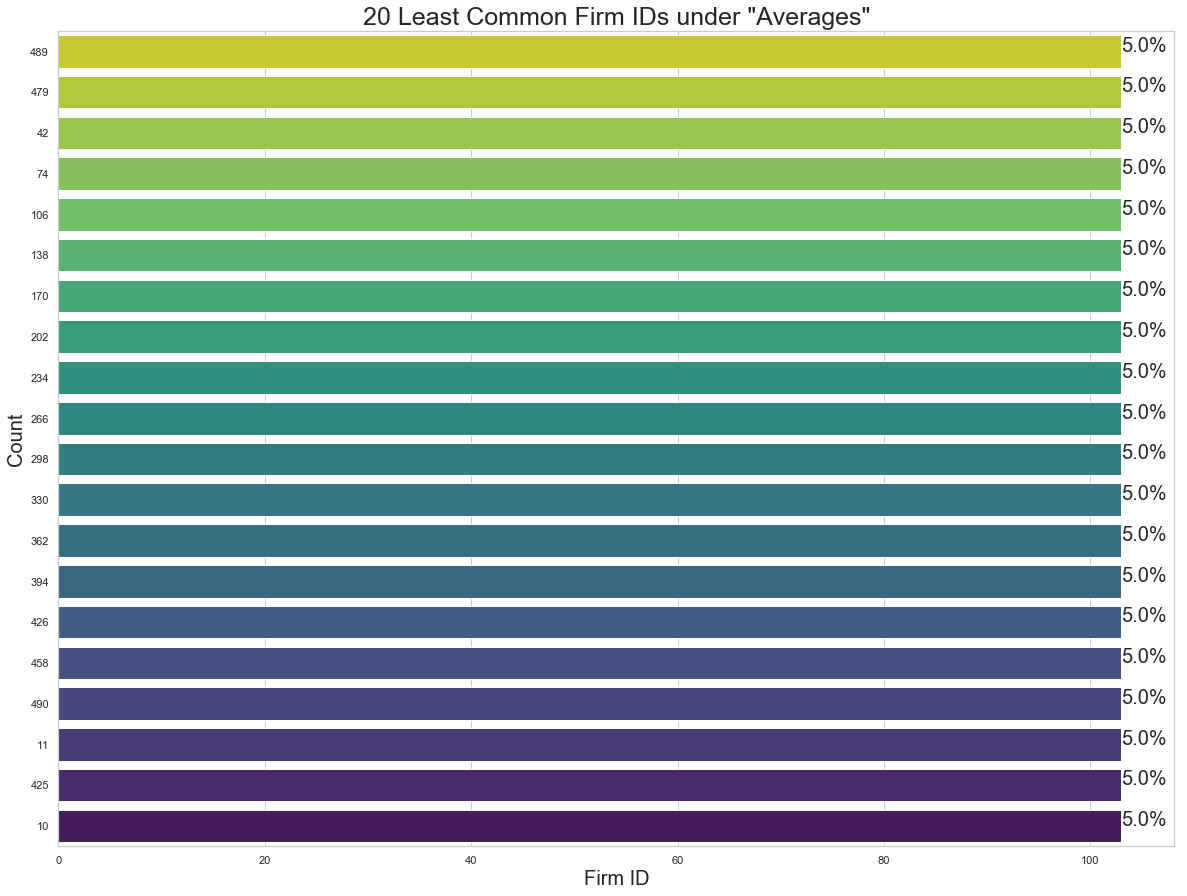

In [56]:
plt.figure(figsize = [20, 15])
x = avgs_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Averages"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Averages", there is a **consistent count among all Firm IDs** at around 105.

In [57]:
#check consistency of counts among firm_ids
firm_counts = avgs.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([103], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire avgs.csv dataset*** at 105 entries per firm id. There are no null firm ids.

### AVERAGE (Averages)

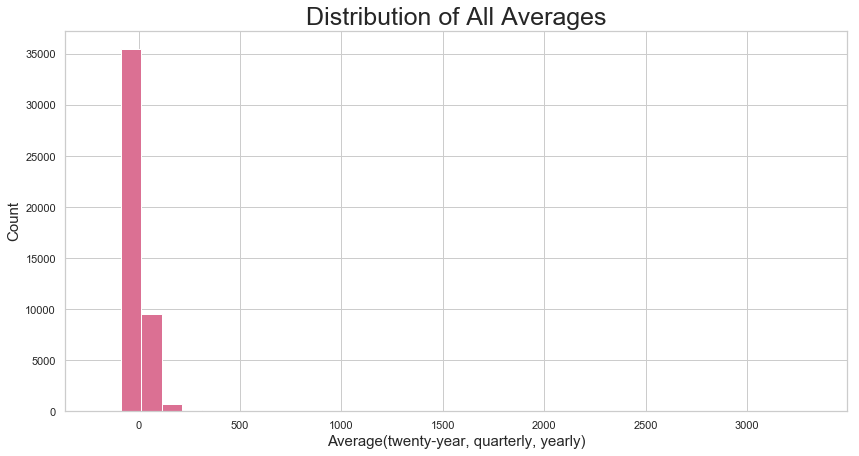

In [58]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 100, 100)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with around 36,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

**Observation 4:** There is a ***all values, whether under Features or Averages, share a common theme of taking up the "bulk" of data in the same bin range***

---

**Questions:**

8) How do value counts under Averages look like after removing all outliers around the value range 0-300?

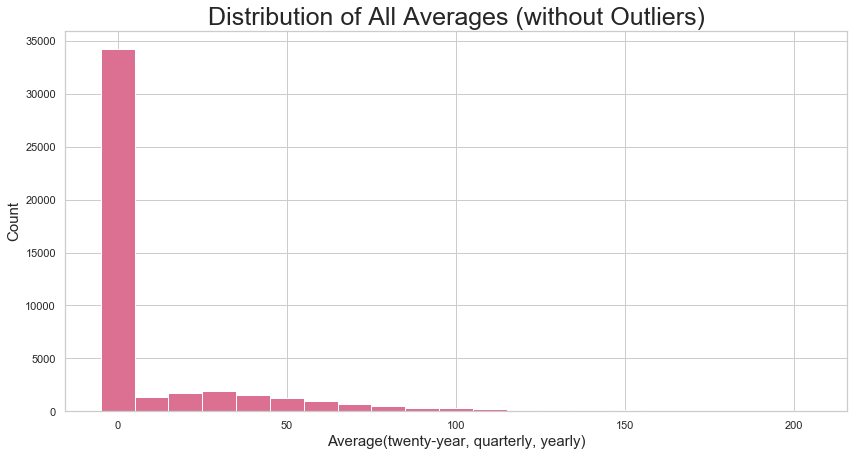

In [59]:
value_bins = np.arange(-5, 200 + 10, 10)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (without Outliers)', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist-zoom-1.png')

### Question 8: How do average counts under Averages look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the previous graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 36,000 points.
- This graph shows that the bin range 0-10 contains around 34,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***, with the other ~2,000 points being scattered among the bins from 10 to 110.

**Observation 4:** Among the bins from 10 to 110 that contain the other 2,000 points, the bin 30-40 contains the "bulk" of that data at around 2,000 points.

### It would be a good idea to break down the 0-10 bin range even further for Averages, and examine solely that range.

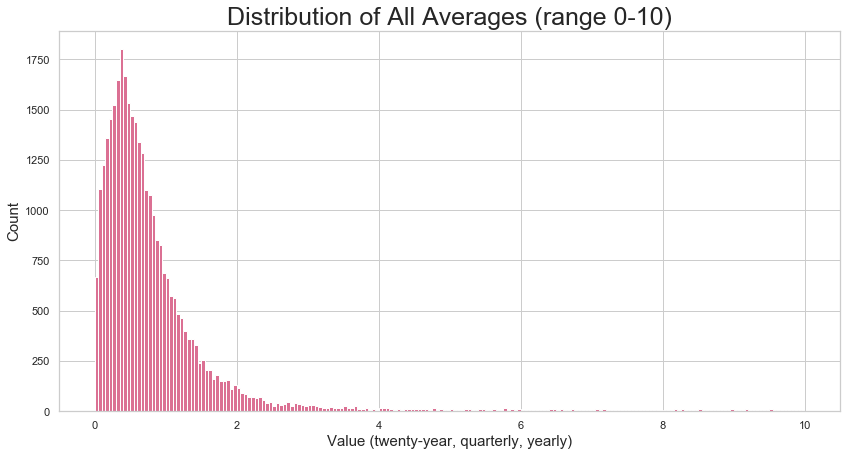

In [60]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (range 0-10)', 
                'Value (twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avgs-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

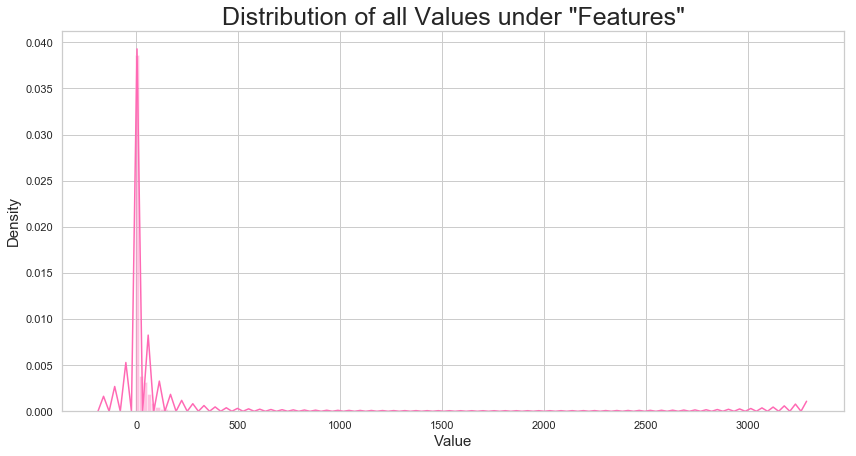

In [61]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 20, 20)
generate_distplot(avgs.average.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'avgs-average-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `average` under Averages is heavily right-skewed. This means that ***most averages are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.


**A KEY TAKEAWAY:** There is a strong congruency between the distribution patterns of ***values under Features*** and ***averages under Averages***. 
> This is perhaps because TK

### AVERAGE TYPE (Averages)

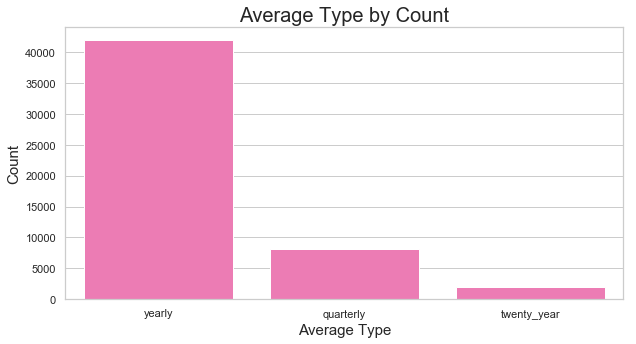

In [62]:
plt.figure(figsize = [10, 5])
cat_order = avgs.average_type.value_counts().index
sb.countplot(data = avgs, x = 'average_type', color = 'hotpink', order = cat_order)
plt.xlabel('Average Type')
plt.ylabel('Count')
plt.title('Average Type by Count', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-count.png')

**Observation 1:** Under Averages, **yearly** data has the highest number of counts while **twenty-year** data has the least number of counts. This all makes sense, as there are more yearly averages than quarters per firm, and more quarters than twenty-year entries per firm.
- For each firm, there are around 20 yearly averages (1999 to 2019) for each of the 4 features. (80 total per firm).
- For each firm, there are 4 quarterly averages for each of the 4 features. (16 total per firm)
- For each firm, there is 1 twenty-year average for each of the 4 features. (4 total per firm)

**Note:** number of entries may vary for *yearly averages* because the year 1999 and 2019 are missing for some features.

In [63]:
#keep for analysis, delete when done w/ report
len(avgs.query('average_type == "yearly" and firm_id == 0'))

83

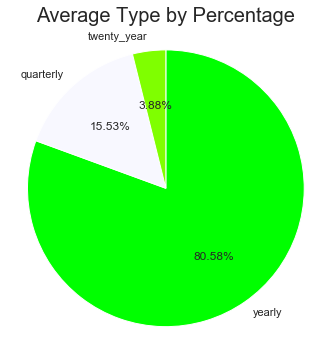

In [64]:
colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)

plt.figure(figsize = [10, 5])
cs=cm.Set1(np.arange(40)/40.)

plt.pie(avgs.average_type.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.average_type.value_counts().index, colors = colors);
plt.suptitle('Average Type by Percentage', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.axis('square');
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-pie.png')

**Observation 1:** As expected, yearly average types make up the majority of all entries at 80.58%.

**Observation 2:** As expected, twenty-year average types make up the least portion of all entries at 3.88%.

**Observation 3:** These percentages are consistent with the previous counts.

### TIME_PERIOD (Averages)

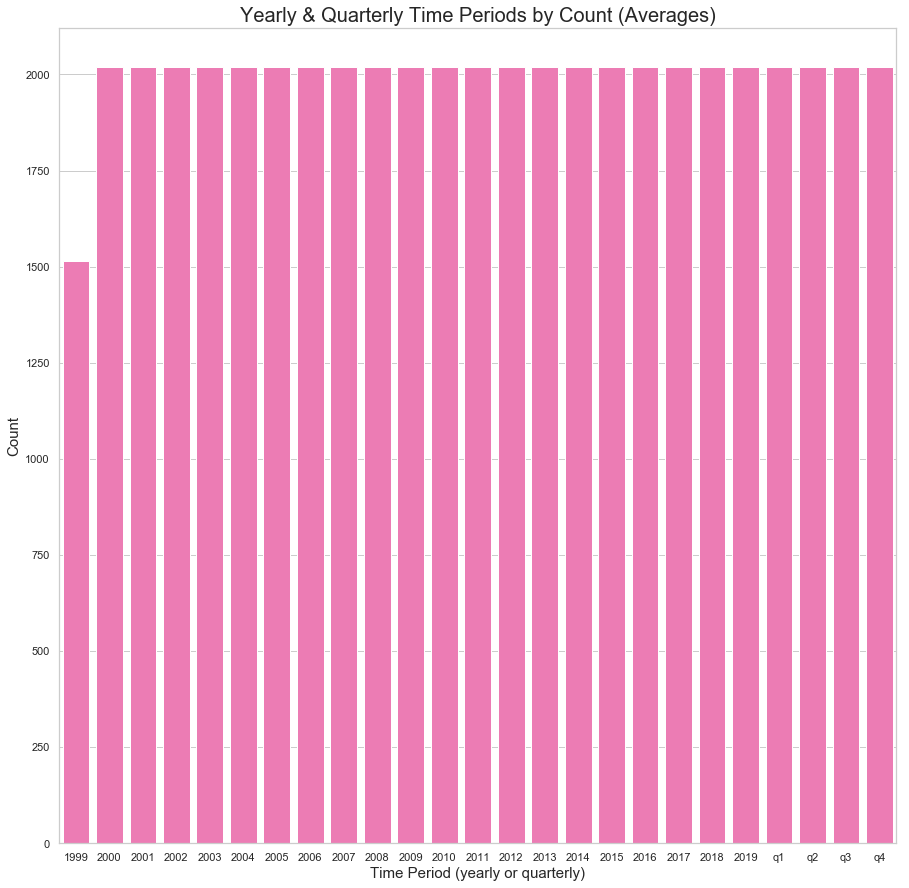

In [65]:
plt.figure(figsize = [15, 15])
cat_order = avgs.time_period.value_counts().sort_index().index
sb.countplot(data = avgs, x = 'time_period', color = 'hotpink', order = cat_order)
plt.xlabel('Time Period (yearly or quarterly)')
plt.ylabel('Count')
plt.title('Yearly & Quarterly Time Periods by Count (Averages)', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-time-period-hist.png')

> I decided to portray ***both yearly and quarterly Time Periods*** in the same countplot because q1-q4 and the years 2000-2019 show consistent counts.

**Observation 1:** All years from 2000-2019 **and** all quarters show consistent counts, at just over 2,000 entries each.

**Observation 2:** The year 1999 has the least amount of counts, at only around 1510. This is because the feature `eps_fc_terms` does not contain the year 1999.

**Observation 3:** The time period for `twenty-year` averages does not show because by default, all Time Period entries associated with average type of `twenty-year` is set to null.

### FEATURE (Averages)

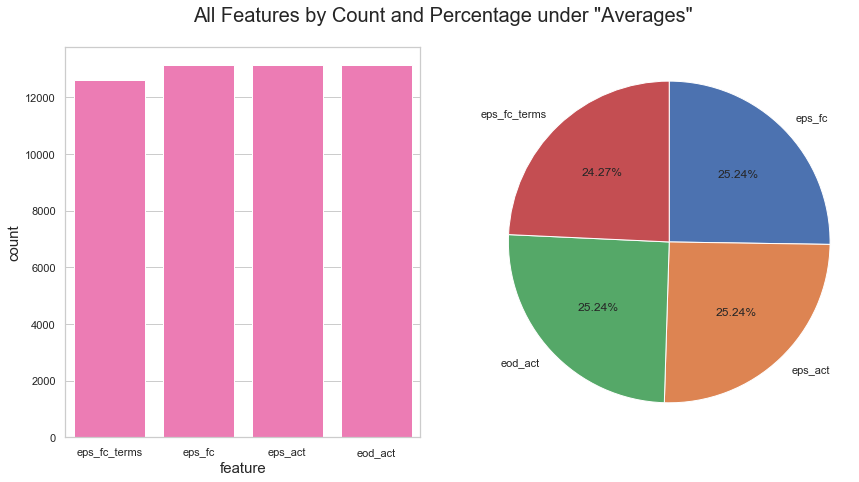

In [66]:
plt.figure(figsize = [14, 7])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
# generate_pct_bar(avgs, 'feature', 'Blues_d')
sb.countplot(data = avgs, x = avgs.feature, color = 'hotpink', order = cat_order)

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = avgs['feature'].value_counts()
plt.pie(avgs.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.feature.value_counts().index);
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Averages"', size = 20)
# plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'avgs-feature-hist-pie.png')

**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 13,000 entries each (25.24% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 12,500 (24.27%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** This effectively removes around 500 entries: not a substantial amount of data.

## IV) Bivariate Exploration<a id = "bi"></a>

> General rule: The *closer* the eps_act - eps_fc difference is to 0, the *more accurate* the forecast.

### VALUE by FEATURE

In [67]:
temp = features[features.feature.isin(['eps_fc', 'eps_act'])]

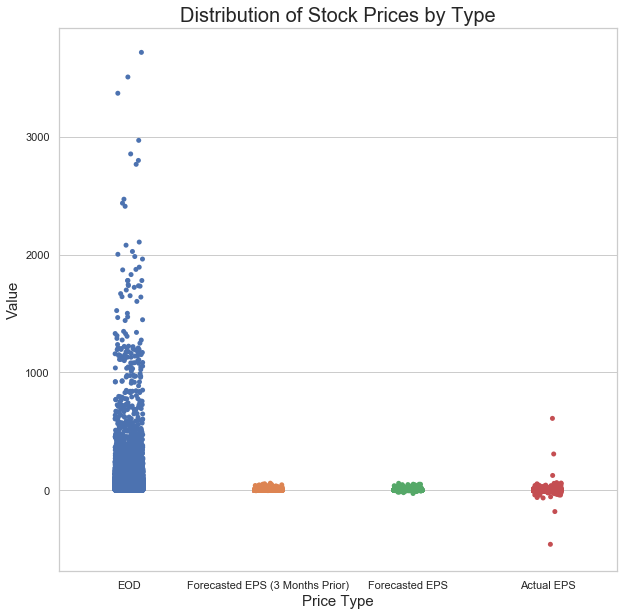

In [68]:
plt.figure(figsize = [10, 10])
sb.stripplot(x = 'feature', y = 'value', data = features, jitter = True)

plt.title('Distribution of Stock Prices by Type', size = 20)
plt.xlabel('Price Type')
plt.ylabel('Value')

plt.xticks([0, 1, 2, 3], ['EOD', 'Forecasted EPS (3 Months Prior)', 'Forecasted EPS', 'Actual EPS'])
plt.savefig(PATH_BIVARIATE + 'features-feature-value.png')
plt.show();

In [69]:
features_eod = features[features.feature == 'eod_act']

#create 5-year moving averages to "smooth" out all future graphs
features_eod['ma_value'] = features_eod.value.rolling(12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


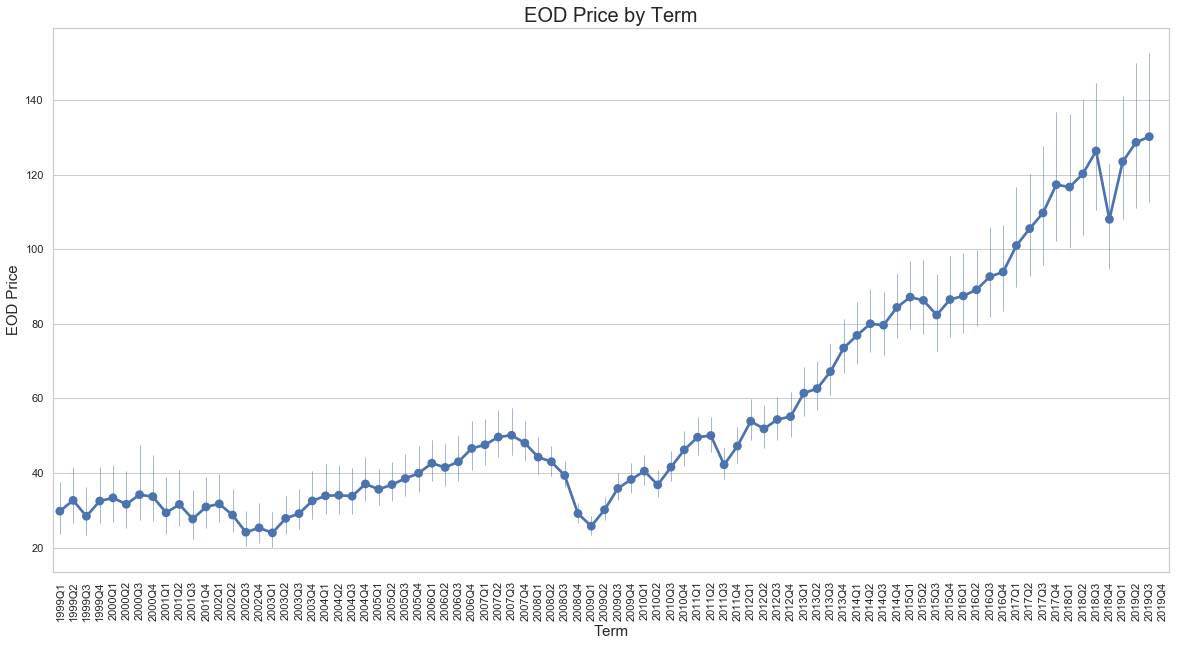

In [70]:
plt.figure(figsize = [20, 10])
sb.pointplot(x = 'term', y = 'value', data = features_eod, errwidth = 0.5)
plt.xticks(rotation = 'vertical')

plt.title('EOD Price by Term', size = 20)
plt.xlabel('Term')
plt.ylabel('EOD Price')

plt.savefig(PATH_BIVARIATE + 'features-eod-term.png')

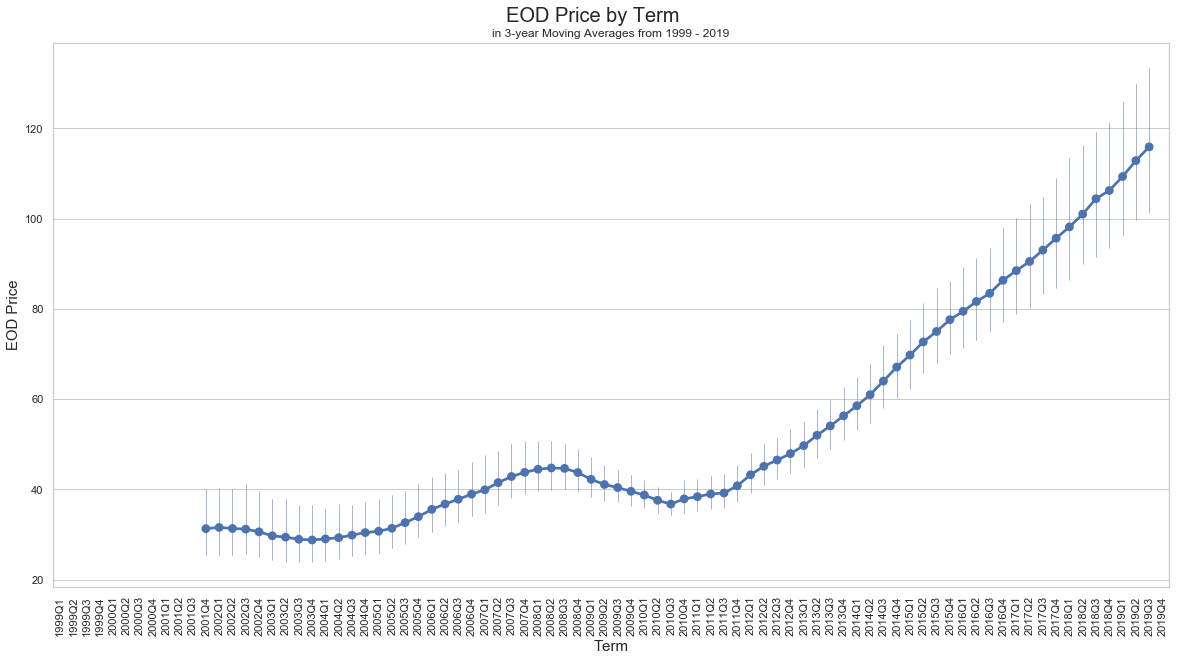

In [71]:
plt.figure(figsize = [20, 10])
sb.pointplot(x = 'term', y = 'ma_value', data = features_eod, errwidth = 0.5)
plt.xticks(rotation = 'vertical')

plt.suptitle('EOD Price by Term', size = 20, y = .93)
plt.title('in 3-year Moving Averages from 1999 - 2019')
plt.xlabel('Term')
plt.ylabel('EOD Price')

plt.savefig(PATH_BIVARIATE + 'features-eod-term-ma.png')

The EOD graph could be used to make correlations with EPS forecasts and how the firm is getting "richer" overtime.

### DIFFERENCE IN FORECASTED AND ACTUAL EPS (PREDICTION ERROR) BY TERM

In [72]:
#isolate eps_fc and eps_act in their own columns to get their difference
features_diffs = features[features.feature.isin(['eps_fc', 'eps_act'])][['firm_id', 'term', 'value', 'feature']]

In [73]:
#isolate eps_fc and eps_act
eps_fc_diffs = features_diffs[features_diffs.feature == 'eps_fc'].rename(columns = {'value' : 'eps_fc_value'})[['firm_id', 'term', 'eps_fc_value']]
eps_act_diffs = features_diffs[features_diffs.feature == 'eps_act'].rename(columns = {'value' : 'eps_act_value'})[['firm_id', 'term', 'eps_act_value']]

In [74]:
#merge, creating separate columns for eps_fc and eps_act values
act_fc_diffs = eps_fc_diffs.merge(eps_act_diffs, how = 'inner', left_on = ['firm_id', 'term'], right_on = ['firm_id', 'term'])

act_fc_diffs.sample(5)

firm_id    term  eps_fc_value  eps_act_value
5869        69  2017Q2        14.193          14.66
10404      123  2017Q1         1.085           1.29
32307      384  2011Q4         0.963           0.97
24706      294  2001Q3         0.132           0.13
1306        15  2010Q3         1.264          -0.70

In [75]:
#create 'difference' column
act_fc_diffs['difference'] = act_fc_diffs['eps_act_value'] - act_fc_diffs['eps_fc_value']

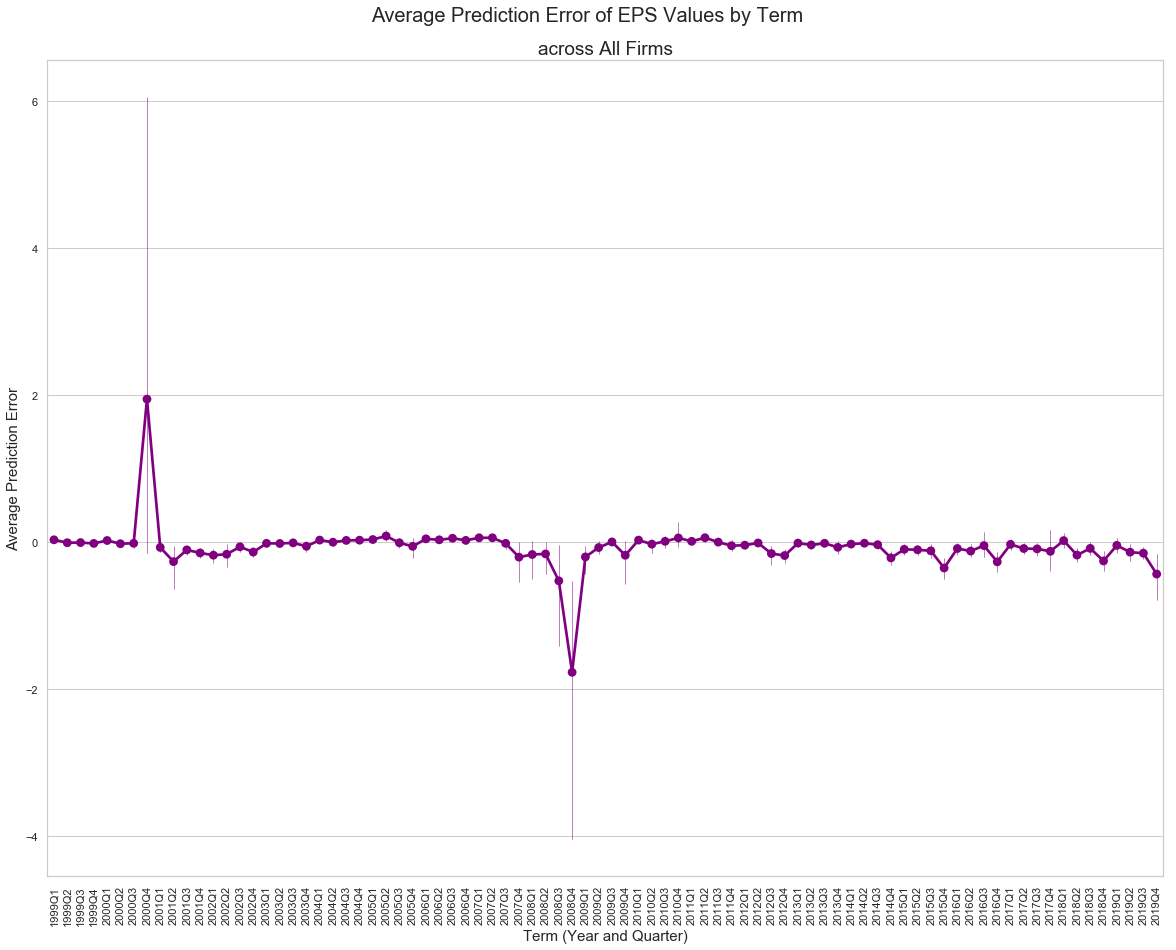

In [76]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = 'term', y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Term', size = 20, y = .93)
plt.title('across All Firms', size = 19)
plt.xticks(rotation = 'vertical')
plt.xlabel('Term (Year and Quarter)')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-term.png')
plt.show();

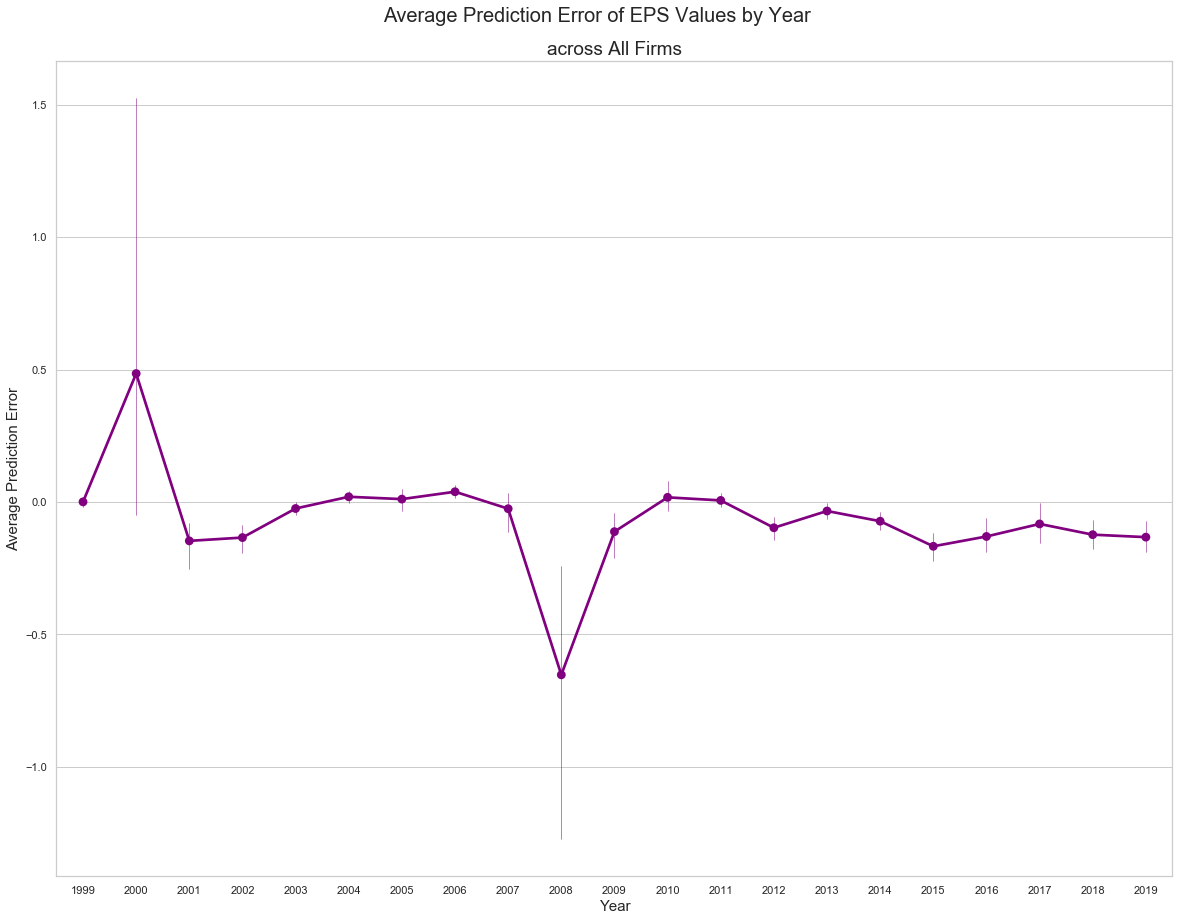

In [77]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.year, y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Year', size = 20, y = .93)
plt.title('across All Firms', size = 19)
# plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-year.png')
plt.show();

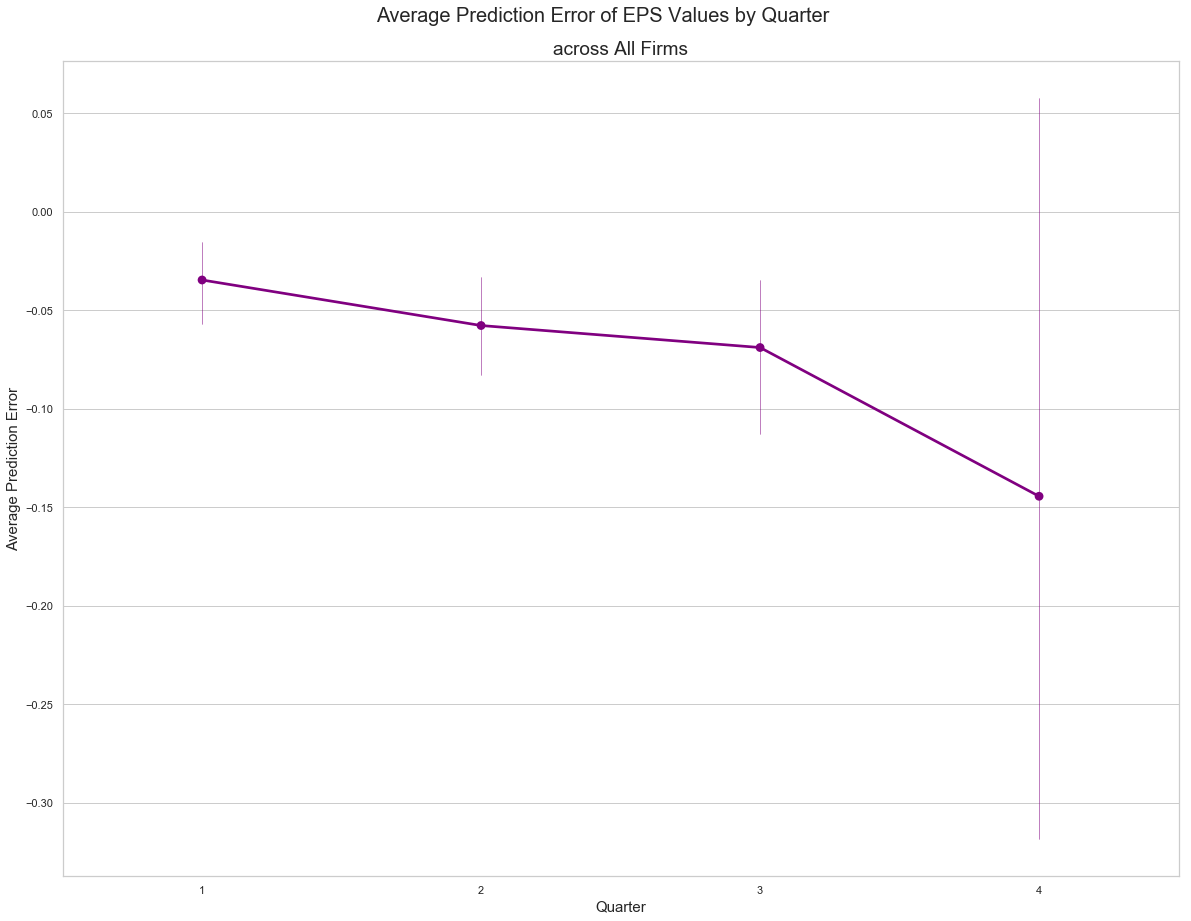

In [78]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.quarter, y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Quarter', size = 20, y = .93)
plt.title('across All Firms', size = 19)
# plt.xticks(rotation = 'vertical')
plt.xlabel('Quarter')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-quarter.png')
plt.show();

### DIFFERENCE IN MOVING AVERAGE FORECASTED AND ACTUAL EPS (PREDICTION ERROR) BY TERM

In [79]:
#3-year moving averages
act_fc_diffs['ma_difference'] = act_fc_diffs.difference.rolling(12).mean()

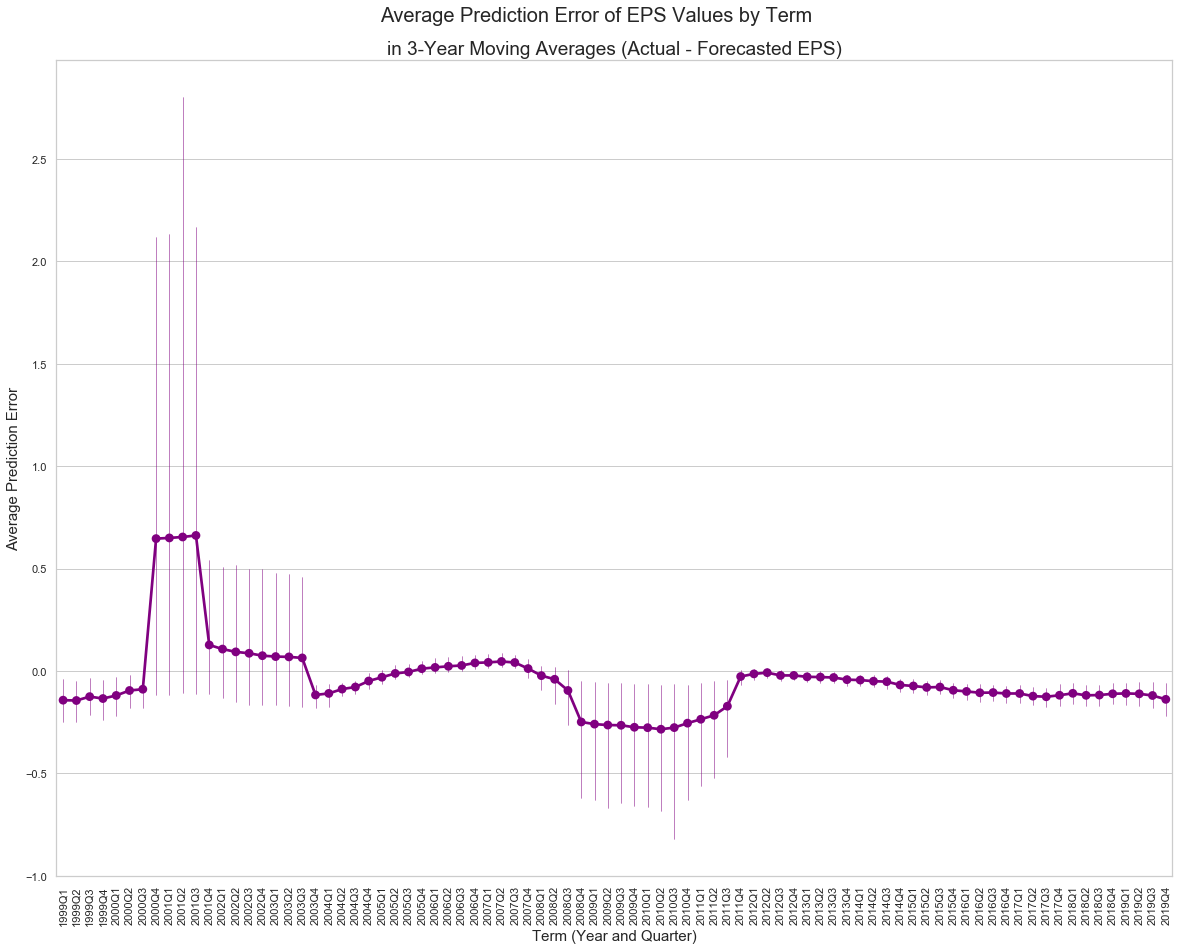

In [80]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = 'term', y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Term', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xticks(rotation = 'vertical')
plt.xlabel('Term (Year and Quarter)')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-term-ma.png')
plt.show();

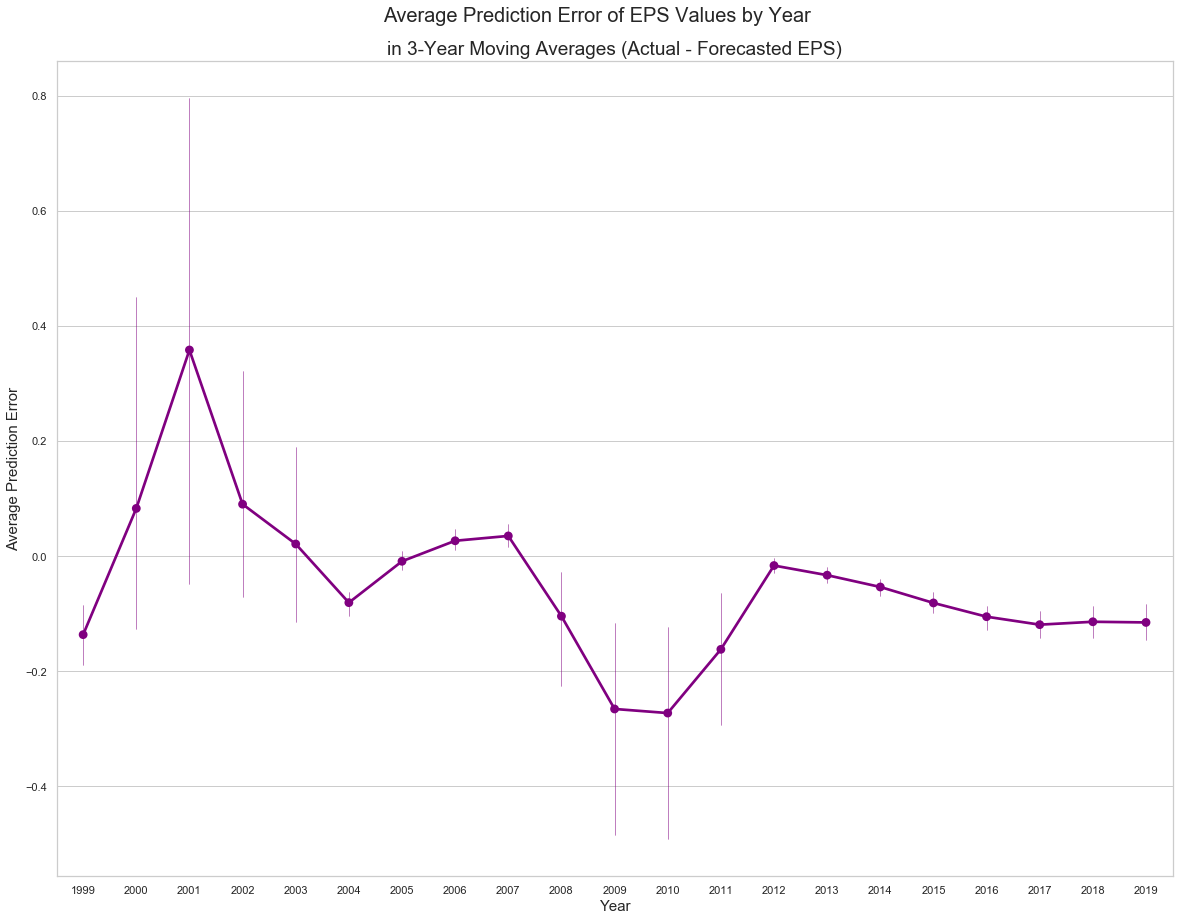

In [81]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.year, y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Year', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xlabel('Year')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-year-ma.png')
plt.show();

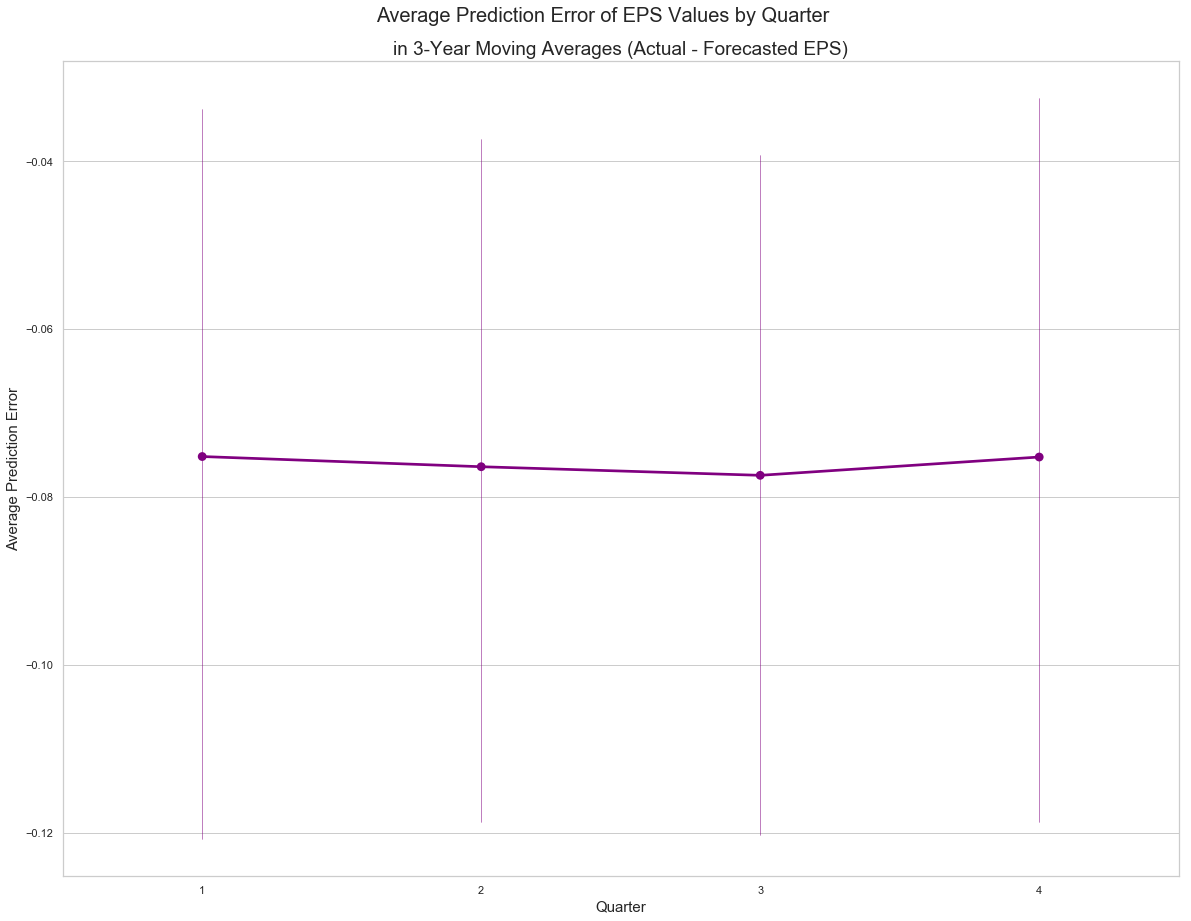

In [82]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.quarter, y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Quarter', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xlabel('Quarter')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-quarter-ma.png')
plt.show();

### DIFFERENCE IN TWENTY YEAR AVERAGE OF EPS_FC AND EPS_ACT BY FIRM (Averages)

In [83]:
#array of all firm ids
ids = firm_ids.firm_id.values

In [84]:
#put eps_fc and eps_act averages into separate DFs
avgs_eps_fc = avgs[avgs['feature'] == 'eps_fc']
avgs_eps_act = avgs[avgs['feature'] == 'eps_act']

In [85]:
#isolate eps_fc and eps_act DFs by "twenty_year" average type
avgs_eps_fc_twenty = avgs_eps_fc[avgs_eps_fc['average_type'] == 'twenty_year']
avgs_eps_act_twenty = avgs_eps_act[avgs_eps_act['average_type'] == 'twenty_year']

In [86]:
#df of only twenty-year average types
avgs_twenty = pd.concat([avgs_eps_fc_twenty, avgs_eps_act_twenty])

In [87]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_twenty = avgs_twenty.query('feature == "eps_fc"').average.values
avg_eps_act_twenty = avgs_twenty.query('feature == "eps_act"').average.values
twenty_diff_data = list(zip(ids, avg_eps_fc_twenty, avg_eps_act_twenty))

twenty_diffs = pd.DataFrame(twenty_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
twenty_diffs['difference'] = twenty_diffs['average_eps_act'] - twenty_diffs['average_eps_fc']
twenty_diffs['average_type'] = 'twenty_year'

In [88]:
twenty_diffs.sample(5)

firm_id  average_eps_fc  average_eps_act  difference average_type
469      469        0.939905         0.968334    0.028429  twenty_year
158      158        0.854072         0.880361    0.026289  twenty_year
198      198        0.380254         0.182093   -0.198161  twenty_year
238      238        0.701274         0.638290   -0.062984  twenty_year
265      265        0.317333         0.116044   -0.201289  twenty_year

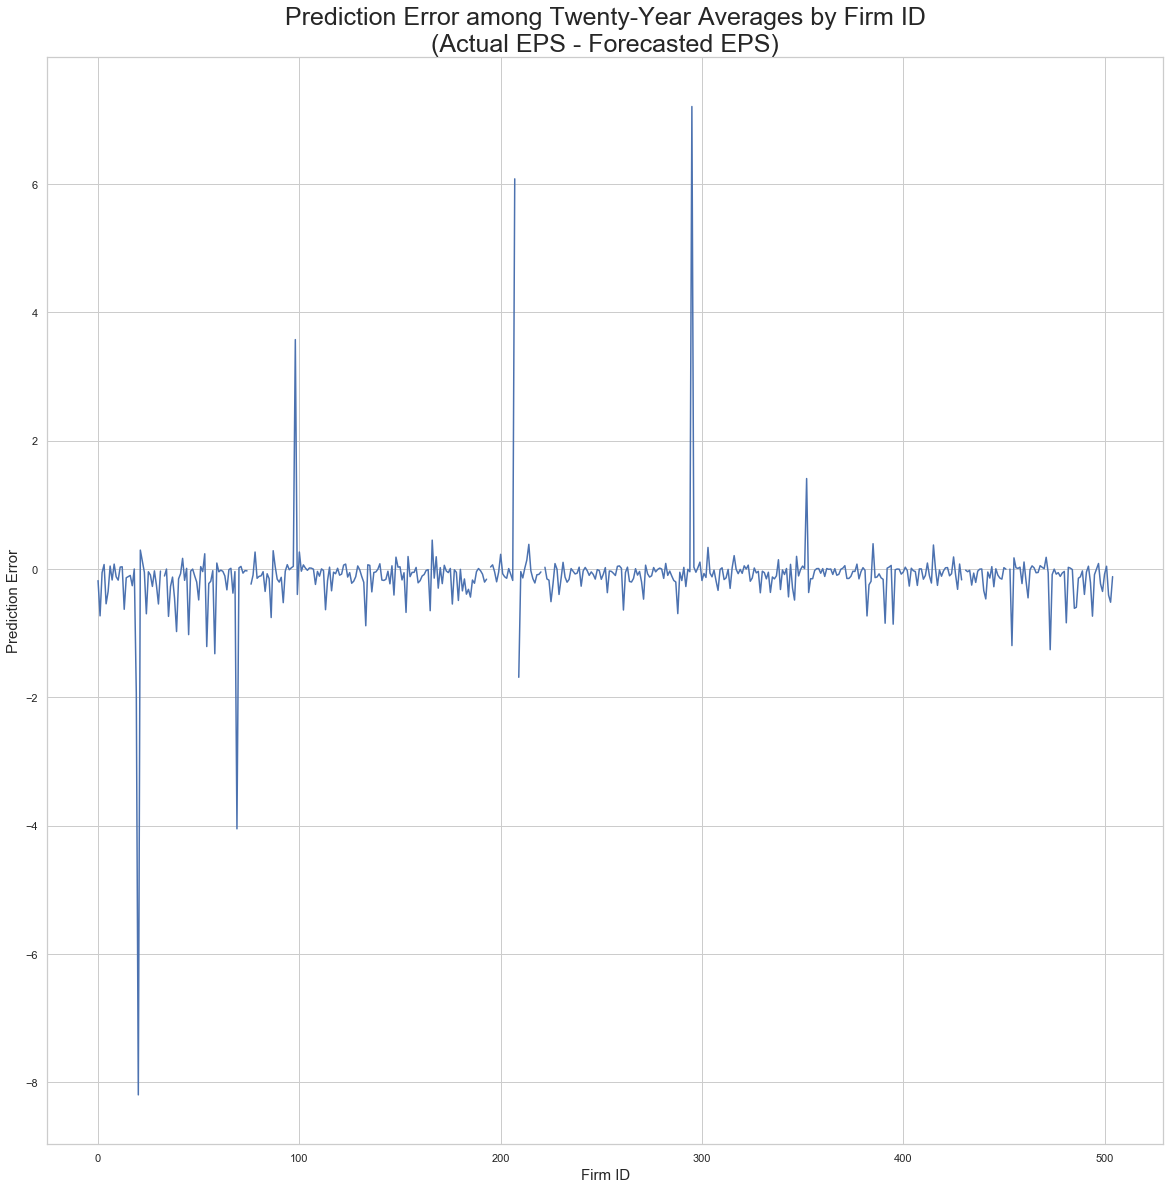

In [89]:
plt.figure(figsize = [20, 20])
plt.title('Prediction Error among Twenty-Year Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
plt.plot(twenty_diffs['firm_id'], twenty_diffs['difference'])

plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year.png')
plt.show();

### DIFFERENCE IN QUARTERLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [90]:
#isolate eps_fc and eps_act DFs by "quarterly" average type
avgs_eps_fc_quarter = avgs_eps_fc[avgs_eps_fc['average_type'] == 'quarterly']
avgs_eps_act_quarter = avgs_eps_act[avgs_eps_act['average_type'] == 'quarterly']

In [91]:
#df of only quarterly averages
avgs_quarter = pd.concat([avgs_eps_fc_quarter, avgs_eps_act_quarter])

In [92]:
#get the average average separately per firm
avgs_quarter_sep = avgs_quarter.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_quarter_sep.shape[0]

1010

In [93]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_quarter = avgs_quarter_sep.query('feature == "eps_fc"').average.values
avg_eps_act_quarter = avgs_quarter_sep.query('feature == "eps_act"').average.values

quarter_diff_data = list(zip(ids, avg_eps_fc_quarter, avg_eps_act_quarter))

quarter_diffs = pd.DataFrame(quarter_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
quarter_diffs['difference'] = quarter_diffs['average_eps_act'] - quarter_diffs['average_eps_fc']
quarter_diffs['average_type'] = 'quarter'

In [94]:
quarter_diffs.head()

firm_id  average_eps_fc  average_eps_act  difference average_type
0        0        0.530992         0.350250   -0.180742      quarter
1        1        0.338961        -0.394274   -0.733235      quarter
2        2        1.054504         0.986728   -0.067777      quarter
3        3        0.873143         0.944501    0.071358      quarter
4        4        1.319607         0.762376   -0.557231      quarter

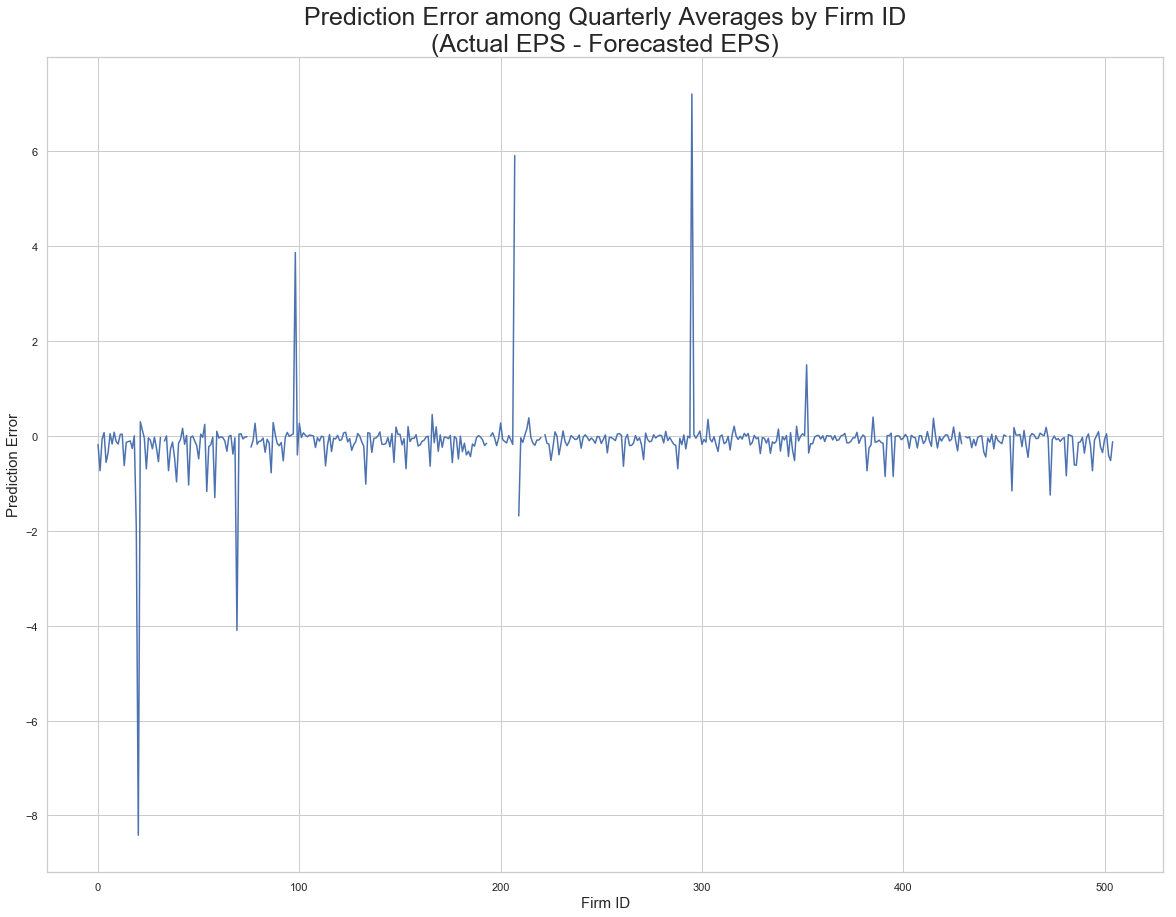

In [95]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among Quarterly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
plt.plot(quarter_diffs['firm_id'], quarter_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter.png')
plt.show();

### DIFFERENCE IN YEARLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [96]:
#isolate eps_fc and eps_act DFs by "yearly" average type
avgs_eps_fc_year = avgs_eps_fc[avgs_eps_fc['average_type'] == 'yearly']
avgs_eps_act_year = avgs_eps_act[avgs_eps_act['average_type'] == 'yearly']

In [97]:
#df of only yearly averages
avgs_year = pd.concat([avgs_eps_fc_year, avgs_eps_act_year])

In [98]:
#get the average average separately per firm
avgs_year_sep = avgs_year.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_year_sep.sample(5)

firm_id  feature   average
271      135   eps_fc  1.030417
481      240   eps_fc  2.398333
345      172   eps_fc  0.642083
991      495   eps_fc  0.443631
154       77  eps_act  0.363829

In [99]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_year = avgs_year_sep.query('feature == "eps_fc"').average.values
avg_eps_act_year = avgs_year_sep.query('feature == "eps_act"').average.values

year_diff_data = list(zip(ids, avg_eps_fc_year, avg_eps_act_year))

year_diffs = pd.DataFrame(year_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
year_diffs['difference'] = year_diffs['average_eps_act'] - year_diffs['average_eps_fc']
year_diffs['average_type'] = 'year'

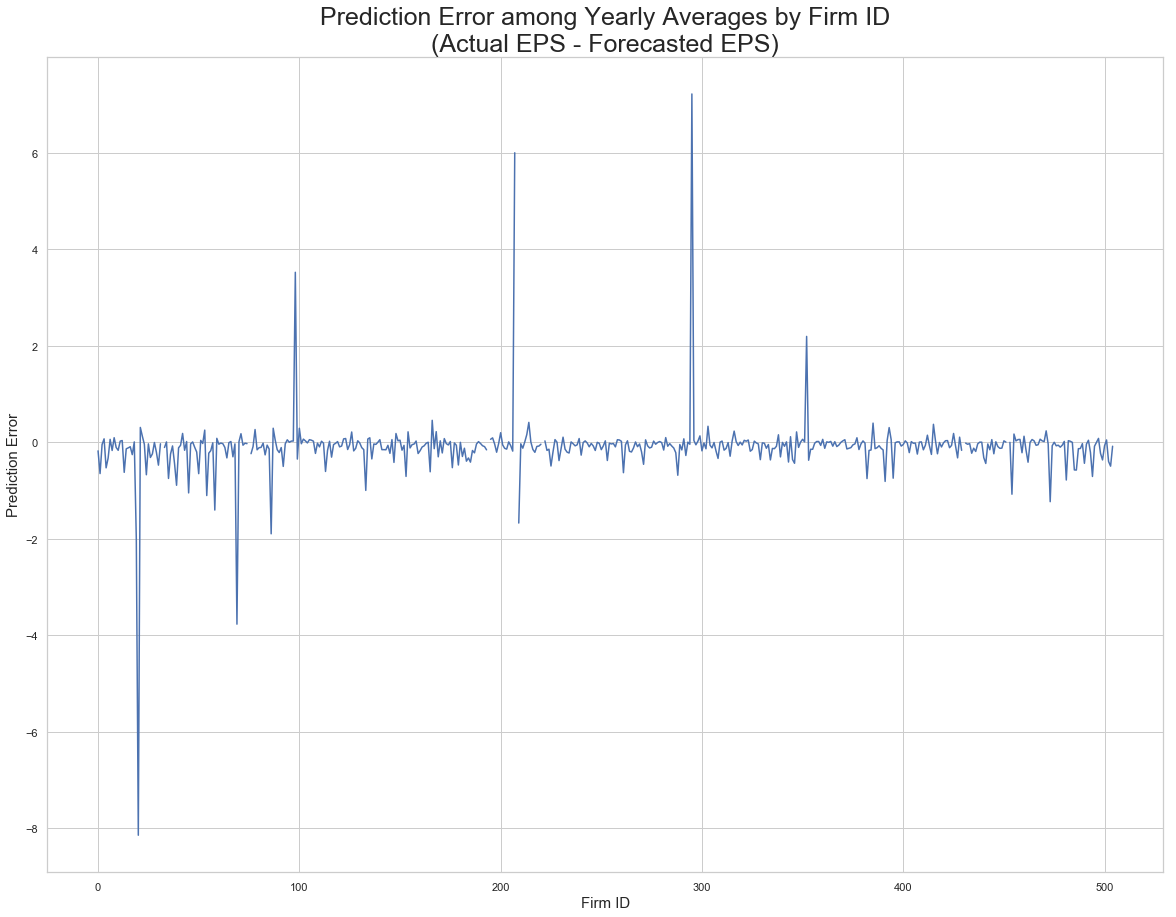

In [100]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among Yearly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
# plt.title('(Average Forecasted EPS - Average Actual EPS)')
# plt.rcParams = plt.rcParamsDefault
plt.plot(year_diffs['firm_id'], year_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-year.png')
plt.show();

- Put all the above graphs into a single FacetGrid for easy accessibility and comparing, in the Multivariate Exploration stage.

In [101]:
#put all yearly, quarterly, and twenty-year differences into one DF
all_diffs = pd.concat([twenty_diffs, quarter_diffs, year_diffs], sort = False)
all_diffs.sample(5)

firm_id  average_eps_fc  average_eps_act  difference average_type
21        21       -0.054846         0.244218    0.299065      quarter
22        22        1.148239         1.276600    0.128361  twenty_year
183      183        0.413905         0.023542   -0.390363  twenty_year
36        36        1.419855         1.148795   -0.271060  twenty_year
90        90        0.893476         0.688314   -0.205162      quarter

- Now that we looked at the raw data, let's create a line plot depicting the ***average difference among all average types.***

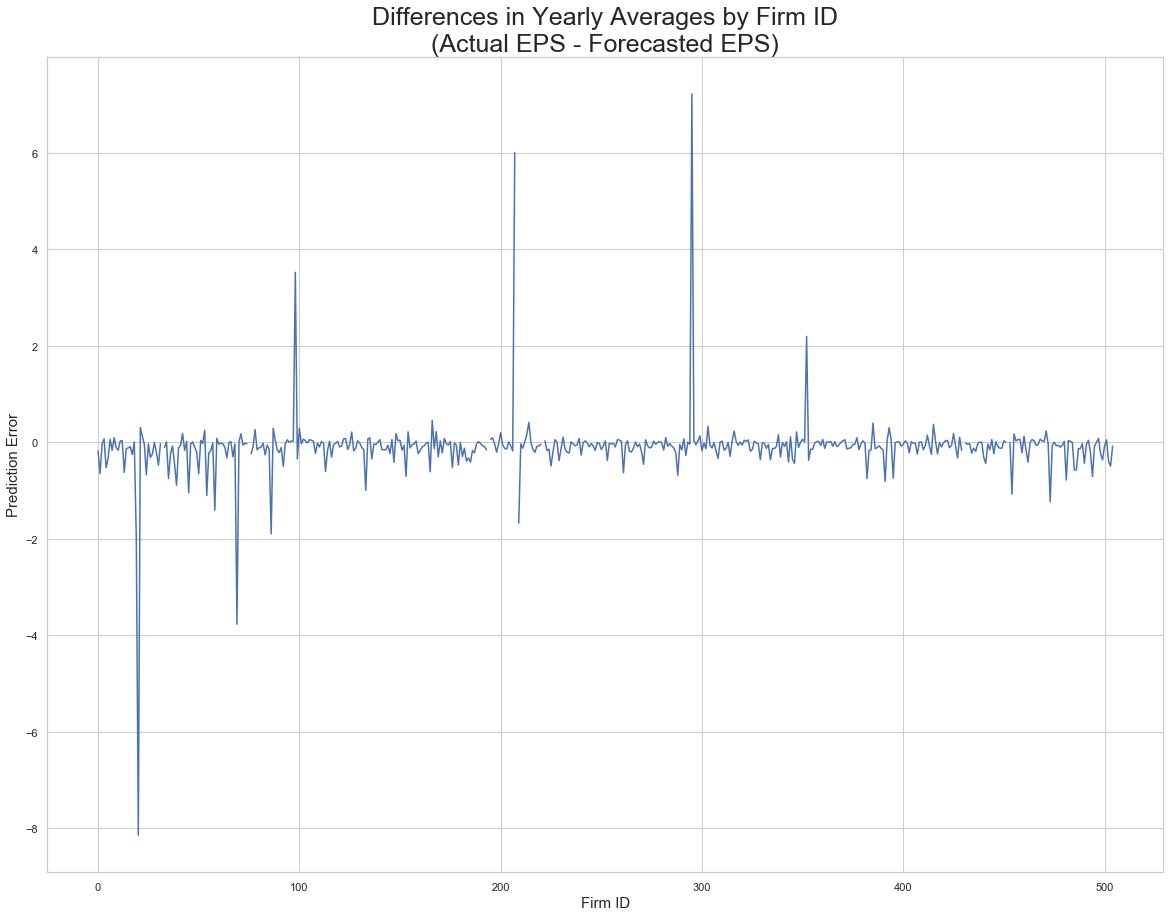

In [102]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Differences in Yearly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
# plt.title('(Average Forecasted EPS - Average Actual EPS)')
# plt.rcParams = plt.rcParamsDefault
plt.plot(year_diffs['firm_id'], year_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-year.png')
plt.show();

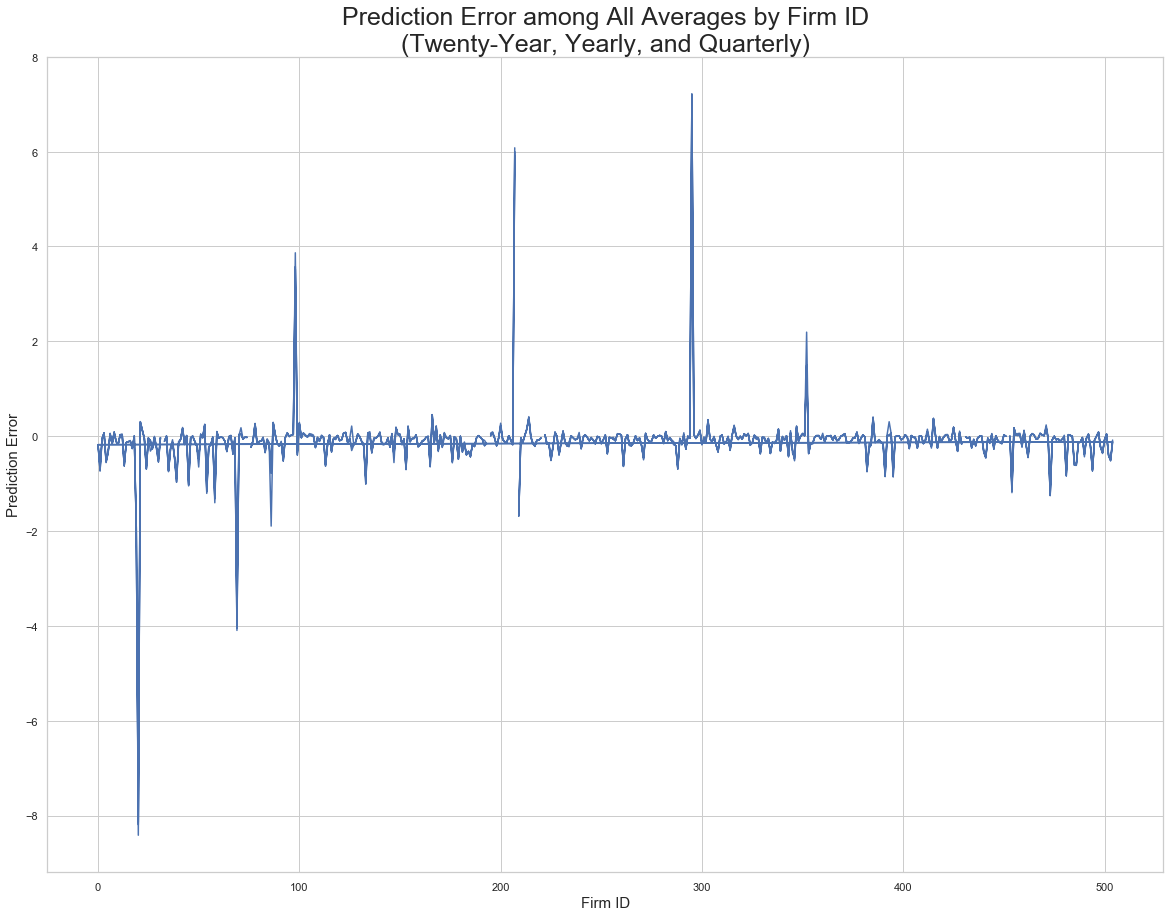

In [103]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among All Averages by Firm ID\n(Twenty-Year, Yearly, and Quarterly)', size = 25)
plt.plot(all_diffs['firm_id'], all_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-all.png')
plt.show();

**Observation:** Since ***all graphs depicting the average differences of forecasted and actual EPS, it is safe to use the `all_diffs` DF*** to answer for the yearly, quarterly, and twenty-year interpretations.

### Approach: Isolate the top 20 firms with the *largest absolute differences* (most inaccurate) and the top 20 firms with the *smallest absolute differences* (most accurate)

In [104]:
#helper function to convert a DF for firm_ids to their ticks
def convert_ids_to_ticks(series):
    series = series.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values
    return [x.upper() for x in series]

In [105]:
#add column for absolute difference
all_diffs['difference_abs'] = all_diffs['difference'].abs()

In [106]:
#create column referring to firm tick
all_diffs['firm_tick'] = convert_ids_to_ticks(all_diffs.firm_id)

In [107]:
#rename column and values to fit legend
all_diffs.average_type = all_diffs.average_type.str.replace('_', ' ').str.capitalize()
all_diffs = all_diffs.rename(columns = {'average_type' : 'Average Type'})

**Twenty-Year**

In [108]:
#isolate twenty-year average type
twenty_diffs = all_diffs[all_diffs['Average Type'] == 'Twenty year']

In [109]:
#reorder firms by absolute difference
twenty_diffs_top = twenty_diffs.sort_values(by='difference_abs', ascending = False)
twenty_diffs_bottom = twenty_diffs.sort_values(by='difference_abs', ascending = True)

In [110]:
#drop rows with duplicate firm ids, get top 20 firm ids
twenty_diffs_top = twenty_diffs_top.drop_duplicates(subset = 'firm_id', keep = 'first').head(20)
twenty_diffs_bottom = twenty_diffs_bottom.drop_duplicates(subset = 'firm_id', keep = 'first').head(20)

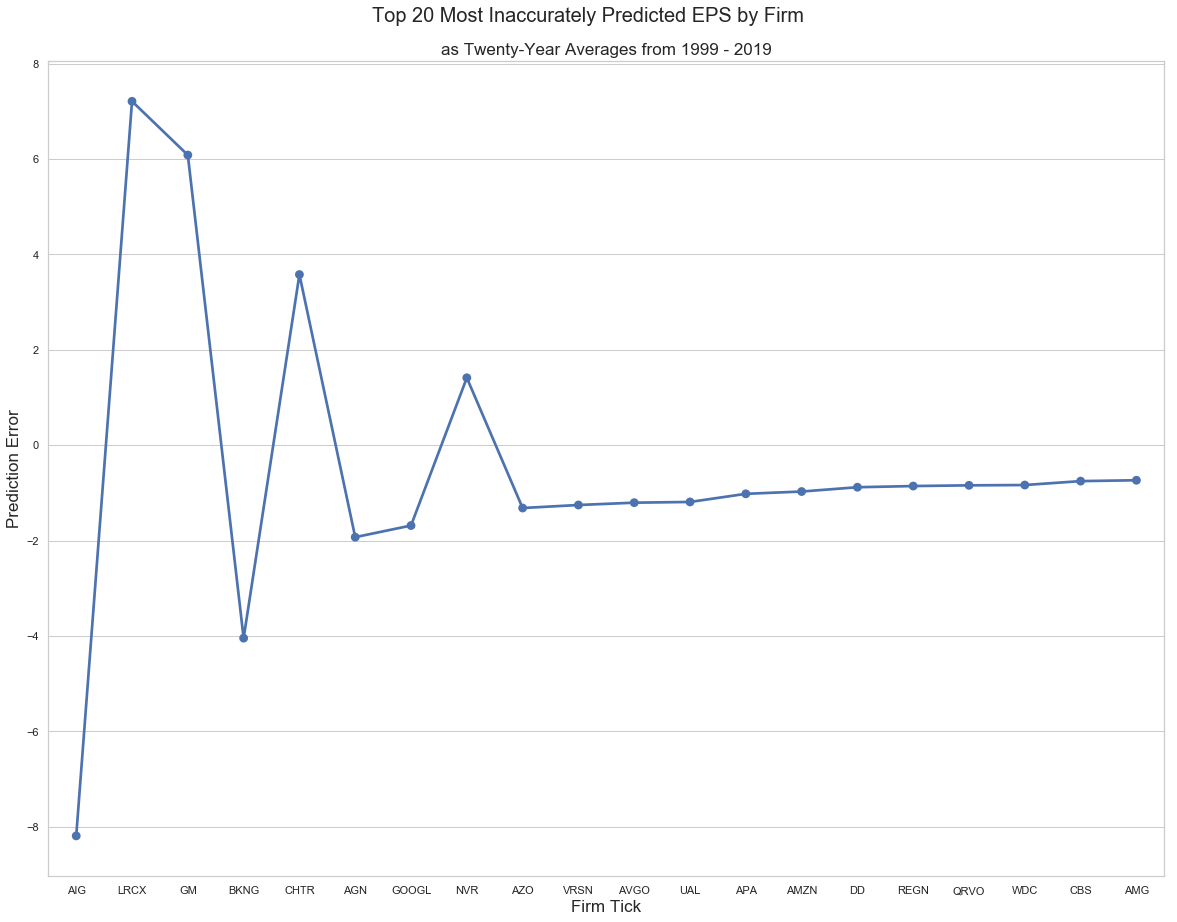

In [143]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = twenty_diffs_top.firm_tick, y = twenty_diffs_top.difference)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Twenty-Year Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-top.png')

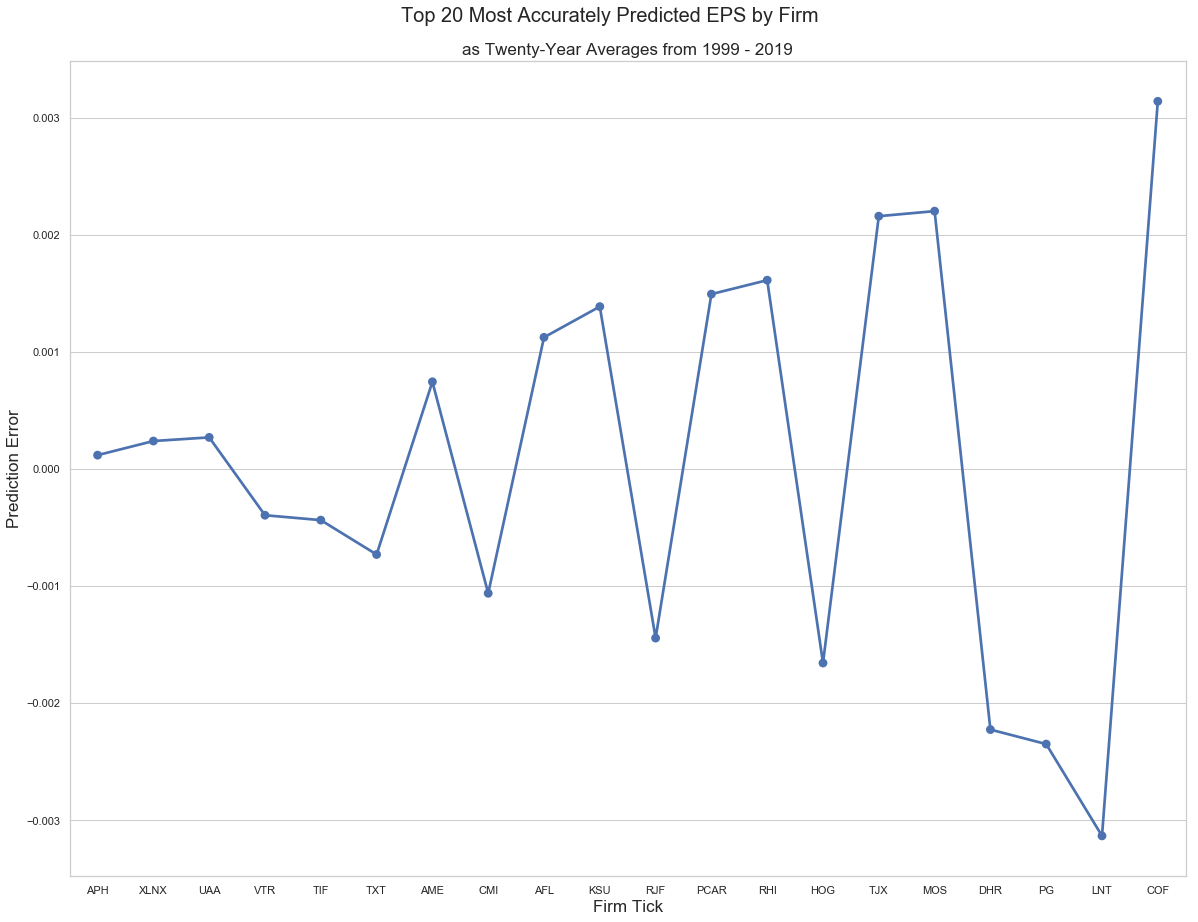

In [142]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = twenty_diffs_bottom.firm_tick, y = twenty_diffs_bottom.difference)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Twenty-Year Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-bottom.png')

**Quarterly**

In [113]:
#isolate twenty-year average type
quarter_diffs = all_diffs[all_diffs['Average Type'] == 'Quarter']

In [114]:
#create temp DF to get absolute mean difference of all firms
quarter_diffs_means = quarter_diffs.groupby('firm_tick').mean().reset_index()

In [115]:
#get firm ticks of top/bottom 20 firms
quarter_diffs_top_ids = quarter_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
quarter_diffs_bottom_ids = quarter_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [116]:
#filter quarterly DF for top/bottom firm ticks
quarter_diffs_top = quarter_diffs[quarter_diffs.firm_tick.isin(quarter_diffs_top_ids)]
quarter_diffs_bottom = quarter_diffs[quarter_diffs.firm_tick.isin(quarter_diffs_bottom_ids)]

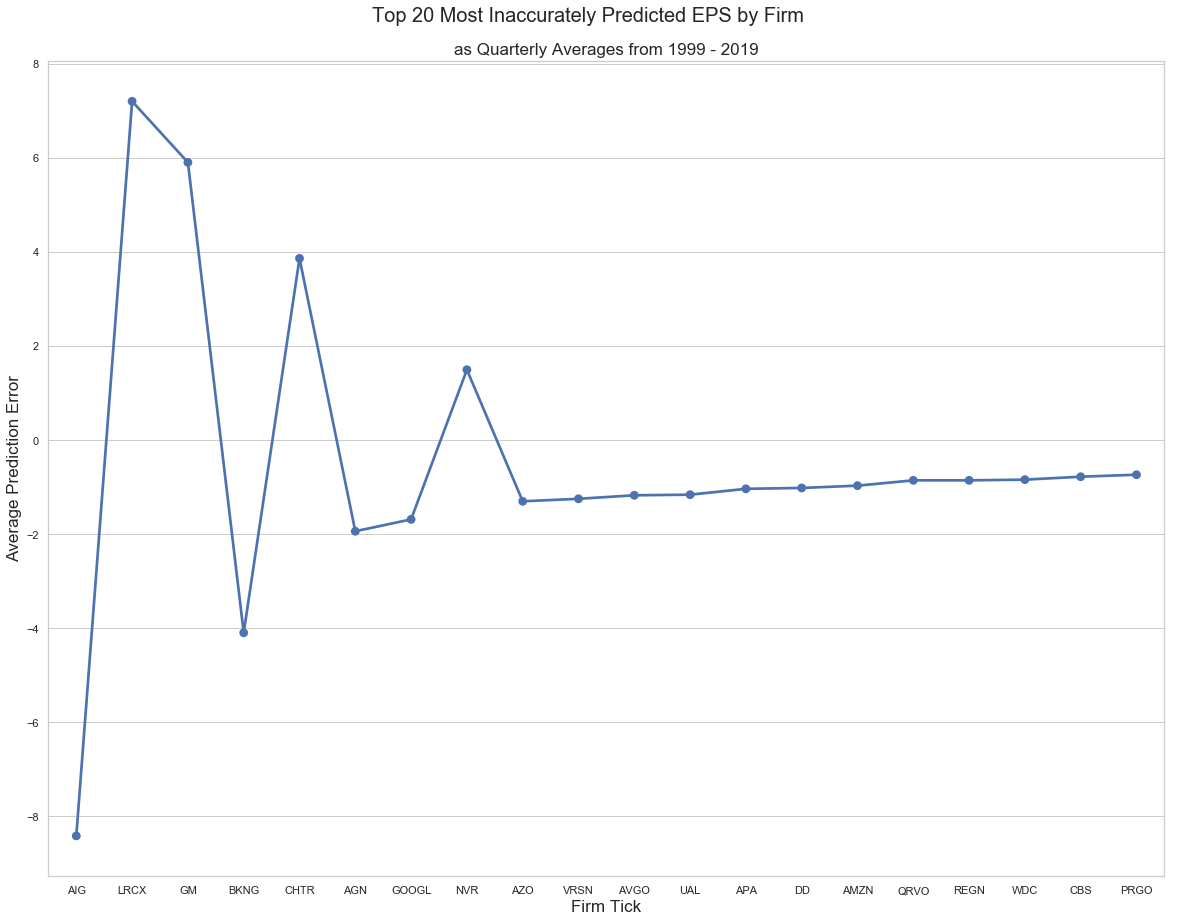

In [141]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = quarter_diffs_top.firm_tick, y = quarter_diffs_top.difference, order = quarter_diffs_top_ids)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Quarterly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-top.png')

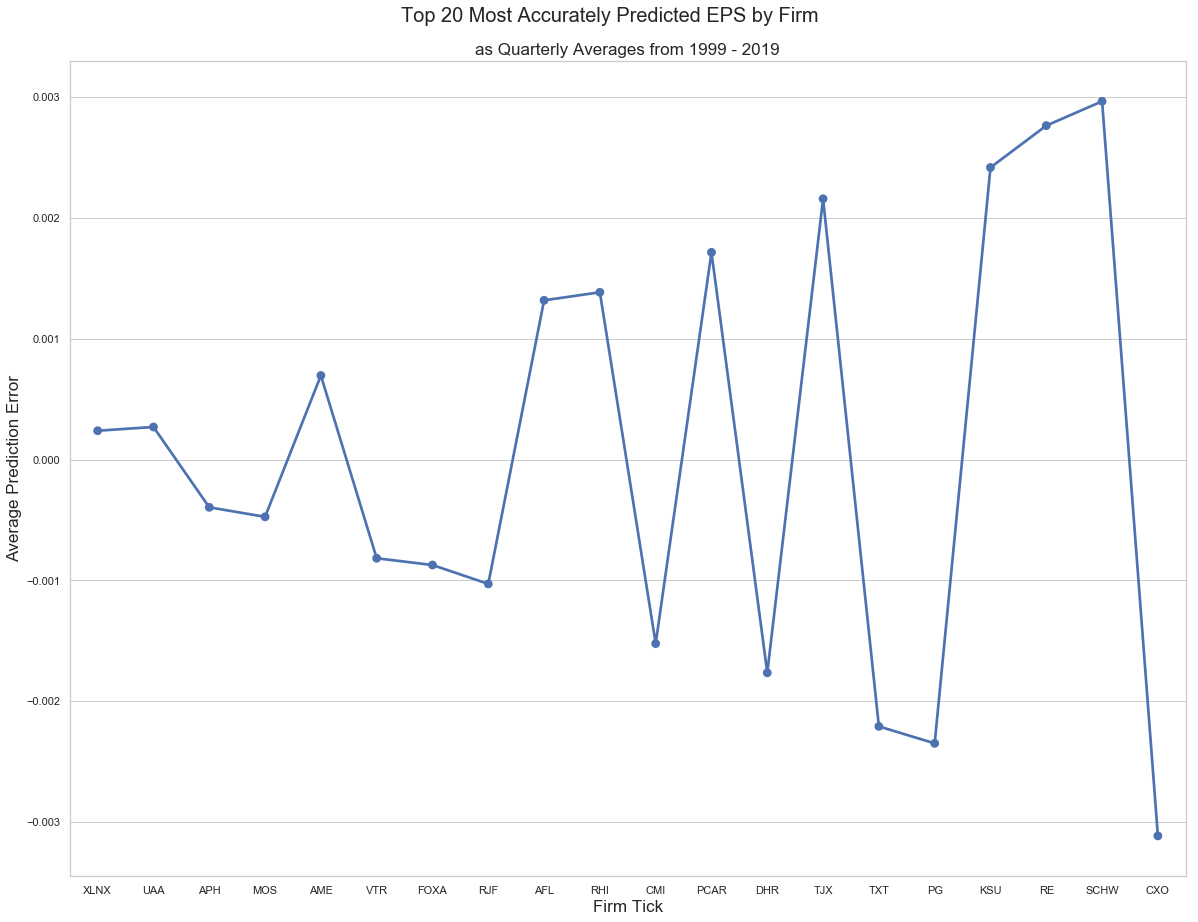

In [118]:
#plot firm IDs as CATEGORICAL variables by their respective quarterly differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = quarter_diffs_bottom.firm_tick, y = quarter_diffs_bottom.difference, order = quarter_diffs_bottom_ids)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Quarterly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-bottom.png')

**Yearly**

In [119]:
#isolate yearly average types
year_diffs = all_diffs[all_diffs['Average Type'] == 'Year']

In [120]:
#create temp DF to get absolute mean difference for all firms
year_diffs_means = year_diffs.groupby('firm_tick').mean().reset_index()

In [121]:
#get firm ticks of top/bottom 20 firms
year_diffs_top_ids = year_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
year_diffs_bottom_ids = year_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [122]:
#filter yearly DF for top/bottom firm ticks
year_diffs_top = year_diffs[year_diffs.firm_tick.isin(year_diffs_top_ids)]
year_diffs_bottom = year_diffs[year_diffs.firm_tick.isin(year_diffs_bottom_ids)]

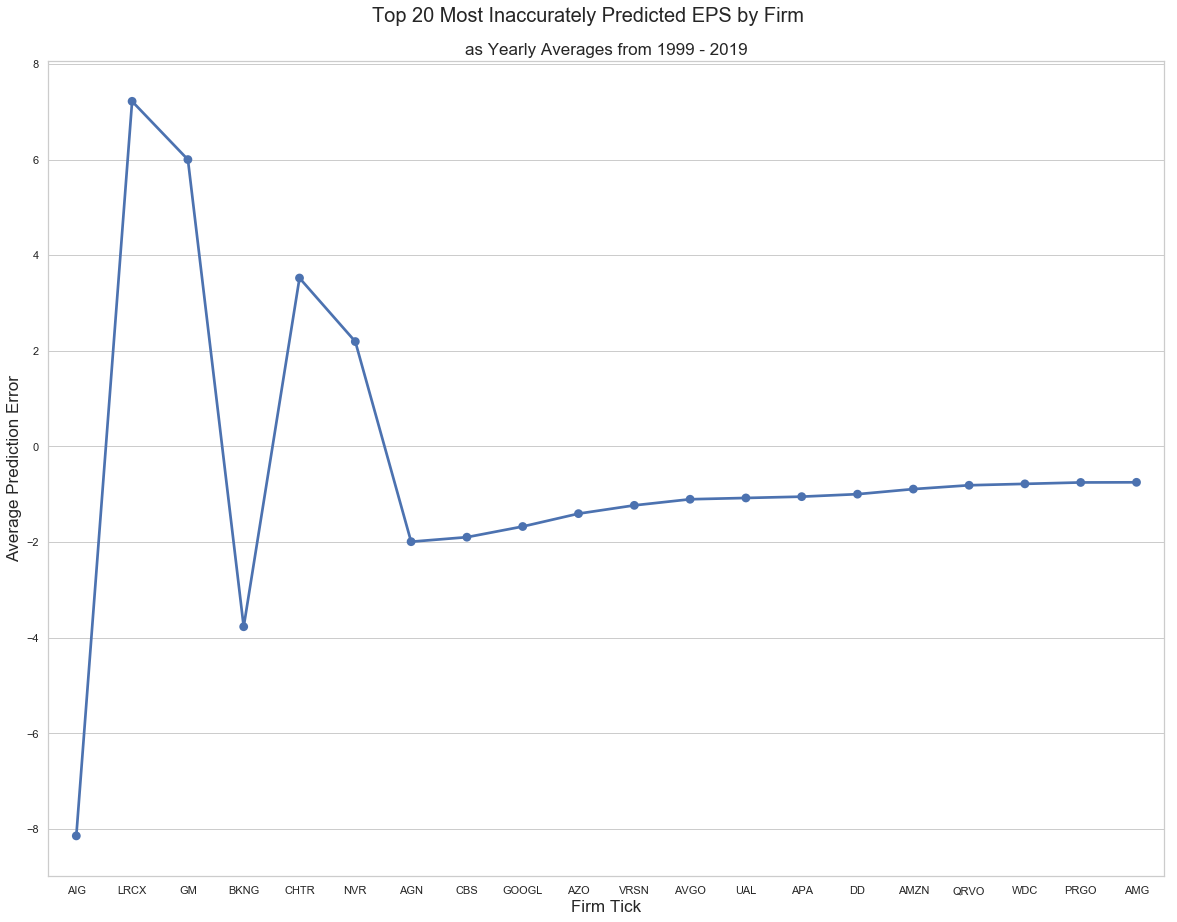

In [123]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = year_diffs_top.firm_tick, y = year_diffs_top.difference, order = year_diffs_top_ids)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Yearly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-top.png')

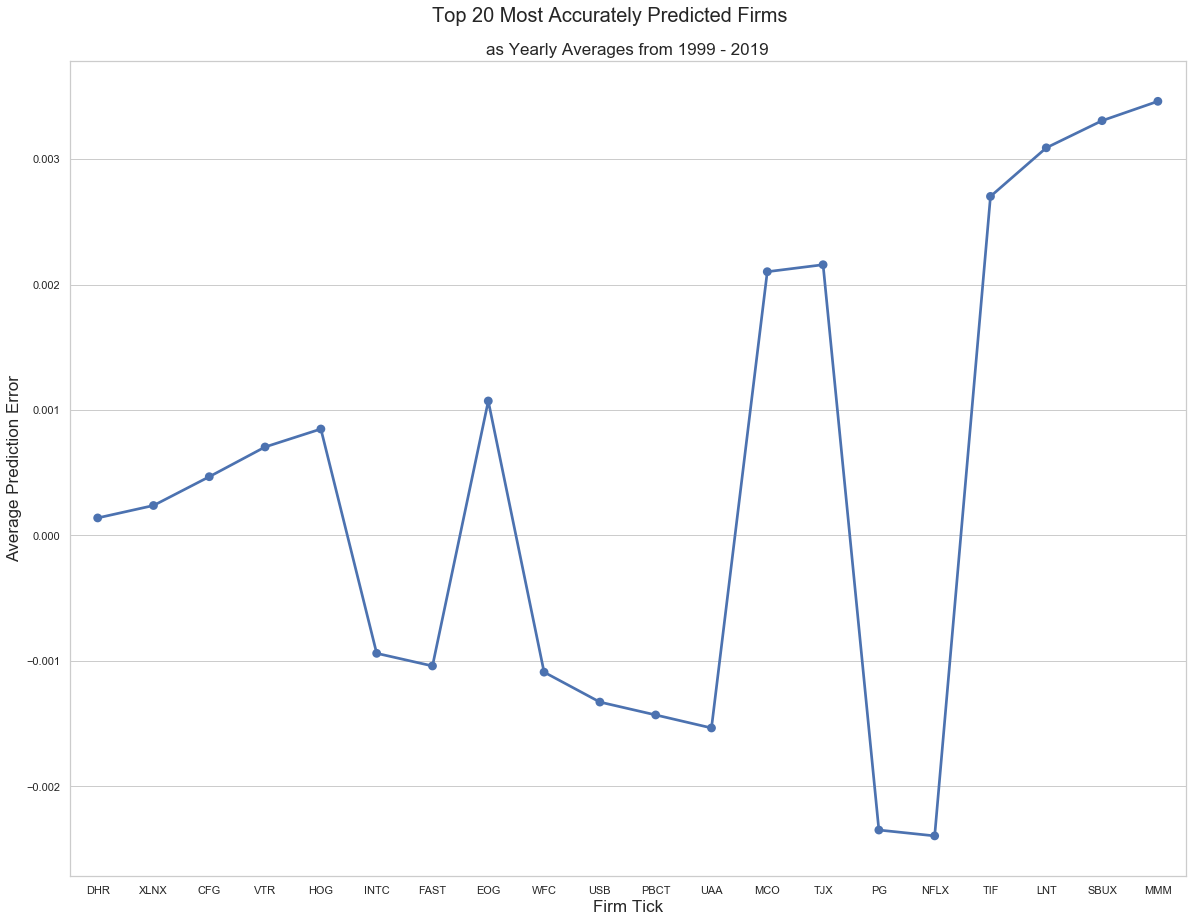

In [124]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = year_diffs_bottom.firm_tick, y = year_diffs_bottom.difference, order = year_diffs_bottom_ids)

plt.suptitle('Top 20 Most Accurately Predicted Firms', size = 20, y = .93)
plt.title('as Yearly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-bottom.png')

**Twenty-Year, Quarterly, and Yearly**

> Main question: How do firms differ by forecast inaccuracy by average type (yearly, quarterly, and yearly)?

**Steps:**

1) Calculate the *average yearly, quarterly, and twenty-difference* for each firm.

2) Convert the new average differences to their absolute value.

3) Isolate the top 20 and bottom 20 firms by their average absolute distances.

4) Convert Firm IDs to Firm Ticks

5) Use those firm ticks to create a visualization using 2 different datasets:
- the `avgs` DF (all raw data)
- the `all_diffs` DF (filtered data)

In [125]:
#calculate average difference for all average types
all_diffs_means = all_diffs.groupby('firm_tick').mean().reset_index()

In [126]:
#get firm ticks of top/bottom 20 firms
all_diffs_top_ids = all_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
all_diffs_bottom_ids = all_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [127]:
#filter DF for top/bottom firm ticks
all_diffs_top = all_diffs[all_diffs.firm_tick.isin(all_diffs_top_ids)]
all_diffs_bottom = all_diffs[all_diffs.firm_tick.isin(all_diffs_bottom_ids)]

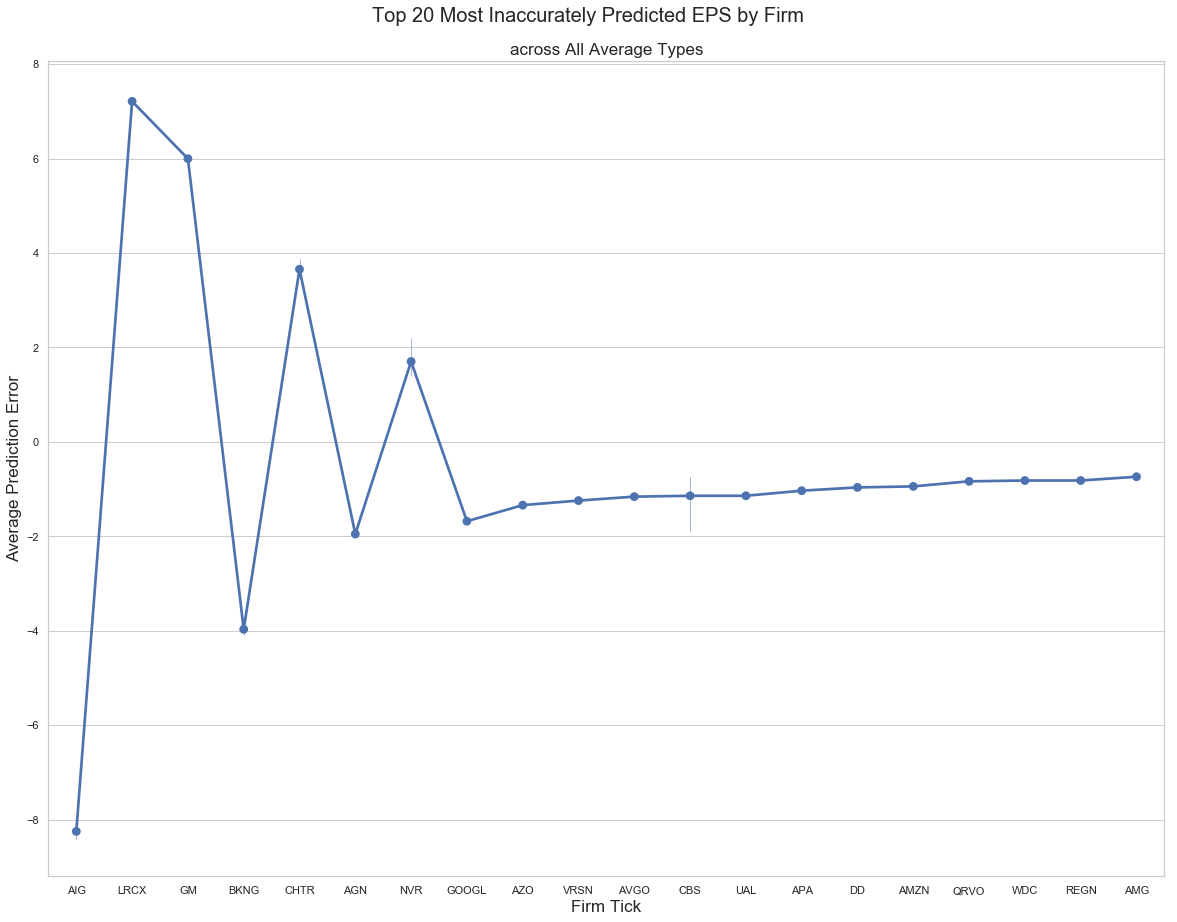

In [128]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = all_diffs_top.firm_tick, y = all_diffs_top.difference, order = all_diffs_top_ids, errwidth = 0.5)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('across All Average Types', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-top.png')

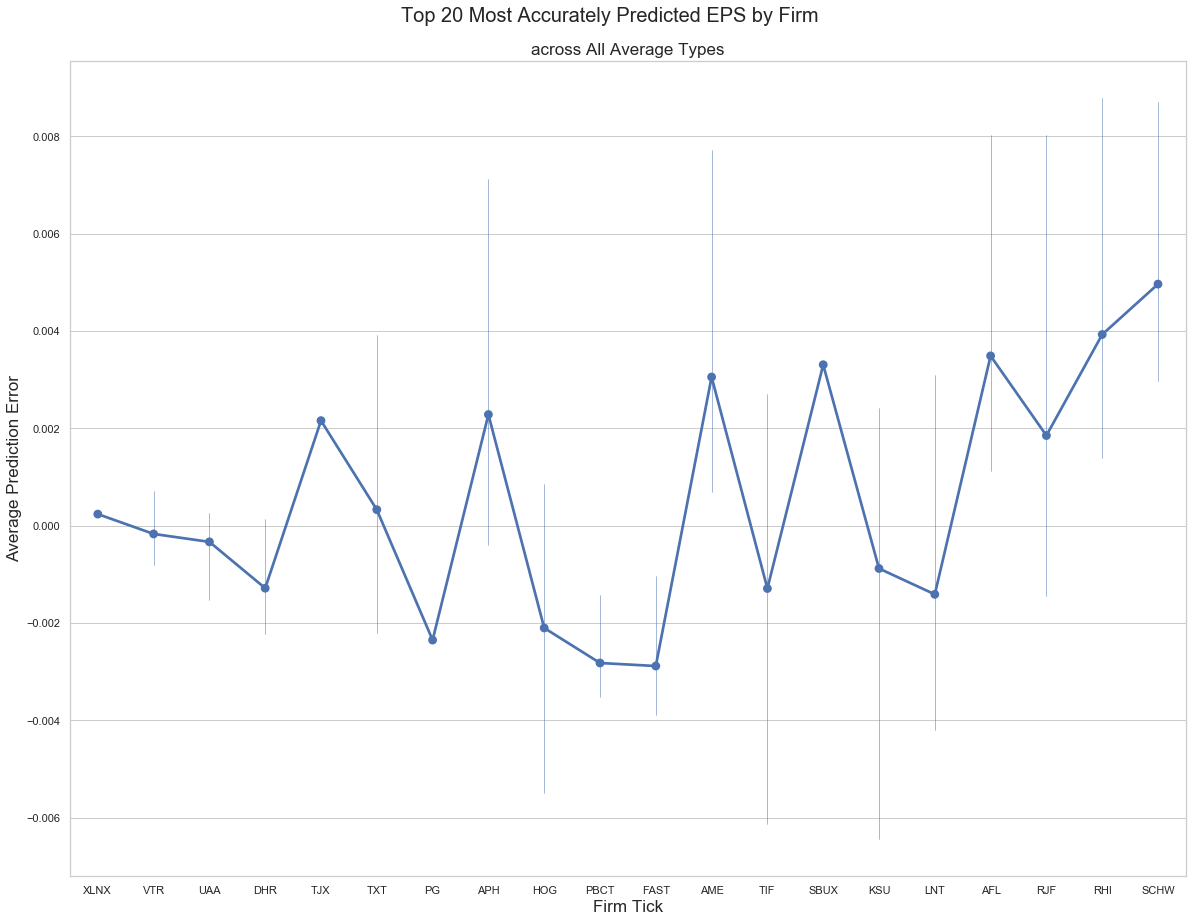

In [129]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = all_diffs_bottom.firm_tick, y = all_diffs_bottom.difference, order = all_diffs_bottom_ids, errwidth = 0.5)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('across All Average Types', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-bottom.png')

### Linear Regression Test for all EPS_ACT AVERAGES  vs. EPS_FC AVERAGES

> Considering that it's impossible to visually conclude a skew or distribution from the graphics alone, can we implement linear regression tests to verify that the relationship between forecasted and actual EPS is statistically significant?



For all linear regression tests, I will ***use the non-absolute values*** of the differences. This is because using a linear regression model on raw, unfiltered data will give more precise results.

H0: The higher the forecasted value, the higher the actual value.

H1: The higher the forecasted value, the lower or equal the actual value.

In [144]:
def implement_ols(df, y, x, avg_type):
    lm = sm.OLS(df[y], df[['intercept', x]], missing = 'drop')
    result = lm.fit()
    
    p_val = result.pvalues[x]
    coeff = result.params[x]
    r = math.sqrt(result.rsquared)
    
    return (result.summary(), avg_type, p_val, coeff, r)

**Isolate Twenty-Year EPS data by firm to fit OLS model**

In [145]:
#helper function to separate eps_act and eps_fc averages into their own columns
def separate_eps_fc_act(df, groupby_arr, value_col):
    #combine eps_fc and eps_act averages into a single column, joined on firm id and time period
    df1 = df.groupby(groupby_arr)[value_col].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    
    #separate eps_fc and eps_act averages then rename columns
    df1 = pd.concat([df1[groupby_arr], df1[value_col].str.split(', ', expand = True)], axis = 1)
    df1.rename(columns = {0: 'eps_fc', 1: 'eps_act'}, inplace = True)
    
    #convert data types
    df1 = df1.astype({'eps_fc' : 'float64', 'eps_act' : 'float64'})
    
    #add intercept
    df1['intercept'] = 1
    
    return df1

In [146]:
avgs_twenty_ols = separate_eps_fc_act(avgs_twenty, ['firm_id', 'average_type'], 'average')
avgs_twenty_ols.sample(10)

firm_id average_type    eps_fc   eps_act  intercept
481      481  twenty_year  1.356684  0.519881          1
287      287  twenty_year  0.815134  0.614344          1
57        57  twenty_year  0.925940  0.901246          1
113      113  twenty_year  1.437373  0.804578          1
234      234  twenty_year  0.463456  0.303122          1
478      478  twenty_year  0.968881  0.855211          1
98        98  twenty_year  0.450026  4.026481          1
180      180  twenty_year  0.135333  0.131613          1
462      462  twenty_year  1.080321  0.632175          1
166      166  twenty_year  0.204017  0.655964          1

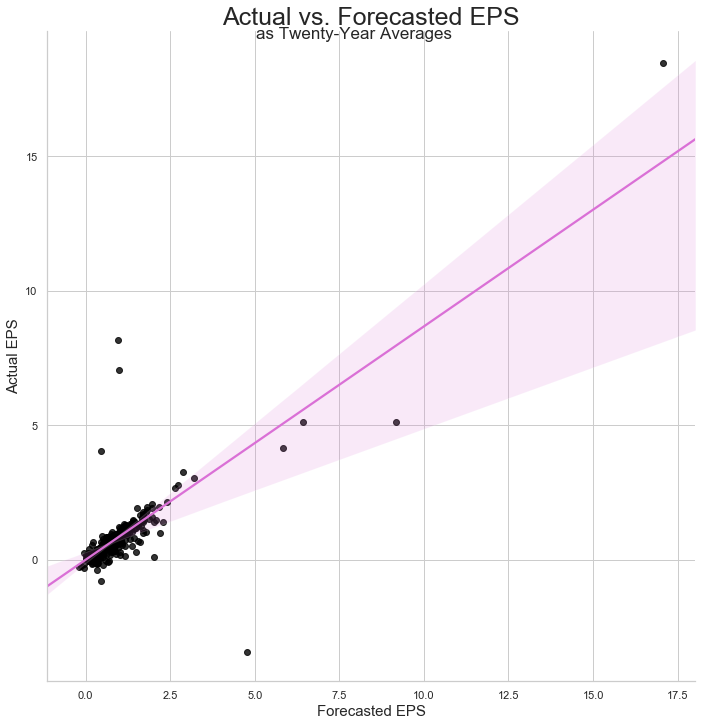

In [147]:
ax = sb.lmplot(data= avgs_twenty_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 25)
plt.suptitle('as Twenty-Year Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-twenty.png')

In [148]:
twenty_ols = implement_ols(avgs_twenty_ols, 'eps_act', 'eps_fc', 'Twenty-Year')
twenty_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     927.1
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          1.33e-115
Time:                        18:16:07   Log-Likelihood:                -491.24
No. Observations:                 498   AIC:                             986.5
Df Residuals:                     496   BIC:                             994.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.037     -0.020      0.984      -0.073       0.072
eps_fc         0.8680      0.029     30.448      0.000       0.812       0.924
==============================================================================
Omnibus:                      366.690   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163395.963
Skew:                           1.937   Prob(JB):                         0.00
Kurtosis:                      91.654   Cond. No.                         2.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Quarterly EPS data by firm to fit OLS model**

In [149]:
avgs_quarter_ols = separate_eps_fc_act(avgs_quarter, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_quarter_ols.sample(10)

firm_id average_type time_period    eps_fc   eps_act  intercept
1272      318    quarterly          q1  0.723238  0.679286          1
904       226    quarterly          q1  2.040444  1.874000          1
388        97    quarterly          q1  0.481095  0.537105          1
1232      308    quarterly          q1  1.234619  0.936667          1
1501      375    quarterly          q2  0.284286  0.312068          1
1874      468    quarterly          q3  0.919643  1.121538          1
1769      442    quarterly          q2  0.665789  0.597313          1
199        49    quarterly          q4  0.680476  0.425639          1
1959      489    quarterly          q4  1.021000  1.010476          1
669       167    quarterly          q2  0.473600  0.330952          1

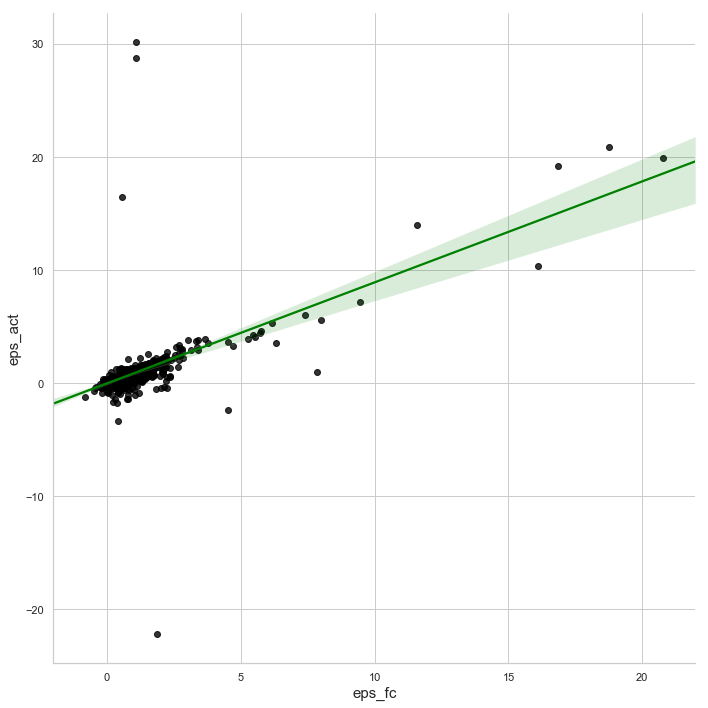

In [150]:
ax = sb.lmplot(data= avgs_quarter_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'green'})

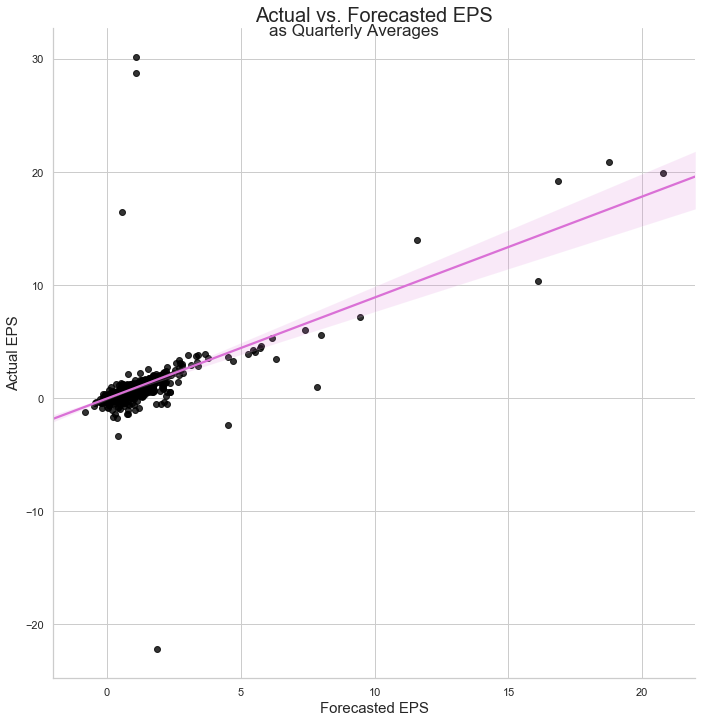

In [151]:
ax = sb.lmplot(data= avgs_quarter_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 20)
plt.suptitle('as Quarterly Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-quarter.png')

In [152]:
quarter_ols = implement_ols(avgs_quarter_ols, 'eps_act', 'eps_fc', 'Quarterly')
quarter_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     1291.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          3.26e-218
Time:                        18:16:08   Log-Likelihood:                -3163.6
No. Observations:                1988   AIC:                             6331.
Df Residuals:                    1986   BIC:                             6342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0228      0.033     -0.684      0.494      -0.088       0.042
eps_fc         0.8937      0.025     35.927      0.000       0.845       0.943
==============================================================================
Omnibus:                     3432.956   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15378611.603
Skew:                          10.939   Prob(JB):                         0.00
Kurtosis:                     433.324   Cond. No.                         2.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Yearly EPS data by firm to fit OLS model**

In [153]:
avgs_year_ols = separate_eps_fc_act(avgs_year, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_year_ols.sample(10)

firm_id average_type time_period   eps_fc  eps_act  intercept
2954      140       yearly        2013  0.75000  0.85500          1
5456      259       yearly        2016  0.56600  0.51250          1
3360      160       yearly        1999  0.49450  0.44775          1
9269      441       yearly        2007  0.20750  0.14500          1
2400      114       yearly        2005  2.18600  2.43125          1
7489      356       yearly        2012  0.24700  0.21500          1
397        18       yearly        2018  0.97375  0.94750          1
9902      471       yearly        2010  0.69250  0.81750          1
6287      299       yearly        2007      NaN      NaN          1
559        26       yearly        2012  0.25200  0.18250          1

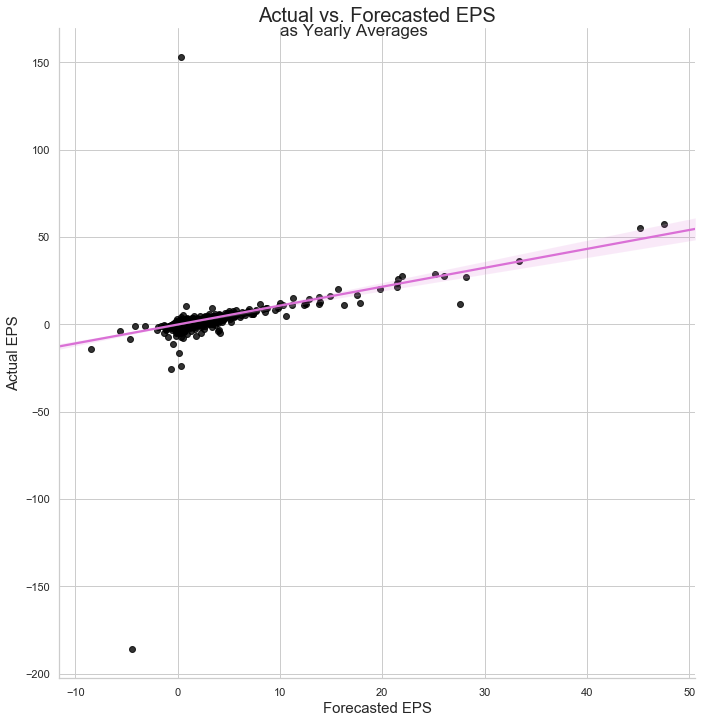

In [154]:
ax = sb.lmplot(data= avgs_year_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 20)
plt.suptitle('as Yearly Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-year.png')

In [155]:
year_ols = implement_ols(avgs_year_ols, 'eps_act', 'eps_fc', 'Yearly')
year_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3147.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:16:12   Log-Likelihood:                -21086.
No. Observations:                8848   AIC:                         4.218e+04
Df Residuals:                    8846   BIC:                         4.219e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1440      0.032     -4.530      0.000      -0.206      -0.082
eps_fc         1.0824      0.019     56.097      0.000       1.045       1.120
==============================================================================
Omnibus:                    17981.094   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5446459294.082
Skew:                         -15.036   Prob(JB):                         0.00
Kurtosis:                    3846.500   Cond. No.                         2.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Raw EPS data by firm to fit OLS model**

In [156]:
features_eps_fc_act = features.loc[features['feature'].isin(['eps_act', 'eps_fc'])]
features_all_ols = separate_eps_fc_act(features_eps_fc_act, ['firm_id', 'term'], 'value')
features_all_ols.sample(10)

firm_id    term  eps_fc  eps_act  intercept
29316      349  1999Q1   0.410    0.425          1
27127      322  2018Q4   0.571    0.290          1
40906      486  2019Q3   1.301    0.580          1
27670      329  2007Q3   0.265    0.210          1
20490      243  2018Q3   1.310    1.390          1
27514      327  2010Q3   0.350    0.090          1
11224      133  2012Q1     NaN      NaN          1
2082        24  2015Q3   0.575    0.490          1
30419      362  2001Q4   0.176    0.170          1
42307      503  2012Q4     NaN    0.190          1

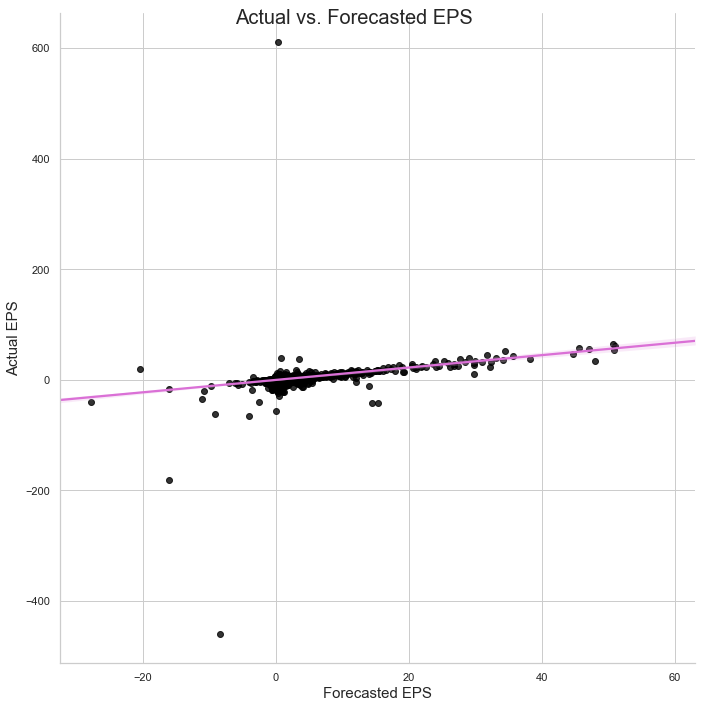

In [157]:
ax = sb.lmplot(data= features_all_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.suptitle('Actual vs. Forecasted EPS', size = 20)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'features-act-fc-all.png')

In [158]:
all_ols = implement_ols(features_all_ols, 'eps_act', 'eps_fc', 'All')
all_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5115.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:                -99603.
No. Observations:               34448   AIC:                         1.992e+05
Df Residuals:                   34446   BIC:                         1.992e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1697      0.027     -6.399      0.000      -0.222      -0.118
eps_fc         1.1196      0.016     71.516      0.000       1.089       1.150
==============================================================================
Omnibus:                   106243.709   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     299298412516.719
Skew:                          45.670   Prob(JB):                         0.00
Kurtosis:                   14442.998   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Examine p-value, coeff, and r-value

In [159]:
#put all ols in an array
ols = [twenty_ols, quarter_ols, year_ols, all_ols]

In [160]:
statement = 'Actual EPS vs Forecasted EPS ({}):\np-value: {:.5f}\ncoefficient: {:.5f}\nr-value: {:.5f}\n'

#display p-value, coeff, and r-values
for ol in ols:
    print(statement.format(ol[1], ol[2], ol[3], ol[4]))

Actual EPS vs Forecasted EPS (Twenty-Year):
p-value: 0.00000
coefficient: 0.86799
r-value: 0.80713

Actual EPS vs Forecasted EPS (Quarterly):
p-value: 0.00000
coefficient: 0.89373
r-value: 0.62762

Actual EPS vs Forecasted EPS (Yearly):
p-value: 0.00000
coefficient: 1.08243
r-value: 0.51224

Actual EPS vs Forecasted EPS (All):
p-value: 0.00000
coefficient: 1.11957
r-value: 0.35956



> Check if the scatterplots are consistent with the results from their linear regression models.

**Observation 1:** The coefficient associated with `average_eps_fc` is 0.8680. This depicts a ***strong positive linear relationship*** between the forecasted and actual twenty-year EPS averages.

**Observation 2:** Let's establish our Type I error rate to be 0.05. The calculated p-value for `average_eps_fc` is 0.00. Since the p-value is less than our error threshold, ***the relationship between the twenty-year forecasted and actual EPS averages is statistically significant.***
> This is evidence in favor of my alternative hypothesis, therefore we ***accept the null hypothesis*** that as the value for forecasted twenty-year average EPS increases, the higher the actual value.



**Observation 1:** Interestingly enough, the graph encompassing the broadest data (all data from features) has the ***most stable 95% confidence interval*** as per the regression line.

**Observation 2:** The quarterly average regression line is the most unstable.

### "Dumb Predictions" vs "Expert Predictions"

1) Create a DF depicting `eps_act` last quarter vs `eps_act` this quarter.

2) Create "dumb predictions" 

3) Compare my predictions to all `eps_fc` values 

In [161]:
#isolate eps_act entries, drop date column
features_dumb_eps = features[features['feature'] == 'eps_act'].loc[:, features.columns != 'date']

In [162]:
#grab previous eps_act term
features_dumb_eps['previous_value'] = features_dumb_eps['value'].shift(1)

features_dumb_eps = features_dumb_eps[['firm_id', 'feature','term', 'value', 'previous_value']]

In [163]:
features_dumb_eps.head()

firm_id  feature    term  value  previous_value
125240        0  eps_act  1999Q1   0.16             NaN
125241        0  eps_act  1999Q2   0.35            0.16
125242        0  eps_act  1999Q3   0.30            0.35
125243        0  eps_act  1999Q4   0.32            0.30
125244        0  eps_act  2000Q1   0.29            0.32

> "Dumb Prediction" = the **moving average of the values from the last 2 quarters.**

In [164]:
#create dumb prediction
features_dumb_eps['dumb_prediction'] = features_dumb_eps.value.rolling(2).mean()

In [165]:
#preview
features_dumb_eps.head(5)

firm_id  feature    term  value  previous_value  dumb_prediction
125240        0  eps_act  1999Q1   0.16             NaN              NaN
125241        0  eps_act  1999Q2   0.35            0.16            0.255
125242        0  eps_act  1999Q3   0.30            0.35            0.325
125243        0  eps_act  1999Q4   0.32            0.30            0.310
125244        0  eps_act  2000Q1   0.29            0.32            0.305

In [166]:
#create column showing corresponding eps_fc for that term

#create Series of eps_fc values
features_fc = features[features.feature == 'eps_fc'].drop(columns = ['date', 'feature'])

In [167]:
features_fc.head()

firm_id    term  value
82820        0  1999Q1    NaN
82821        0  1999Q2    NaN
82822        0  1999Q3    NaN
82823        0  1999Q4    NaN
82824        0  2000Q1    NaN

In [168]:
#merge eps_fc values with dumb predictions on 'firm_id' and 'term'
features_dumb_eps = features_dumb_eps.merge(features_fc, on = ['term', 'firm_id'], how = 'left')
features_dumb_eps.rename(columns = {'value_x' : 'value', 'value_y' : 'eps_fc_value'}, inplace = True)

In [169]:
#create 3-year moving averages for all numerical fields
features_dumb_eps['ma_value'] = features_dumb_eps.value.rolling(12).mean()
features_dumb_eps['ma_previous_value'] = features_dumb_eps.previous_value.rolling(12).mean()
features_dumb_eps['ma_dumb_prediction'] = features_dumb_eps.dumb_prediction.rolling(12).mean()
features_dumb_eps['ma_eps_fc_value'] = features_dumb_eps.eps_fc_value.rolling(12).mean()

In [170]:
features_dumb_eps.sample(5)

firm_id  feature    term   value  previous_value  dumb_prediction  \
25314      301  eps_act  2006Q3  0.1420          -0.230          -0.0440   
420          5  eps_act  1999Q1  0.0925             NaN              NaN   
5060        60  eps_act  2004Q1  0.9300           0.465           0.6975   
30794      366  eps_act  2011Q3  1.2700           1.190           1.2300   
10642      126  eps_act  2013Q3     NaN             NaN              NaN   

       eps_fc_value  ma_value  ma_previous_value  ma_dumb_prediction  \
25314         0.108       NaN                NaN                 NaN   
420             NaN       NaN                NaN                 NaN   
5060          0.882  0.724583           0.695417            0.710000   
30794         1.296  0.950695           0.929029            0.939862   
10642           NaN       NaN                NaN                 NaN   

       ma_eps_fc_value  
25314              NaN  
420                NaN  
5060          0.740083  
30794         0.984250  
10642              NaN

In [171]:
features_dumb_eps.head()

firm_id  feature    term  value  previous_value  dumb_prediction  \
0        0  eps_act  1999Q1   0.16             NaN              NaN   
1        0  eps_act  1999Q2   0.35            0.16            0.255   
2        0  eps_act  1999Q3   0.30            0.35            0.325   
3        0  eps_act  1999Q4   0.32            0.30            0.310   
4        0  eps_act  2000Q1   0.29            0.32            0.305   

   eps_fc_value  ma_value  ma_previous_value  ma_dumb_prediction  \
0           NaN       NaN                NaN                 NaN   
1           NaN       NaN                NaN                 NaN   
2           NaN       NaN                NaN                 NaN   
3           NaN       NaN                NaN                 NaN   
4           NaN       NaN                NaN                 NaN   

   ma_eps_fc_value  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

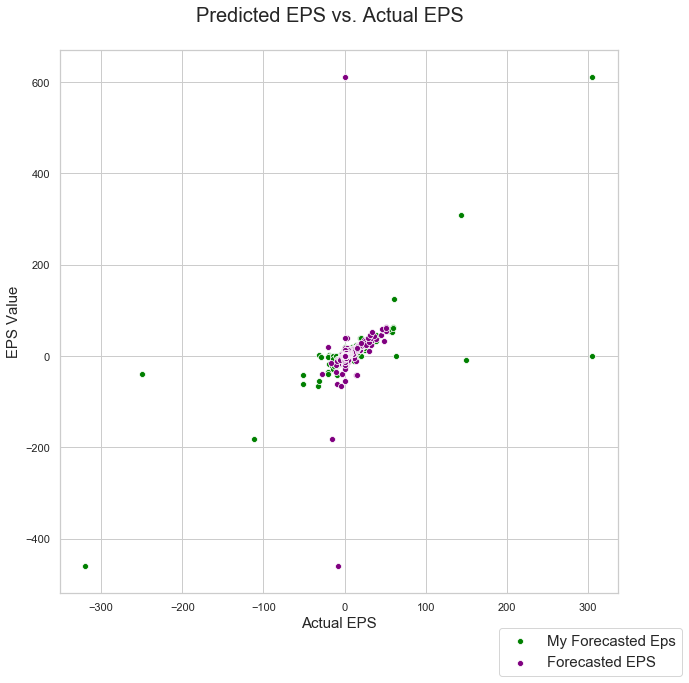

In [172]:
fig = plt.figure(figsize = [10, 10])

sb.scatterplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'green')
sb.scatterplot(data = features_dumb_eps, x = 'eps_fc_value', y = 'value', color = 'purple')

fig.legend(labels = ['My Forecasted Eps', 'Forecasted EPS'], prop = {'size' : 15}, loc = 'lower right')

plt.suptitle('Predicted EPS vs. Actual EPS', size = 20, y = .94)
# plt.title('in 3-year Moving Averages', size = 17)
plt.ylabel('EPS Value')
plt.xlabel('Actual EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-fc-scatter.png')
plt.show();

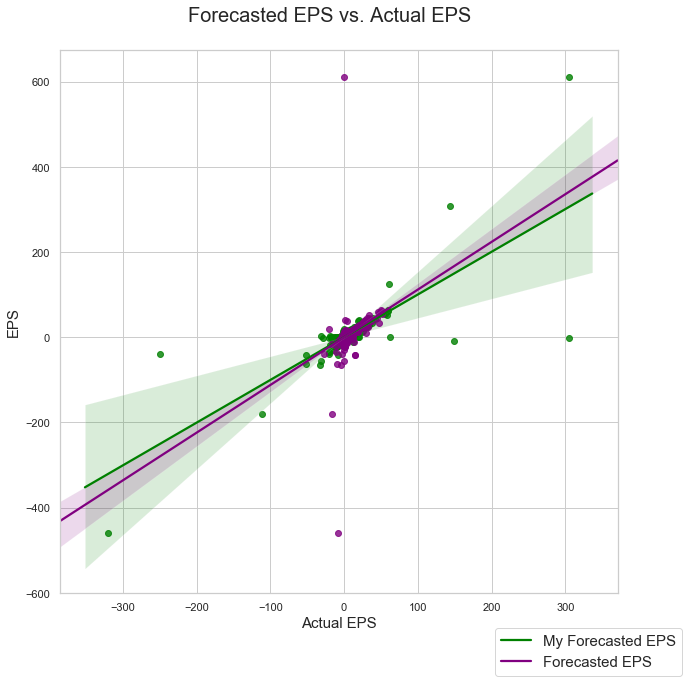

In [173]:
fig = plt.figure(figsize = [10, 10])

sb.regplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'green')
sb.regplot(data = features_dumb_eps, x = 'eps_fc_value', y = 'value', color = 'purple')

fig.legend(labels = ['My Forecasted EPS', 'Forecasted EPS'], prop = {'size' : 15}, loc = 'lower right')

plt.suptitle('Forecasted EPS vs. Actual EPS', size = 20, y = .94)
# plt.title('in 3-year Moving Averages', size = 17)
plt.ylabel('EPS')
plt.xlabel('Actual EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-fc-reg.png')
plt.show();

**2 Linear Regression Tests for My Predicted EPS & Forecasted EPS vs. Actual EPS**

In [174]:
#add intercept
features_dumb_eps_ols = features_dumb_eps.copy()
features_dumb_eps_ols['intercept'] = 1

In [175]:
#my forecast vs. actual
lm_dumb = sm.OLS(features_dumb_eps_ols['dumb_prediction'], features_dumb_eps_ols[['intercept', 'value']], missing = 'drop')
result_dumb = lm_dumb.fit()

result_dumb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        dumb_prediction   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 5.666e+04
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:16:32   Log-Likelihood:                -83164.
No. Observations:               36357   AIC:                         1.663e+05
Df Residuals:                   36355   BIC:                         1.663e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2667      0.013     21.118      0.000       0.242       0.291
value          0.6076      0.003    238.039      0.000       0.603       0.613
==============================================================================
Omnibus:                   108154.157   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     154136433848.584
Skew:                          41.401   Prob(JB):                         0.00
Kurtosis:                   10089.712   Cond. No.                         5.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
lm_fc = sm.OLS(features_dumb_eps_ols['eps_fc_value'], features_dumb_eps_ols[['intercept', 'value']], missing = 'drop')
result_fc = lm_fc.fit()

result_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eps_fc_value   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5115.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:16:32   Log-Likelihood:                -60477.
No. Observations:               34448   AIC:                         1.210e+05
Df Residuals:                   34446   BIC:                         1.210e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7034      0.008     92.170      0.000       0.688       0.718
value          0.1155      0.002     71.516      0.000       0.112       0.119
==============================================================================
Omnibus:                    53211.382   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        335545890.869
Skew:                           8.808   Prob(JB):                         0.00
Kurtosis:                     486.182   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

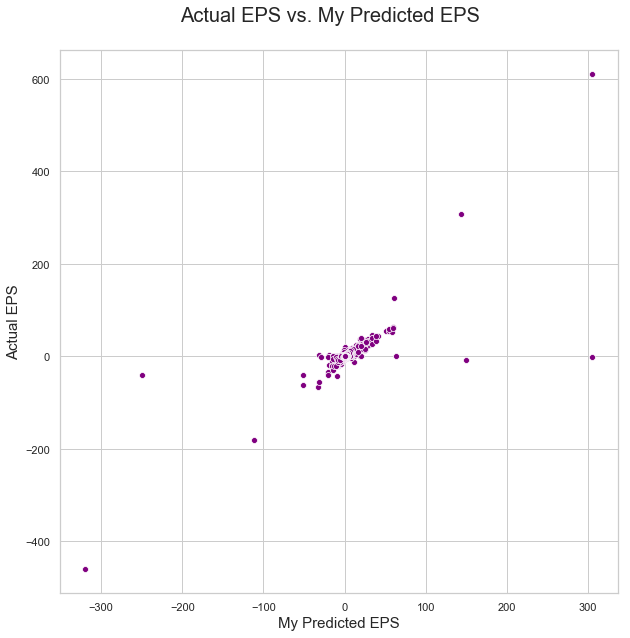

In [177]:
fig = plt.figure(figsize = [10, 10])

sb.scatterplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'purple')

plt.suptitle('Actual EPS vs. My Predicted EPS', size = 20, y = .94)
plt.ylabel('Actual EPS')
plt.xlabel('My Predicted EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-scatter.png')
plt.show();

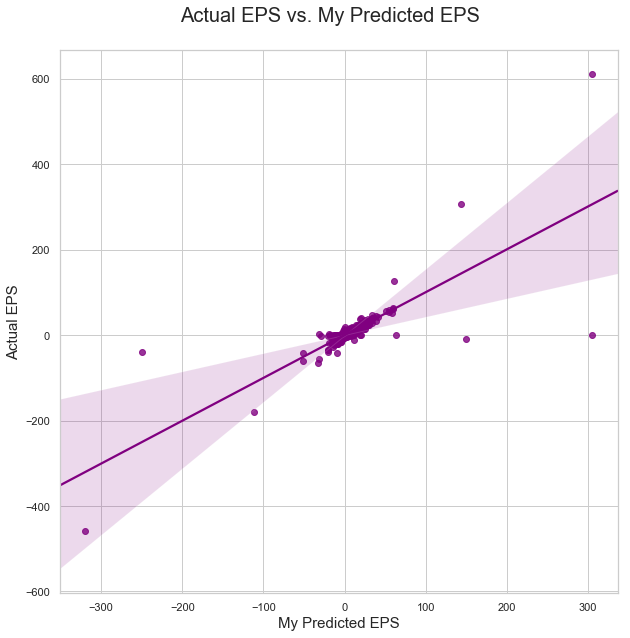

In [178]:
fig = plt.figure(figsize = [10, 10])

sb.regplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'purple')

plt.suptitle('Actual EPS vs. My Predicted EPS', size = 20, y = .94)
plt.ylabel('Actual EPS')
plt.xlabel('My Predicted EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-reg.png')
plt.show();

In [179]:
lm_dumb_act = sm.OLS(features_dumb_eps_ols['value'], features_dumb_eps_ols[['intercept', 'dumb_prediction']], missing = 'drop')
result_dumb_act = lm_dumb_act.fit()

result_dumb_act.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 5.666e+04
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:16:37   Log-Likelihood:                -92270.
No. Observations:               36357   AIC:                         1.845e+05
Df Residuals:                   36355   BIC:                         1.846e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0064      0.016      0.392      0.695      -0.026       0.038
dumb_prediction     1.0026      0.004    238.039      0.000       0.994       1.011
==============================================================================
Omnibus:                    50305.992   Durbin-Watson:                   2.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      65797589437.202
Skew:                           5.856   Prob(JB):                         0.00
Kurtosis:                    6593.463   Cond. No.                         3.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
value_vars = ['value', 'previous_value', 'dumb_prediction', 'eps_fc_value', 'ma_value', 'ma_previous_value',
             'ma_dumb_prediction', 'ma_eps_fc_value']

In [181]:
#melt dumb_predictions and eps_fc_value to prepare for plotting
df_dumb_eps_melt = pd.melt(features_dumb_eps, id_vars = ['firm_id', 'feature', 'term'],
       value_vars = value_vars,
       var_name = 'value_type')

In [182]:
#isolate only dumb predictions and eps_fc_value
dumb_eps_fc = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['dumb_prediction', 'eps_fc_value'])]

In [191]:
dumb_eps_fc['ma_value'] = dumb_eps_fc.value.rolling(12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [192]:
dumb_eps_fc.sample(5)

firm_id  feature    term       value_type  value  ma_value
109052      288  eps_act  2004Q1  dumb_prediction    NaN       NaN
93056        97  eps_act  2016Q1  dumb_prediction  0.855  0.775417
143585      194  eps_act  2006Q2     eps_fc_value    NaN       NaN
155204      332  eps_act  2013Q1     eps_fc_value -0.209  0.047000
132972       68  eps_act  1999Q1     eps_fc_value  0.435  5.945083

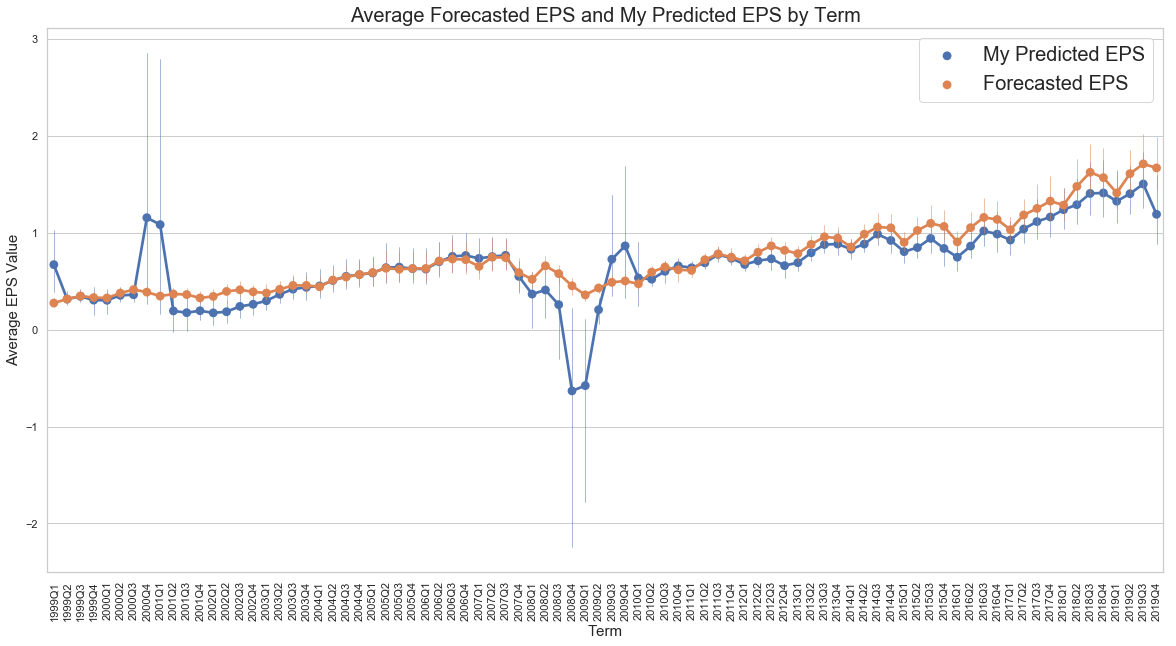

In [184]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(x = 'term', y = 'value', data = dumb_eps_fc, hue = 'value_type', errwidth = .5)

plt.xticks(rotation = 'vertical')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['My Predicted EPS', 'Forecasted EPS'], prop = {'size' : 20})

plt.title('Average Forecasted EPS and My Predicted EPS by Term', size = 20)
plt.ylabel('Average EPS Value')
plt.xlabel('Term')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-eps.png')
plt.show();

In [185]:
df_dumb_eps_melt.value_type.unique()

array(['value', 'previous_value', 'dumb_prediction', 'eps_fc_value',
       'ma_value', 'ma_previous_value', 'ma_dumb_prediction',
       'ma_eps_fc_value'], dtype=object)

In [198]:
#isolate actual EPS and personal predicted EPS
ma_dumb_fc = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['ma_value', 'ma_dumb_prediction'])]

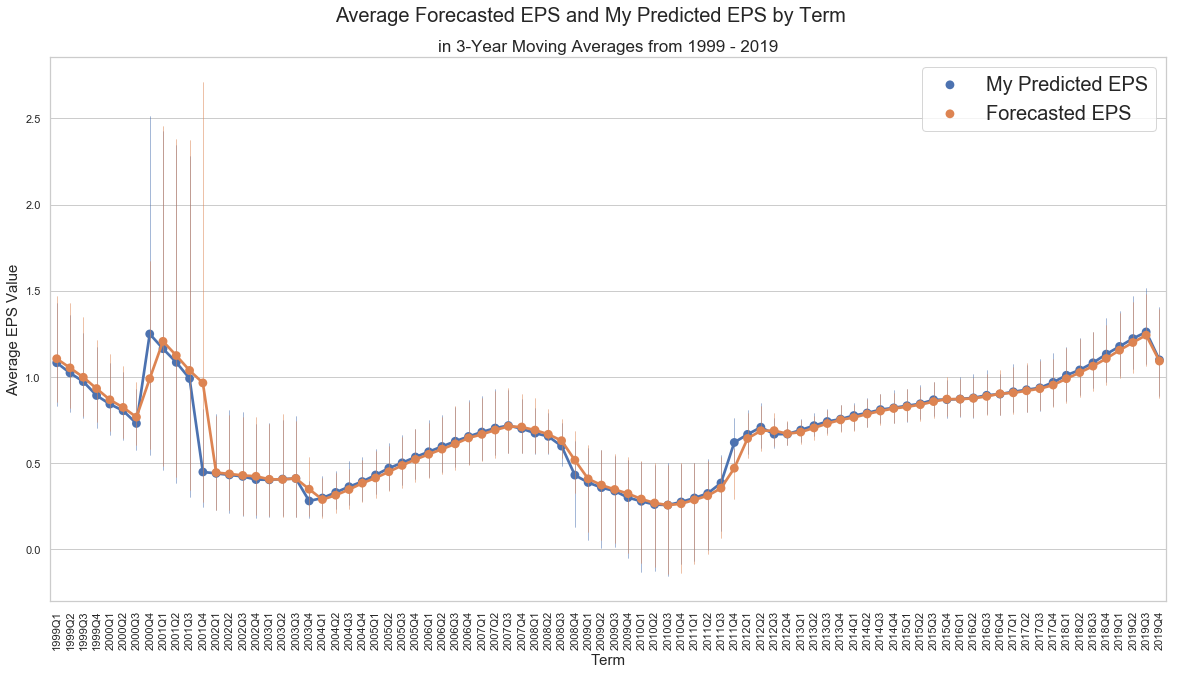

In [201]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(x = 'term', y = 'value', data = ma_dumb_fc, hue = 'value_type', errwidth = .5)

plt.xticks(rotation = 'vertical')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['My Predicted EPS', 'Forecasted EPS'], prop = {'size' : 20})

plt.suptitle('Average Forecasted EPS and My Predicted EPS by Term', size = 20, y = .95)
plt.title('in 3-Year Moving Averages from 1999 - 2019', size = 17)
plt.ylabel('Average EPS Value')
plt.xlabel('Term')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-eps-ma.png')
plt.show();

**Observation 1:** The technique that the Bloomberg forecasters used was much more effective than my method of predicting by using 2-quarter moving averages.

In [202]:
#isolate moving average actual and forecasted value
ma_fc_current = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['ma_eps_fc_value', 'ma_value'])]

In [203]:
#isolate actual and forecasted values
fc_current = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['eps_fc_value', 'ma_value'])]

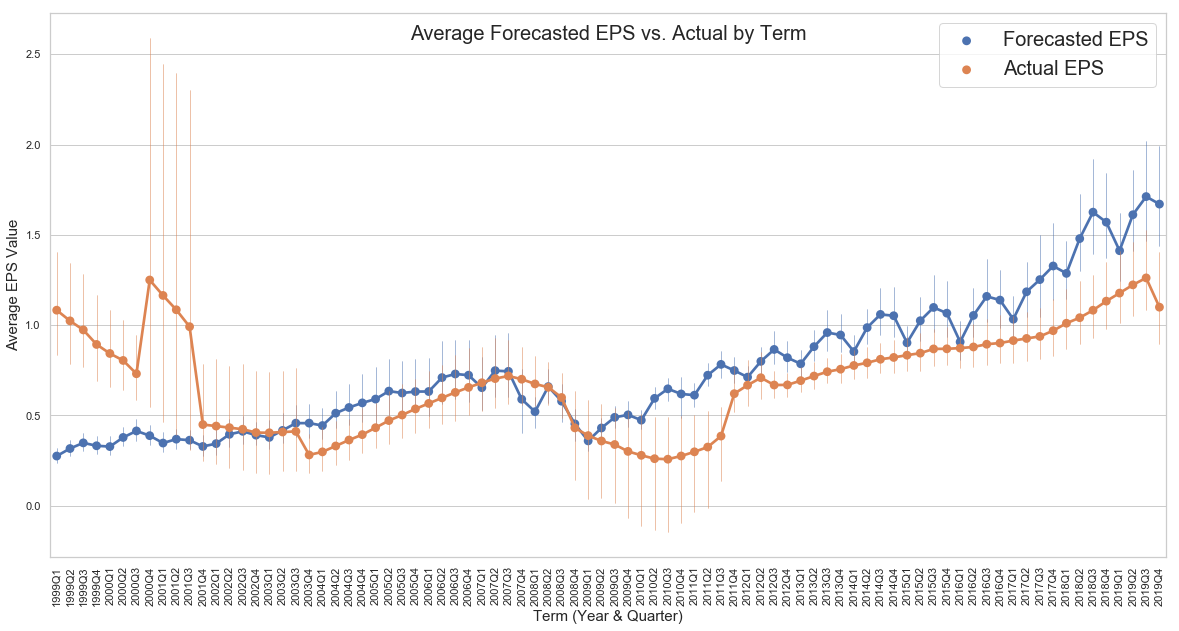

In [204]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(data = fc_current, x = 'term', y = 'value', hue = 'value_type', errwidth = .5)

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['Forecasted EPS', 'Actual EPS'], prop = {'size' : 20})

plt.title('Average Forecasted EPS vs. Actual by Term', y = .94, size = 20)
plt.ylabel('Average EPS Value')
plt.xlabel('Term (Year & Quarter)')
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'features-eps-fc-act-by-term.png')
plt.show();

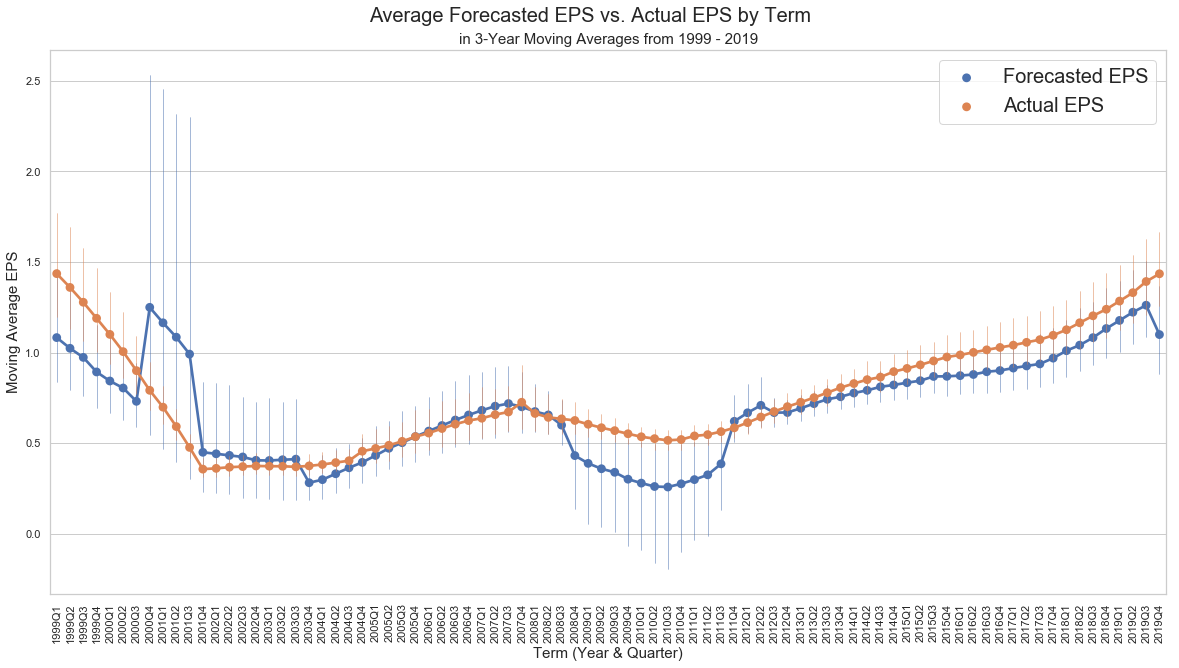

In [205]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(data = ma_fc_current, x = 'term', y = 'value', hue = 'value_type', errwidth = .5)

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['Forecasted EPS', 'Actual EPS'], prop = {'size' : 20})

plt.suptitle('Average Forecasted EPS vs. Actual EPS by Term', y = .94, size = 20)
plt.title('in 3-Year Moving Averages from 1999 - 2019', size = 15)
plt.ylabel('Moving Average EPS')
plt.xlabel('Term (Year & Quarter)')
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'features-eps-fc-act-by-term-ma.png')
plt.show();


### Term vs. Features
6) Which features under Term does not contain the year 1999?

### ?
7) How do value counts under Features look like after removing all outliers around the value range 0-300?

## V) Multivariate Exploration <a id="multi"></a>

idea: introduce a polar chart

### Time vs. Percentage Error vs. Firm IDs

In [206]:
#add percentage_error column to features
features_pct = features[features.feature.isin(['eps_fc', 'eps_act'])]

In [207]:
features_pct = separate_eps_fc_act(features_pct, ['firm_id', 'term'], 'value')

In [208]:
features_pct['pct_error'] = (features_pct.eps_act - features_pct.eps_fc) / features_pct.eps_act

In [209]:
features_pct['pct_error'] = features_pct['pct_error'].replace([np.inf, -np.inf], np.nan)

In [210]:
#get absolute value of percentage errors
features_pct['pct_error_abs'] = features_pct.pct_error.abs()

In [211]:
#add tick column for plotting assisance
features_pct['firm_tick'] = convert_ids_to_ticks(features_pct.firm_id)

In [212]:
#add 3-year moving averages for percentage error
features_pct['ma_pct_error'] = features_pct.pct_error.rolling(12).mean()

In [213]:
#grab top/bottom 10 firms
features_pct_top_ids = features_pct.sort_values(by = 'pct_error_abs', ascending = False).firm_id.drop_duplicates().head(5).values
features_pct_bottom_ids = features_pct.sort_values(by= 'pct_error_abs', ascending = True).firm_id.drop_duplicates().head(5).values

In [214]:
#filter DF for those 10 firms
features_pct_top = features_pct[features_pct.firm_id.isin(features_pct_top_ids)]
features_pct_bottom = features_pct[features_pct.firm_id.isin(features_pct_bottom_ids)]

> **Percentage Error by Year**

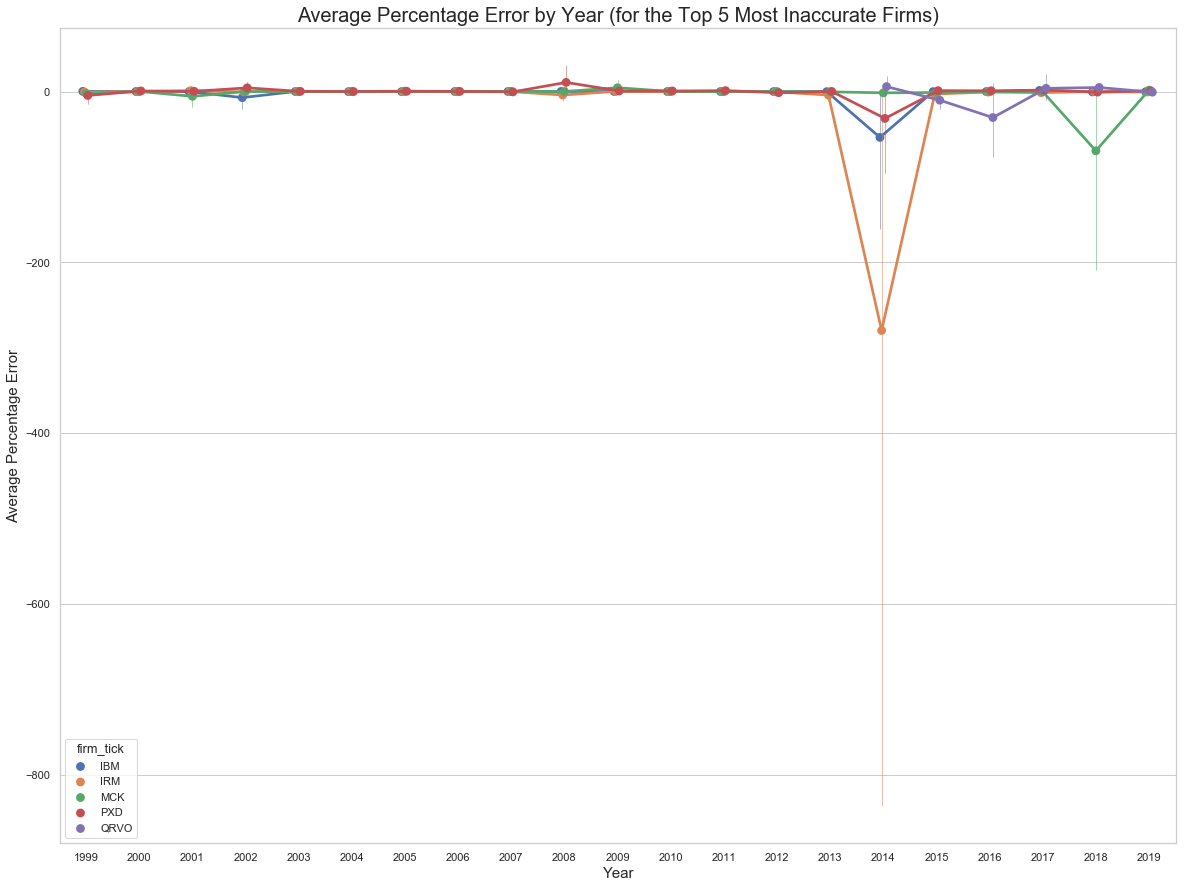

In [215]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_pct_top, x = features_pct_top.term.dt.year, y = 'pct_error',
                  hue = 'firm_tick', dodge = True, legend_out = False, errwidth = 0.5)


plt.xlabel('Year')
plt.ylabel('Average Percentage Error')
plt.title('Average Percentage Error by Year (for the Top 5 Most Inaccurate Firms)', size = 20)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year-top.png')
plt.show()

**The above visual isn't great for analysis. Let's look at a strip plot distribution instead.**

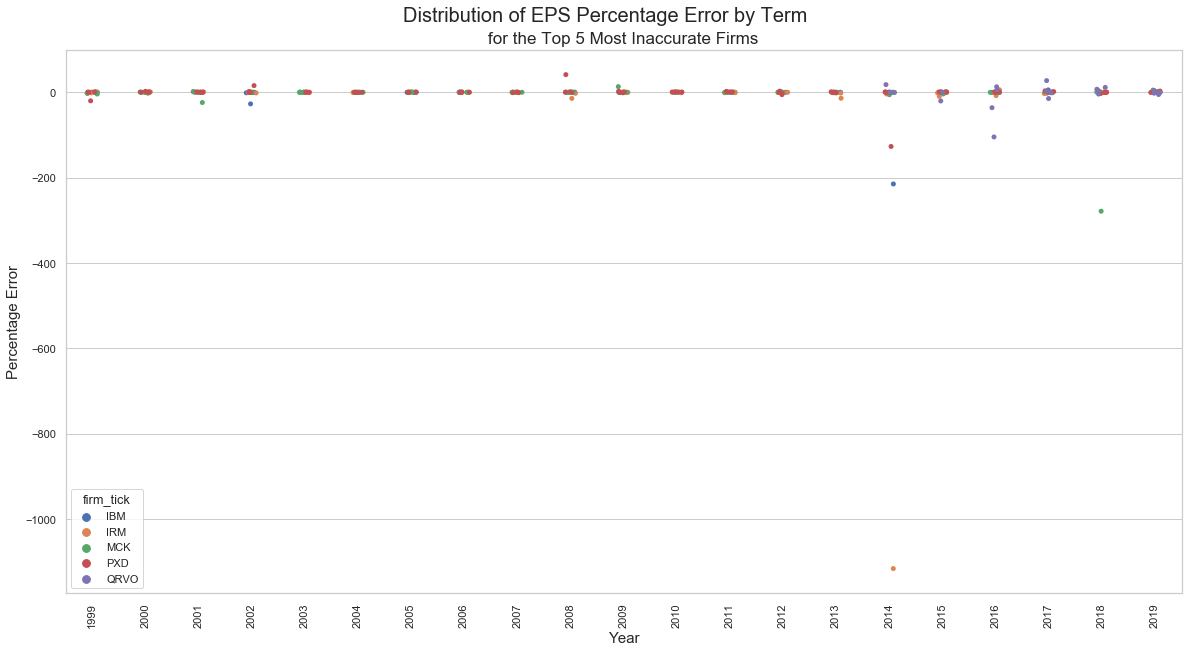

In [216]:
plt.figure(figsize = [20, 10])
sb.stripplot(data = features_pct_top, x = features_pct_top.term.dt.year, y = 'pct_error', hue = 'firm_tick')
plt.xticks(rotation = 'vertical')

plt.suptitle('Distribution of EPS Percentage Error by Term', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.xlabel('Year')
plt.ylabel('Percentage Error')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year-top-strip.png')

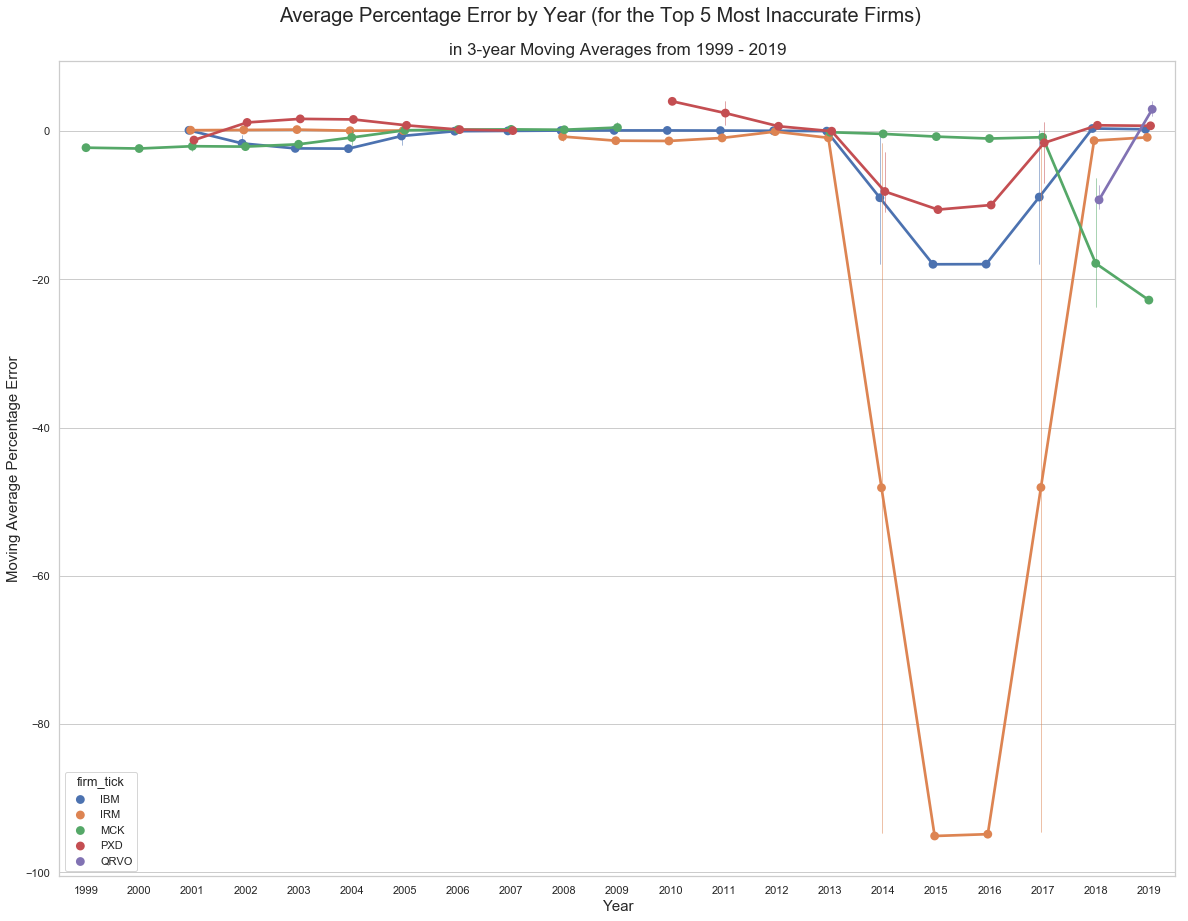

In [217]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_pct_top, x = features_pct_top.term.dt.year, y = 'ma_pct_error', hue = 'firm_tick', dodge = True,
                  legend_out = False, errwidth = 0.5)

#edit legend
# convert_legend_to_ticks(ax)

plt.xlabel('Year')
plt.ylabel('Moving Average Percentage Error')
plt.suptitle('Average Percentage Error by Year (for the Top 5 Most Inaccurate Firms)', size = 20, y = .93)
plt.title('in 3-year Moving Averages from 1999 - 2019', size = 17)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year-ma.png')
plt.show()

> **Percentage Error by Quarter**

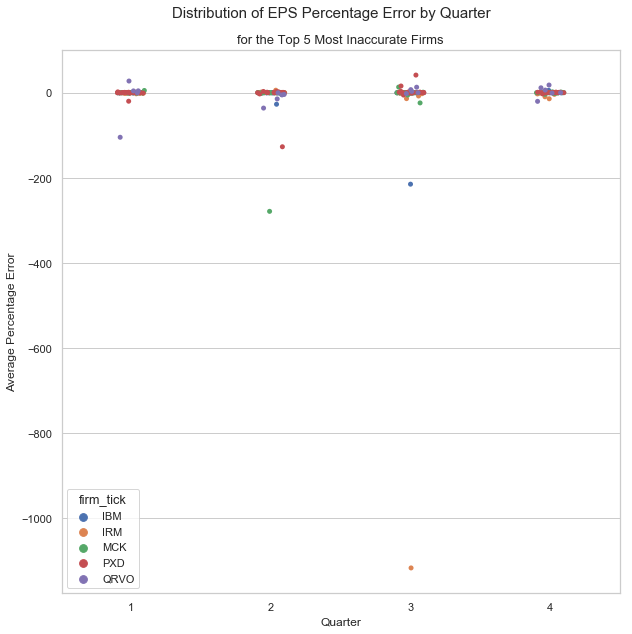

In [218]:
plt.figure(figsize = [10, 10])
ax = sb.stripplot(data = features_pct_top, x = features_pct_top.term.dt.quarter, y = 'pct_error',
                  hue = 'firm_tick', jitter = True)

plt.suptitle('Distribution of EPS Percentage Error by Quarter', size = 15, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 13)
plt.ylabel('Average Percentage Error', size = 12)
plt.xlabel('Quarter', size = 12)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-quarter-top-strip.png')

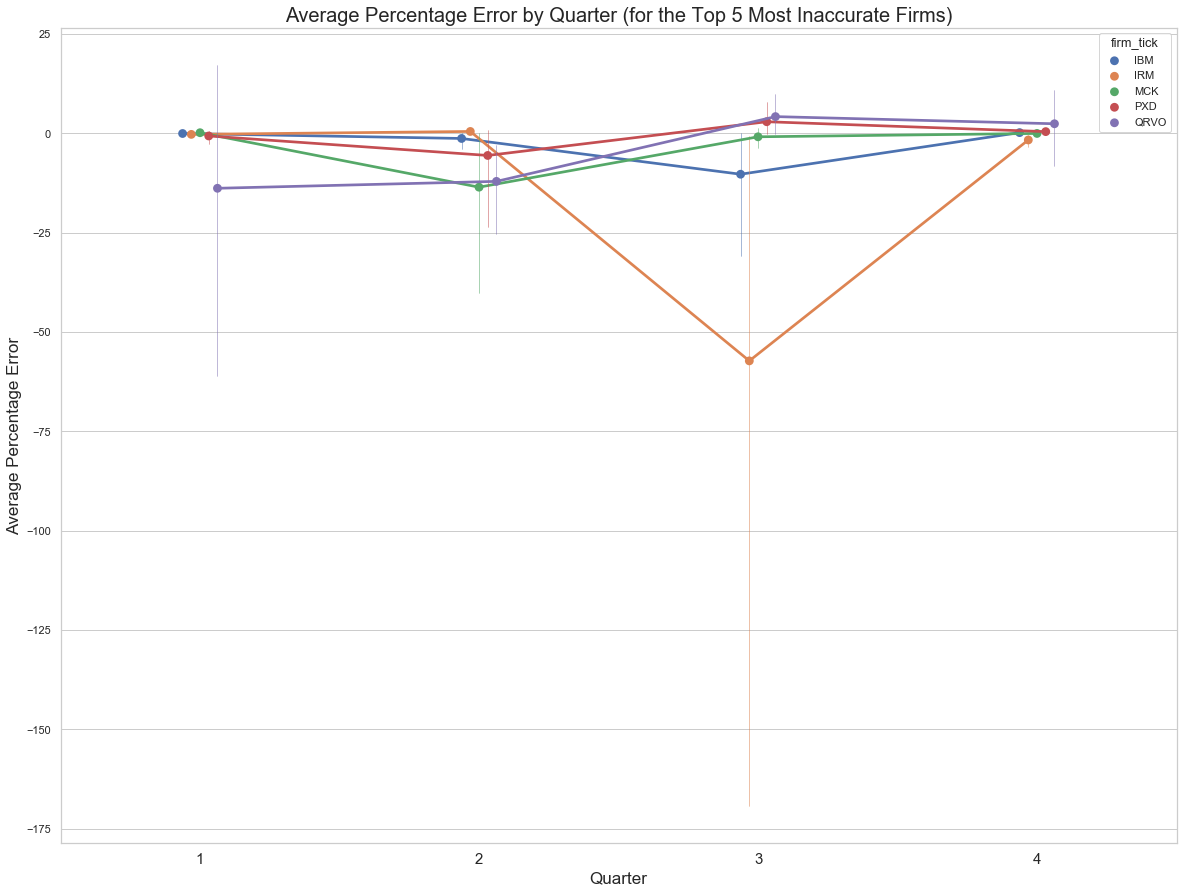

In [219]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_pct_top, x = features_pct_top.term.dt.quarter, y = 'pct_error', hue = 'firm_tick', dodge = True,
                  legend_out = False, errwidth = 0.5)

plt.xlabel('Quarter', size = 17)
plt.ylabel('Average Percentage Error', size = 17)
plt.title('Average Percentage Error by Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)
plt.xticks(size = 15)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-quarter.png')
plt.show()

> **Percentage Error by Year and Quarter**


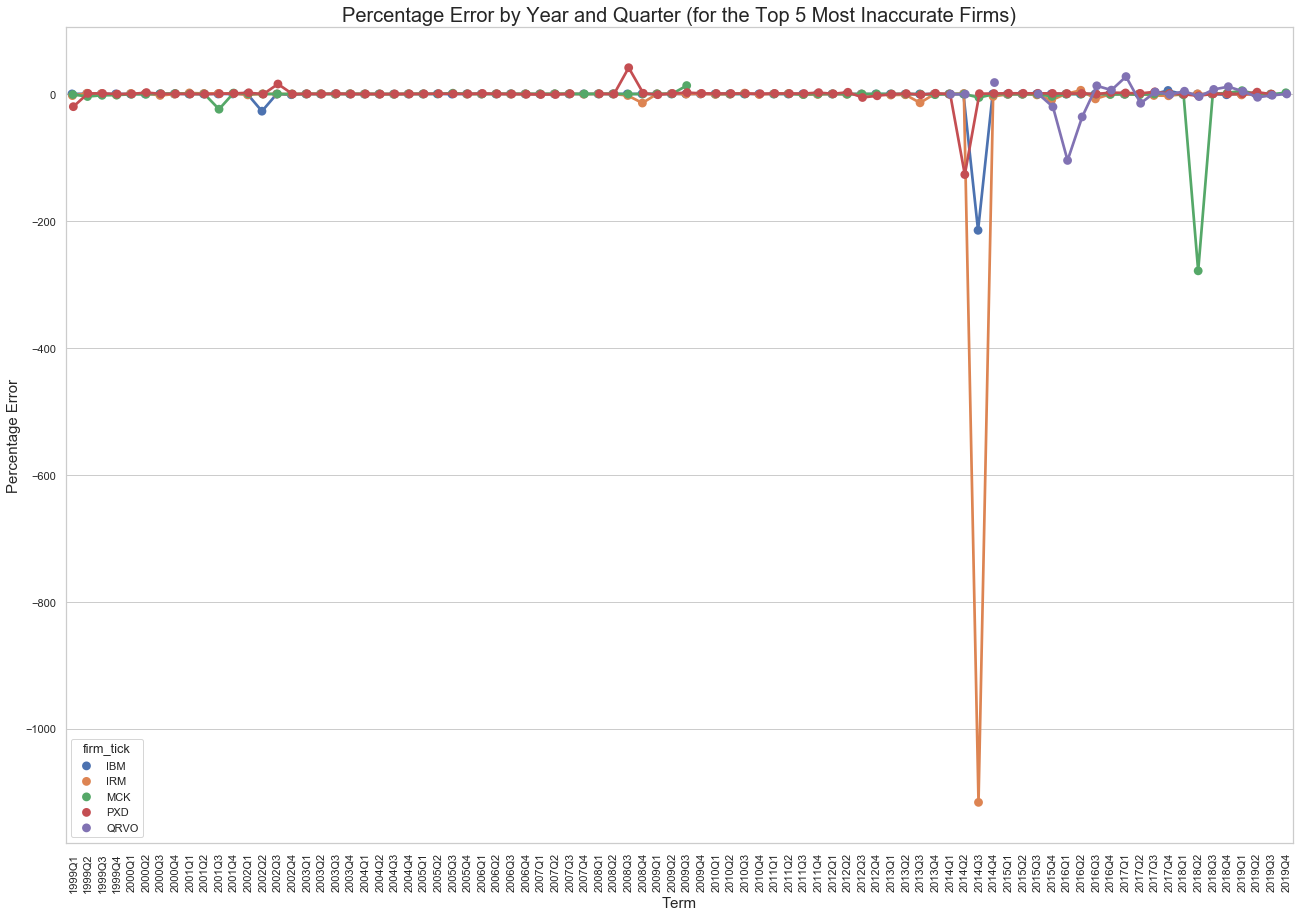

In [220]:
plt.figure(figsize = [22, 15])
ax = sb.pointplot(data = features_pct_top, x = 'term', y = 'pct_error', hue = 'firm_tick', dodge = True,
                  legend_out = False)

plt.xlabel('Term')
plt.ylabel('Percentage Error')
plt.title('Percentage Error by Year and Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-term.png')
plt.show()

**This isn't a very good visualization either. Let's look at a stripplot instead:**

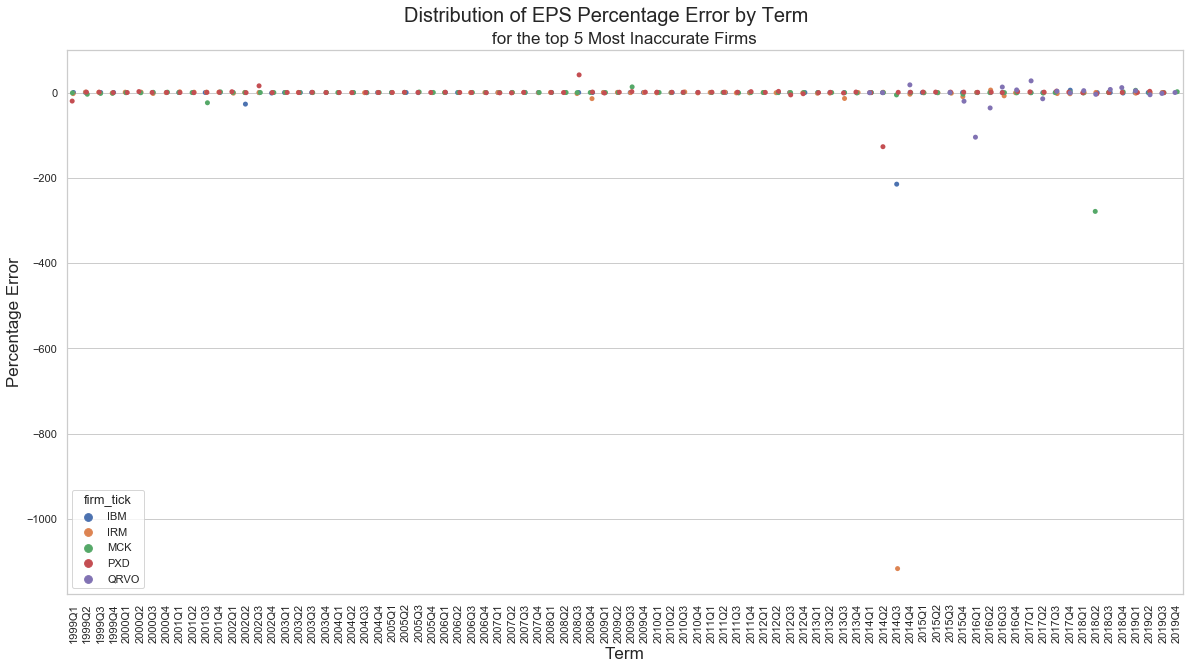

In [221]:
plt.figure(figsize = [20, 10])
sb.stripplot(data = features_pct_top, x = 'term', y = 'pct_error', hue = 'firm_tick')

plt.suptitle('Distribution of EPS Percentage Error by Term', size = 20, y = .94)
plt.title('for the top 5 Most Inaccurate Firms', size = 17)

plt.xlabel('Term', size = 17)
plt.ylabel('Percentage Error', size = 17)
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'pct-ferm-tirm-strip.png')
plt.show();

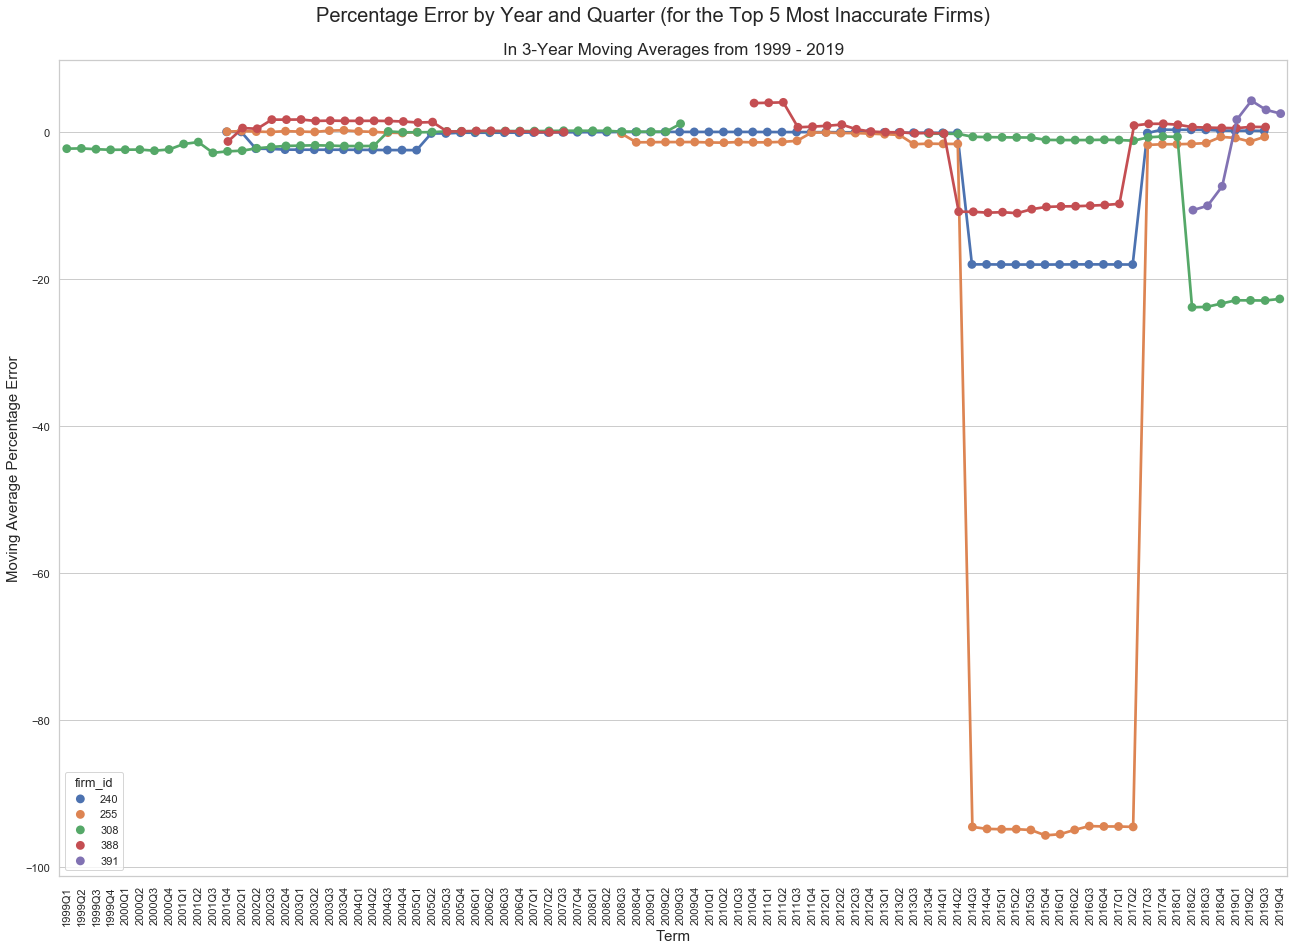

In [223]:
plt.figure(figsize = [22, 15])
ax = sb.pointplot(data = features_pct_top, x = 'term', y = 'ma_pct_error', hue = 'firm_id', dodge = True,
                  legend_out = False)

plt.xlabel('Term')
plt.ylabel('Moving Average Percentage Error')
plt.suptitle('Percentage Error by Year and Quarter (for the Top 5 Most Inaccurate Firms)', y = .93, size = 20)
plt.title('In 3-Year Moving Averages from 1999 - 2019', size = 17)
plt.xticks(rotation = 'vertical')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-term-ma.png')
plt.show()

### Values by Feature by Term

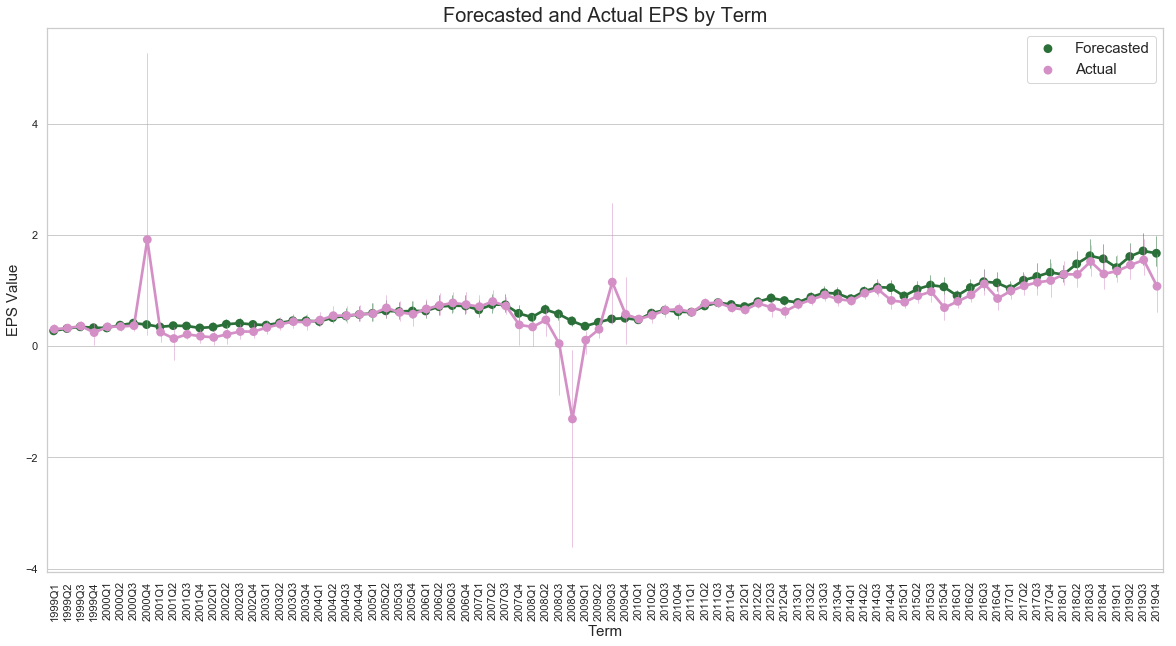

In [224]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(data = features_eps_fc_act, x = 'term', y = 'value',
                  hue = 'feature', dodge = True, legend_out = False, palette = "cubehelix", errwidth = .5)
plt.xticks(rotation = 'vertical')


plt.title('Forecasted and Actual EPS by Term', size = 20)
plt.ylabel('EPS Value')
plt.xlabel('Term')

#adjust legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Forecasted', 'Actual']
ax.legend(handles, labels, prop = {'size' : 15})

plt.savefig(PATH_MULTIVARIATE + 'features-eps-by-term.png')
plt.show();

In [225]:
features_eps_fc_act['ma_value'] = features_eps_fc_act.value.rolling(12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


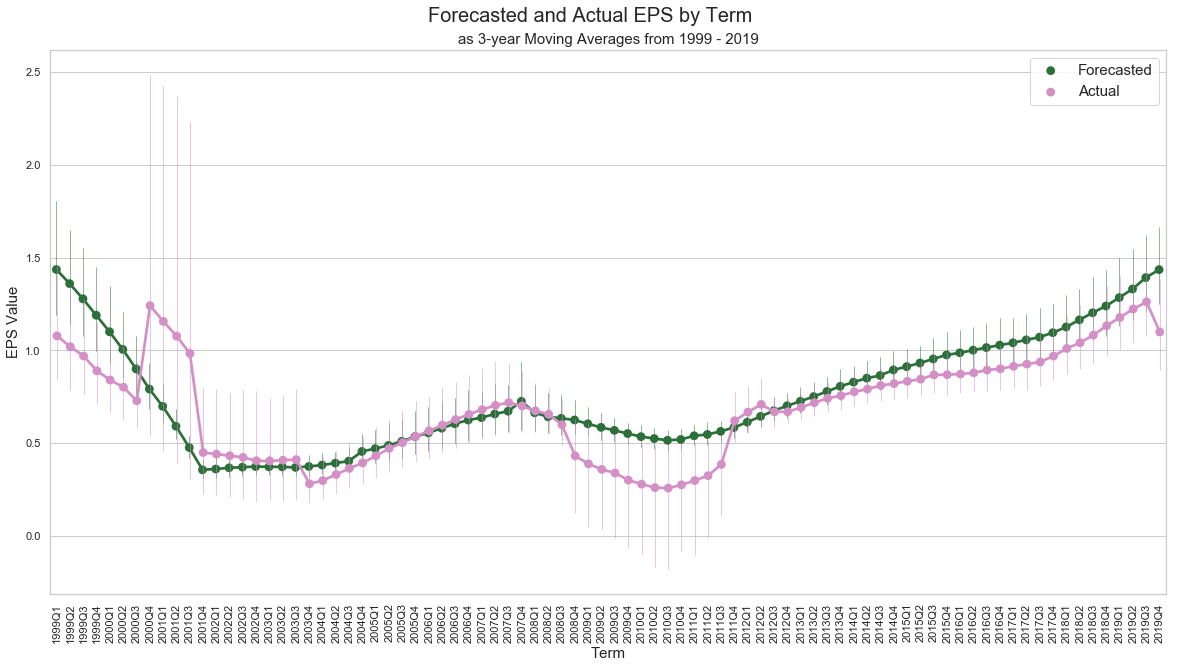

In [226]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(data = features_eps_fc_act, x = 'term', y = 'ma_value',
                  hue = 'feature', dodge = True, legend_out = False, palette = "cubehelix", errwidth = .5)
plt.xticks(rotation = 'vertical')


plt.suptitle('Forecasted and Actual EPS by Term', size = 20, y = .94)
plt.title('as 3-year Moving Averages from 1999 - 2019', size = 15)
plt.ylabel('EPS Value')
plt.xlabel('Term')

#adjust legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Forecasted', 'Actual']
ax.legend(handles, labels, prop = {'size' : 15})

plt.savefig(PATH_MULTIVARIATE + 'features-eps-by-term-ma.png')
plt.show();

### Prediction Error by Term by Top 5 Firms

In [227]:
features_pct['difference'] = features_pct.eps_act - features_pct.eps_fc

In [228]:
features_pct['difference_abs'] = features_pct.difference.abs()

In [232]:
diffs_top_ids = features_pct.sort_values(by = 'difference_abs', ascending = False).firm_id.drop_duplicates().head(5).values
diffs_bottom_ids = features_pct.sort_values(by = 'difference_abs', ascending = True).firm_id.drop_duplicates().head(5).values

In [233]:
diffs_top = features_pct[features_pct.firm_id.isin(diffs_top_ids)]
diffs_bottom = features_pct[features_pct.firm_id.isin(diffs_bottom_ids)]

> **Prediction Error by Term**

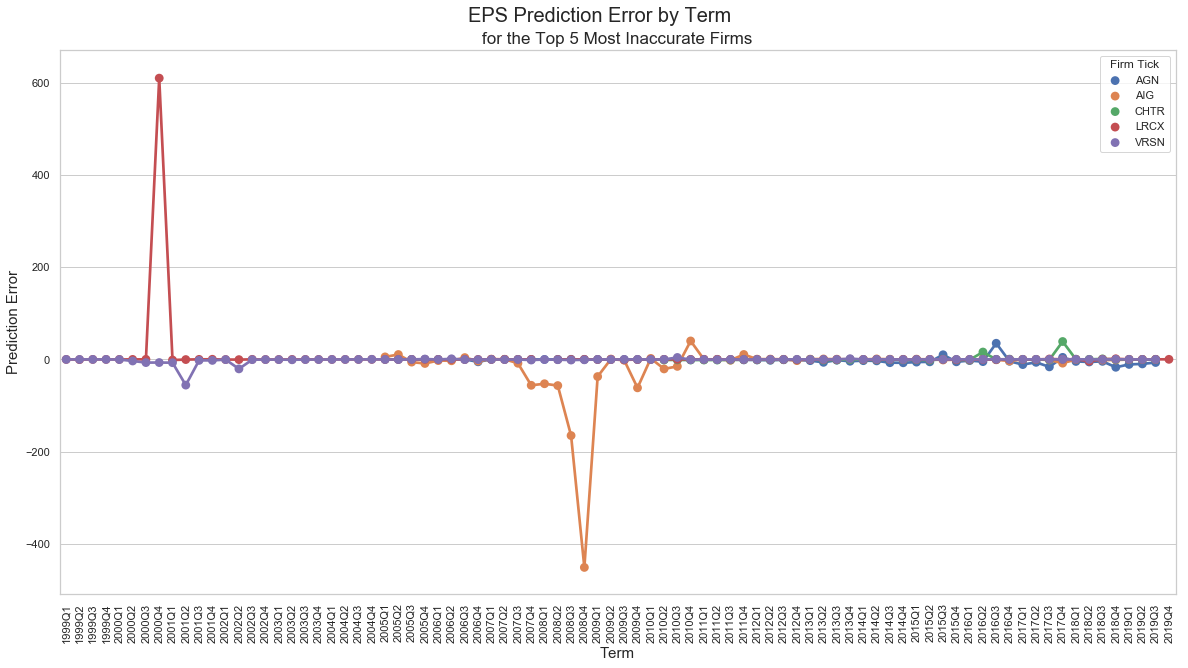

In [234]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term, y = 'difference', hue = 'firm_tick', errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xticks(rotation = 'vertical')
plt.xlabel('Term')
plt.ylabel('Prediction Error')
plt.suptitle('EPS Prediction Error by Term', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-term-firm.png')
plt.show();

> **Prediction Error by Year**

In [ ]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term.dt.year, y = 'difference', hue = 'firm_tick',errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xticks(rotation = 'vertical')
plt.xlabel('Term')
plt.ylabel('Prediction Error')
plt.suptitle('Average EPS Prediction Error by Year', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-year-firm.png')
plt.show();

> **Prediction Error by Quarter**

In [ ]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term.dt.quarter, y = 'difference', hue = 'firm_tick',errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xlabel('Quarter')
plt.ylabel('Prediction Error')
plt.suptitle('Average EPS Prediction Error by Quarter', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)
plt.xticks(size = 15)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-quarter-firm.png')
plt.show();

# Conclusions <a id = "conclude"> </a>

**Dumb Predictions**

- The technique that the Bloomberg forecasters used was much more effective than my method of predicting by using 2-quarter moving averages.

---

**Prediction Errors**

- are the prediction error charts consistent with the average percentage error charts?

Apparently, the top 5 most inaccurate firms are different when looking at percentage error and prediction error.

The charts with Firm IDs on the x-axis aren't useful, but they were a good visual aid for spotting Firm IDs that have consistently shown to be outliers. (that is, the most inaccurate companies)

- After isolating the top 5-10 most inaccurate companies numerically, confirm that their firm IDs are consistent with those graphs where Firm IDs are on the x-axis

The EOD graph could be used to make correlations with EPS forecasts and how the firm is getting "richer" overtime.

Compare bivariate prediction error patterns to **multivariate forecasted and actual EPS by term**, and **percentage error** charts
- by term, quarter, and year